In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
f_sig = "signal_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    #"QCD":"bkg_2018_QCD_TuneCP5_PSWeights_ejdR_rejection_IDcut.coffea", QCD doesn't make it to cut 13 here!
    "Top":"bkg_2018_Top_ejdR_rejection_IDcut.coffea",
    "DY":"bkg_2018_DY_ejdR_rejection_IDcut.coffea",
    "Diboson":"bkg_2018_Diboson_ejdR_rejection_IDcut.coffea",
    "Triboson":"bkg_2018_Triboson_ejdR_rejection_IDcut.coffea",
    "W+jets":"bkg_2018_WJets_ejdR_rejection_IDcut.coffea",
    "Z+jets":"bkg_2018_ZJets_ejdR_rejection_IDcut.coffea"
}
bkg_histos = {}
histograms = []
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['W+jets'][h]) == hist.Hist and bkg_histos['W+jets'][h].sum(flow=True).value > 0:
        bkg[h] = {b:bkg_histos[b][h][{"samp":sum}] for b in bkg_histos.keys()}

In [22]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [23]:
cut = "cut13" # last cut of base set

In [6]:
print("\n".join(histos))

sel_e1_pt
sel_e1_trkIso
sel_e1_trkRelIso
sel_e1_PFRelIso
sel_e1_PFRelIso3
sel_e1_PFRelIso4
sel_e1_PFRelIso8
sel_e1_PFIso3
sel_e1_PFIso4
sel_e1_PFIso8
sel_e1_trkChi2
sel_e1_trkProb
sel_e1_dxy
sel_e1_dxySignif
sel_e1_angRes
sel_e2_pt
sel_e2_trkIso
sel_e2_trkRelIso
sel_e2_PFRelIso
sel_e2_PFRelIso3
sel_e2_PFRelIso4
sel_e2_PFRelIso8
sel_e2_PFIso3
sel_e2_PFIso4
sel_e2_PFIso8
sel_e2_trkChi2
sel_e2_trkProb
sel_e2_dxy
sel_e2_dxySignif
sel_e2_angRes
sel_e1_pt_vs_trkIso
sel_e1_pt_vs_trkRelIso
sel_e1_pt_vs_chi2
sel_e1_chi2_vs_dxy
sel_e1_numHits_vs_trkChi2
sel_e1_numHits_vs_trkProb
sel_e2_pt_vs_trkIso
sel_e2_pt_vs_trkRelIso
sel_e2_pt_vs_chi2
sel_e2_chi2_vs_dxy
sel_e2_numHits_vs_trkChi2
sel_e2_numHits_vs_trkProb
sel_vtx_type
sel_vtx_sign
sel_vtx_dR
sel_vtx_dR_over_pT
sel_vtx_dR_over_m
sel_vtx_dR_over_pTm
sel_vtx_dR_over_mpT
sel_vtx_chi2
sel_vtx_prob
sel_vtx_vxy
sel_vtx_vxy_zoom
sel_vtx_vxy_zoomzoom
sel_vtx_vxySignif
sel_vtx_mass
sel_vtx_minDxy
sel_vtx_pt
sel_vtx_eta
sel_vtx_phi
sel_vtx_PFRelIso3
sel

In [24]:
def plot(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None):
    nb = len(bkg_histos.keys())
    hb = hist.Stack.from_dict({b:bkg[hname][b][cut,::rebin] for b in bkg_histos.keys()})
    varAx = hb.axes[-1]
    for delta in deltas:
        plt.figure(figsize=(16,4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for i,ct in enumerate(ctaus):
            plt.subplot(1,4,i+1)
            plt.title(r"$c\tau = {0}$ mm".format(ct))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            for m1 in m1s:
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][point,cut,::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=False)
            
            if logy:
                plt.yscale('log')
            plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            
            ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
            if i==0:
                plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)
        
        plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        plt.savefig(f"plots/histos/{hname}_delta{delta:.1f}_jetRejIDcut.pdf")
        plt.tight_layout()

# Isolation

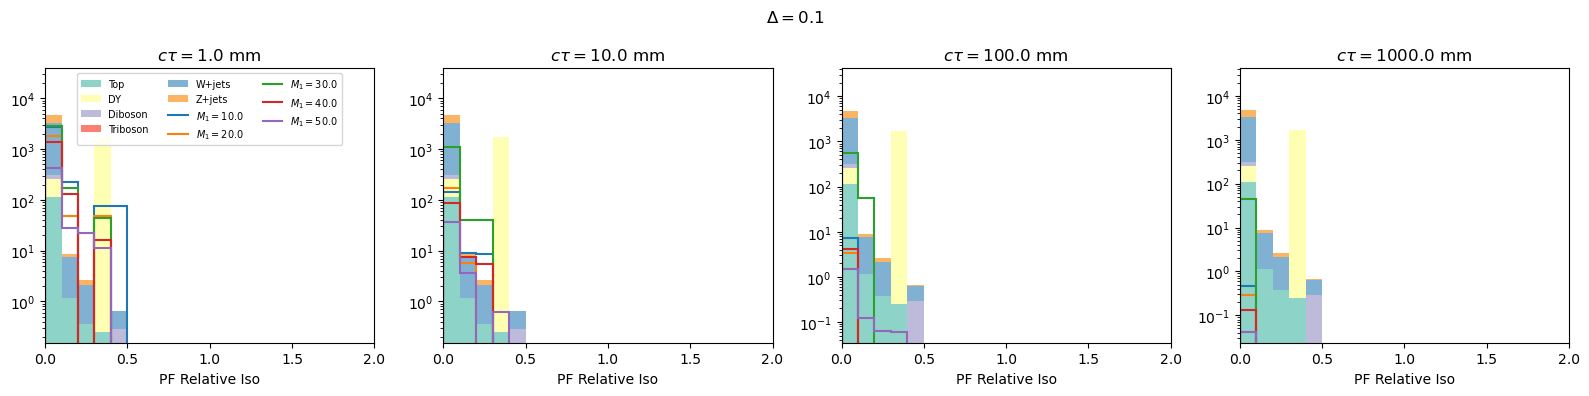

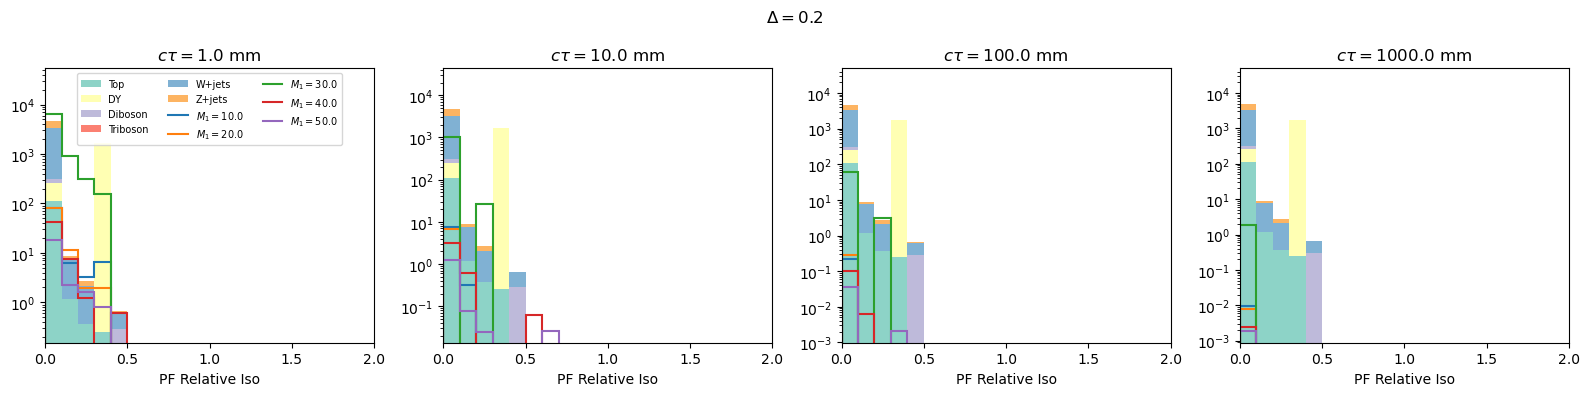

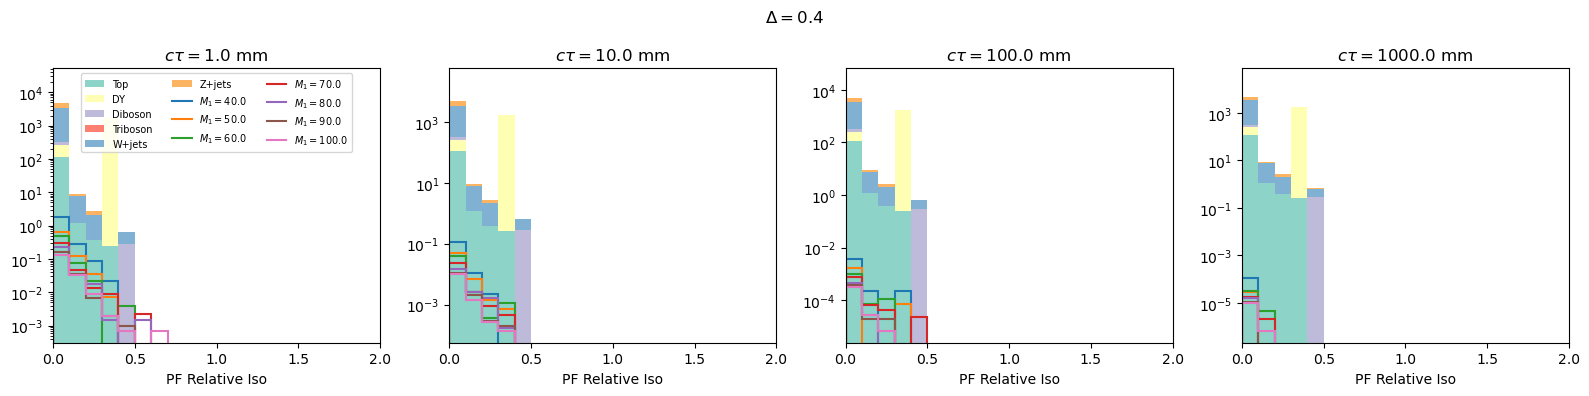

In [25]:
# electron 1 PF isolation dR < 0.3
plot("sel_e1_PFRelIso",[0,2],logy=True,rebin=1j)

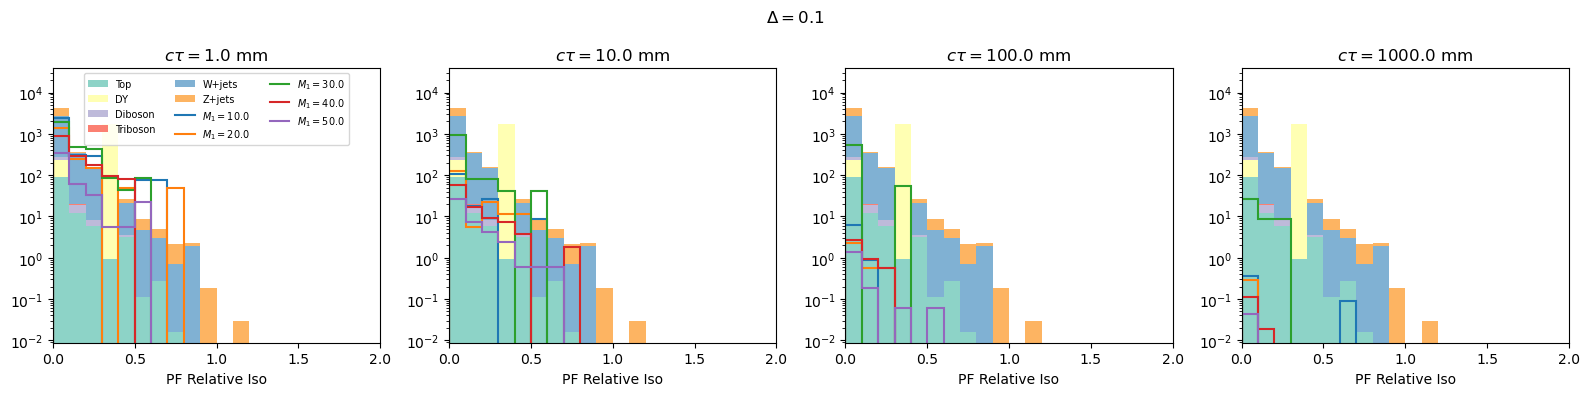

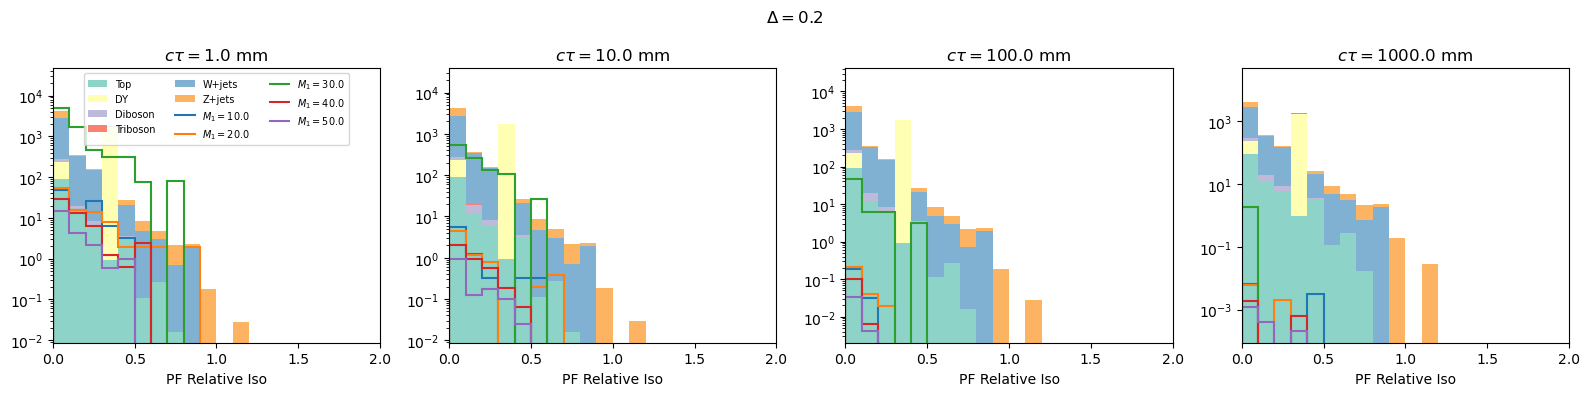

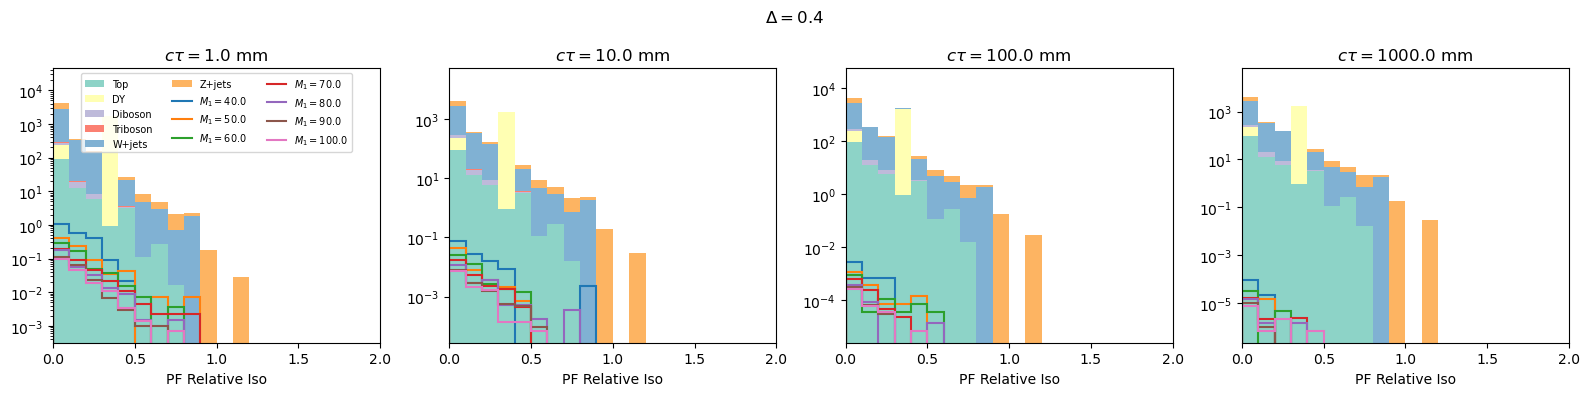

In [26]:
# electron 1 PF isolation dR < 0.3
plot("sel_e2_PFRelIso",[0,2],logy=True,rebin=1j)

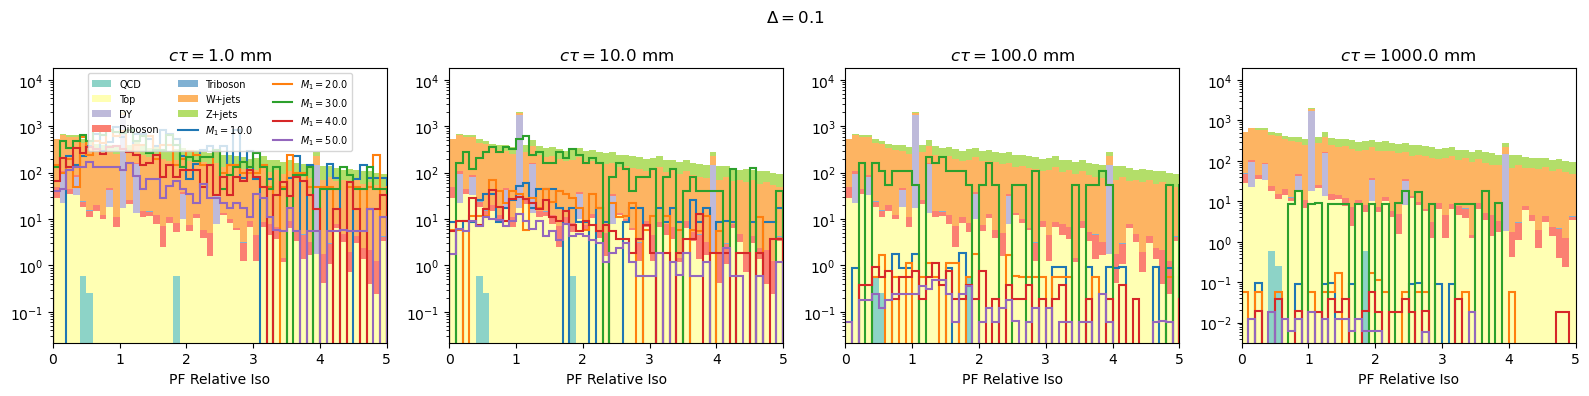

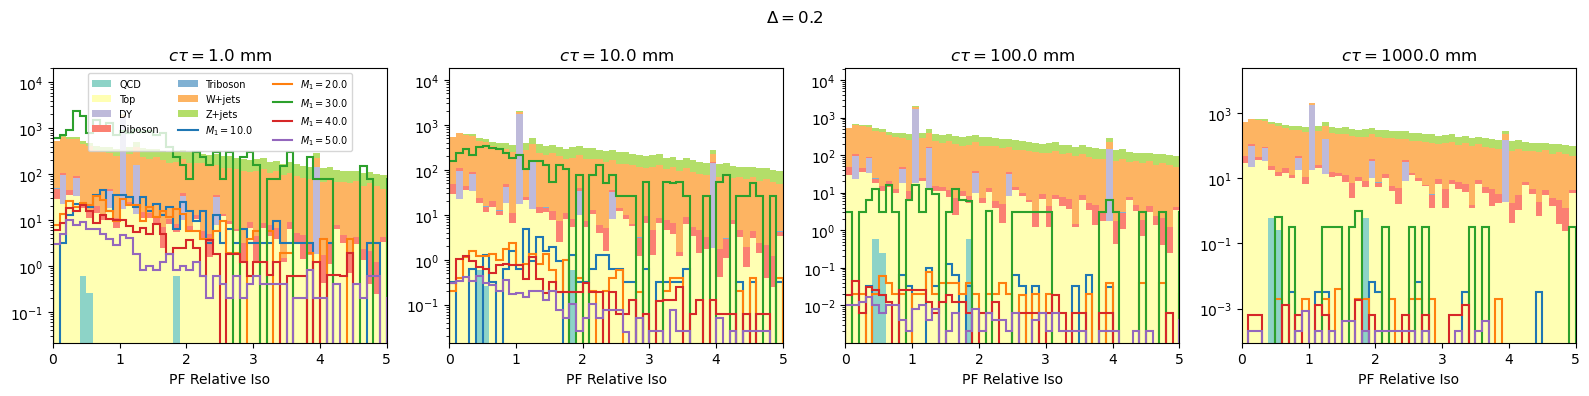

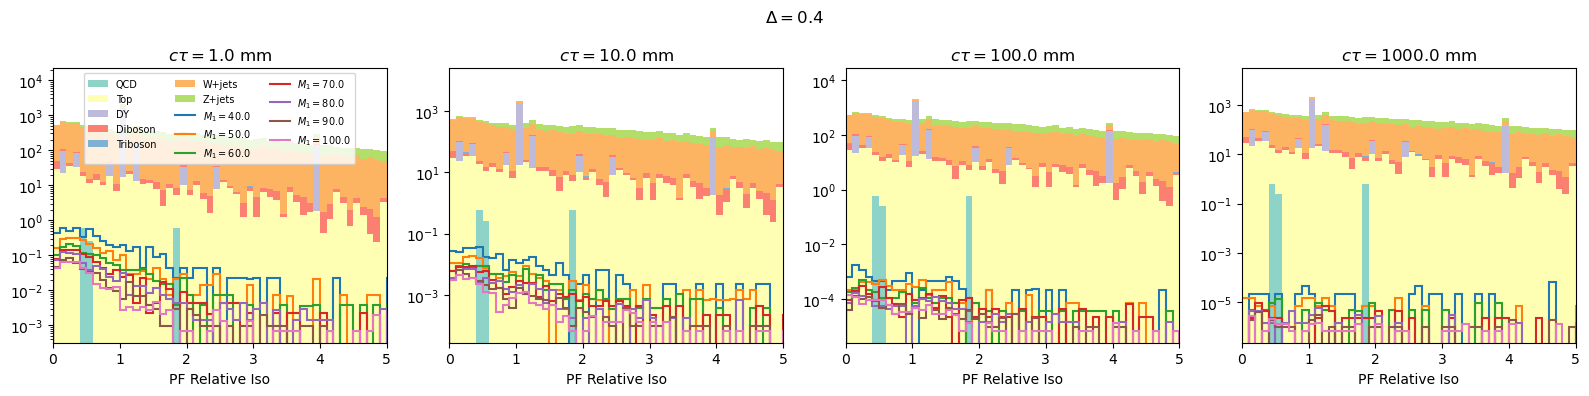

In [10]:
# electron 1 PF isolation dR < 0.3
plot("sel_e1_PFRelIso3",[0,5],logy=True,rebin=1j)

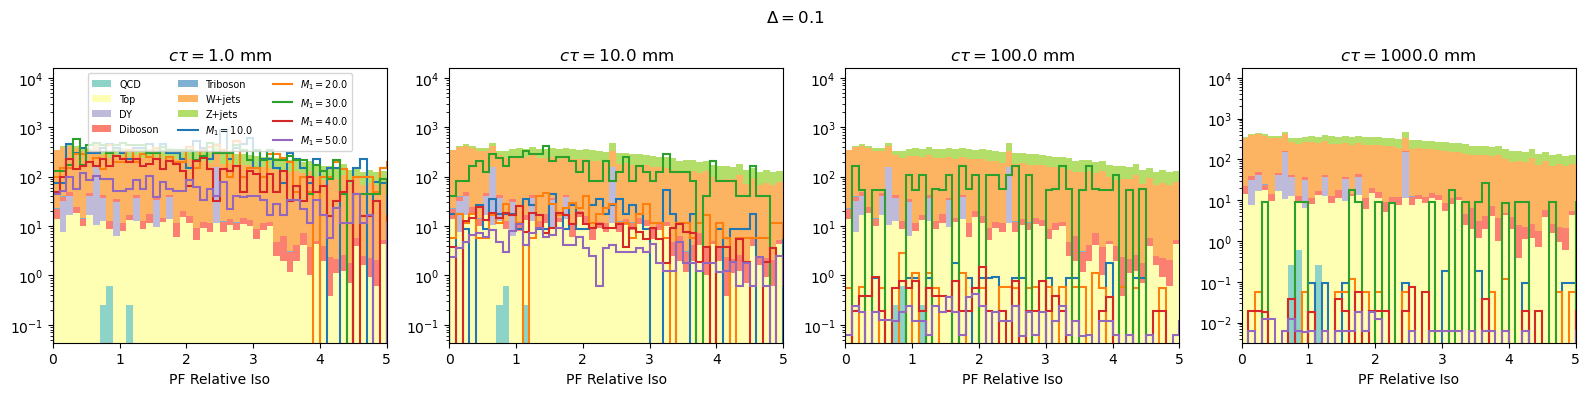

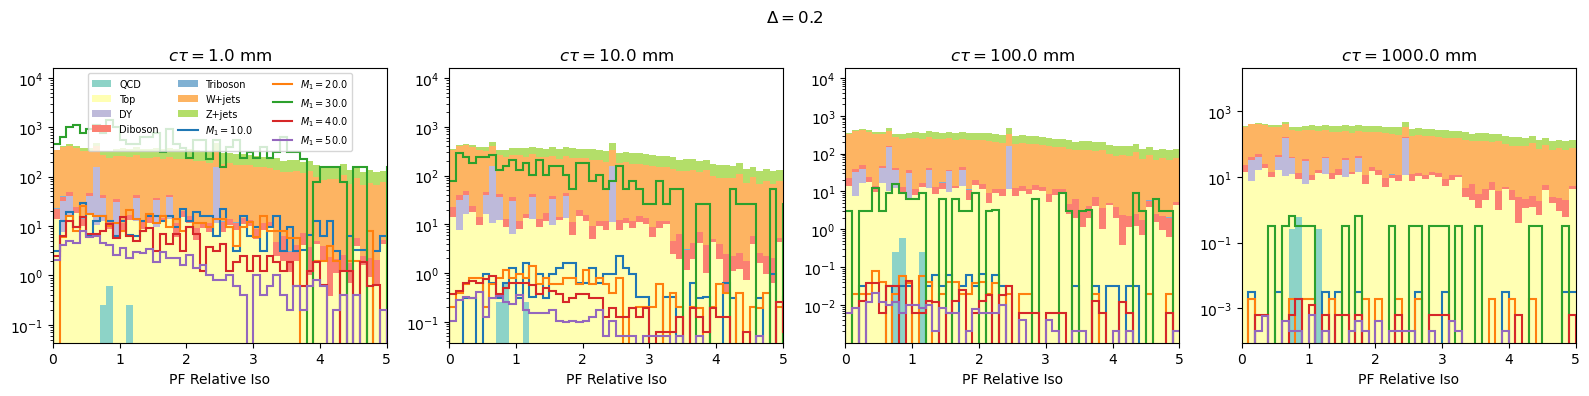

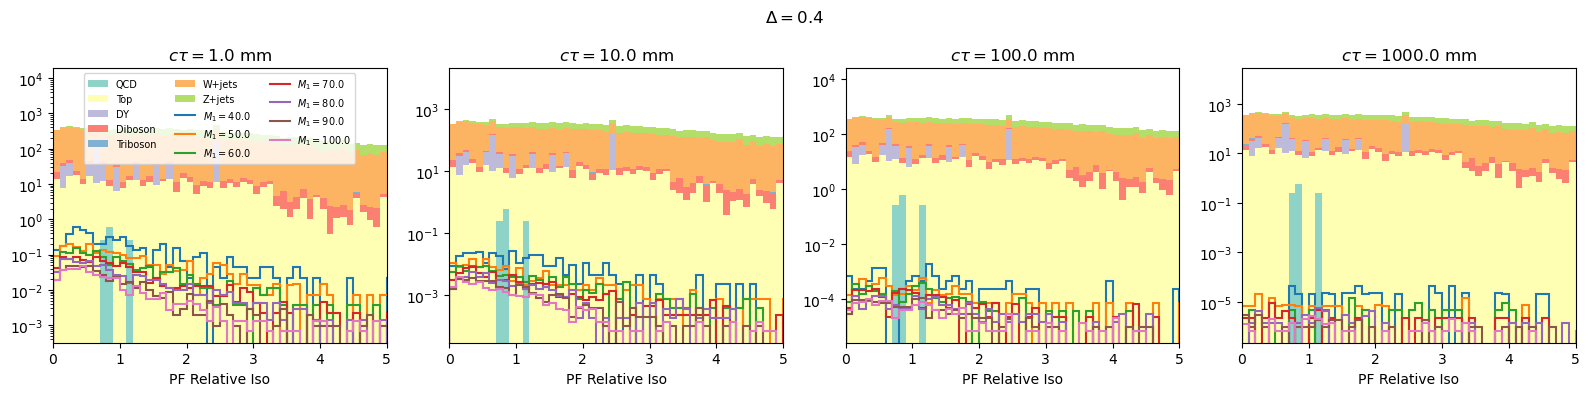

In [11]:
# electron 2 relative PF isolation dR < 0.3
plot("sel_e2_PFRelIso3",[0,5],logy=True,rebin=1j)

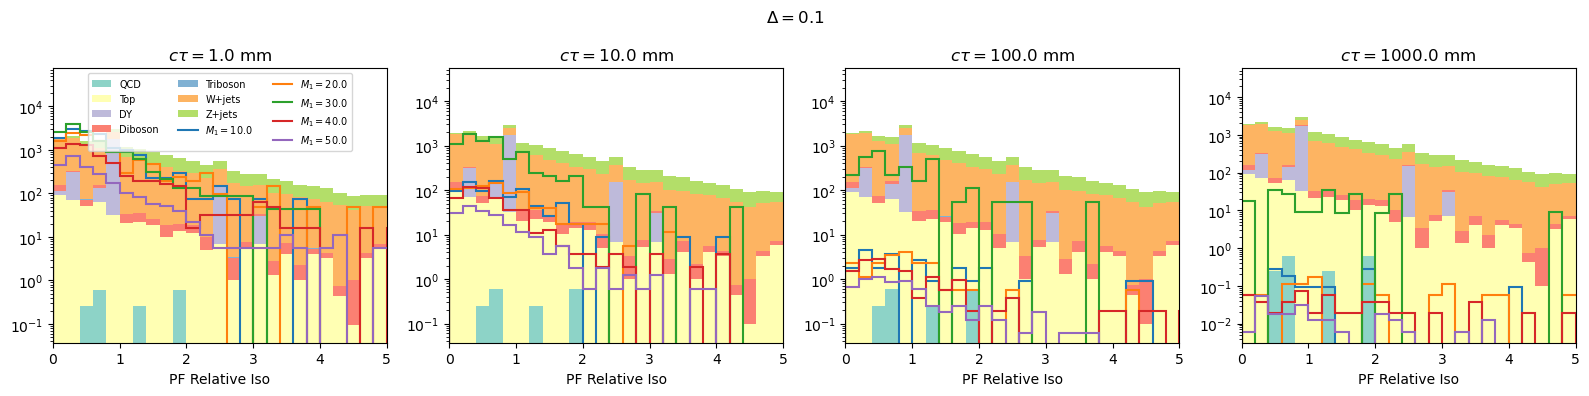

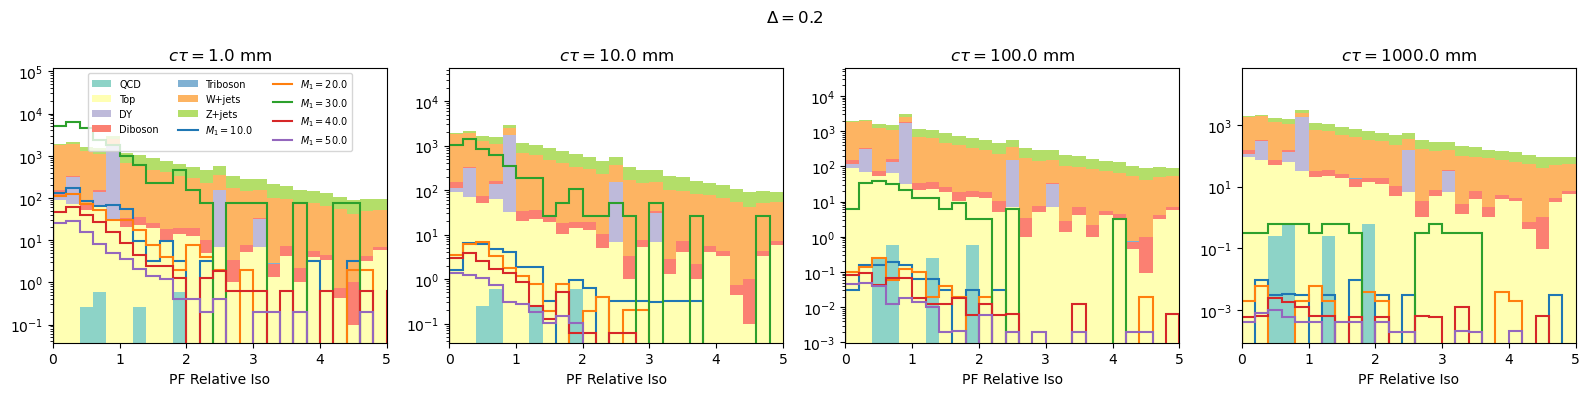

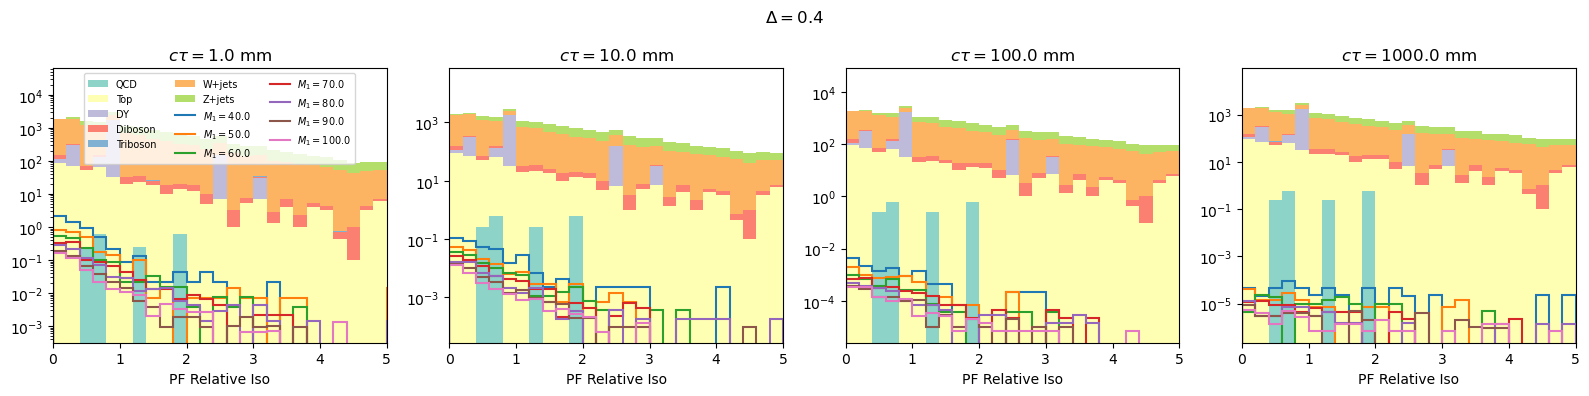

In [12]:
# vertex relative PF isolation dR < 0.3
plot("sel_vtx_PFRelIso3",[0,5],logy=True,rebin=2j,scaley=10)

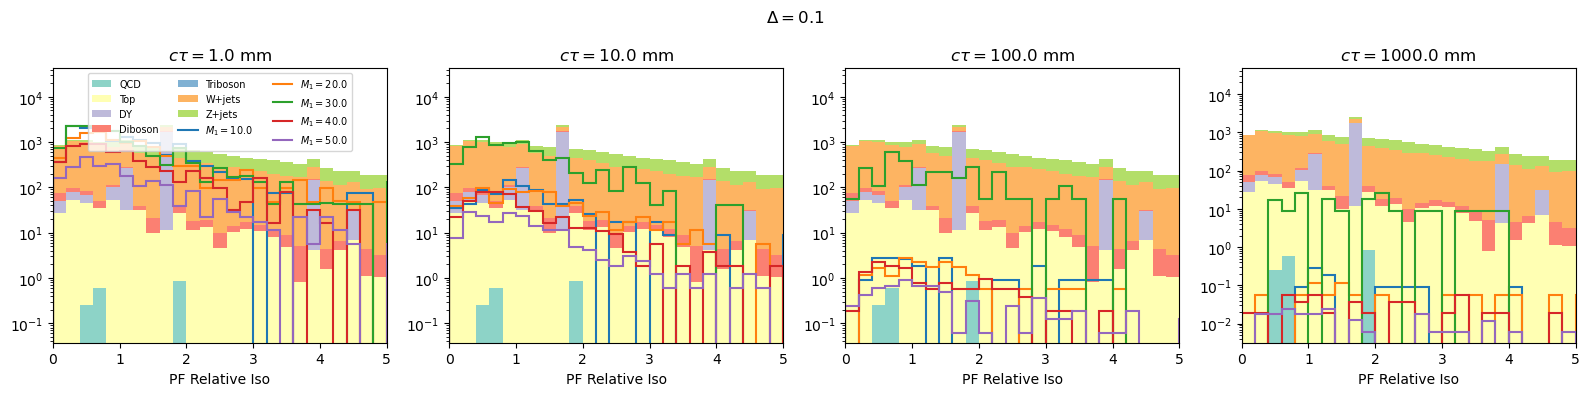

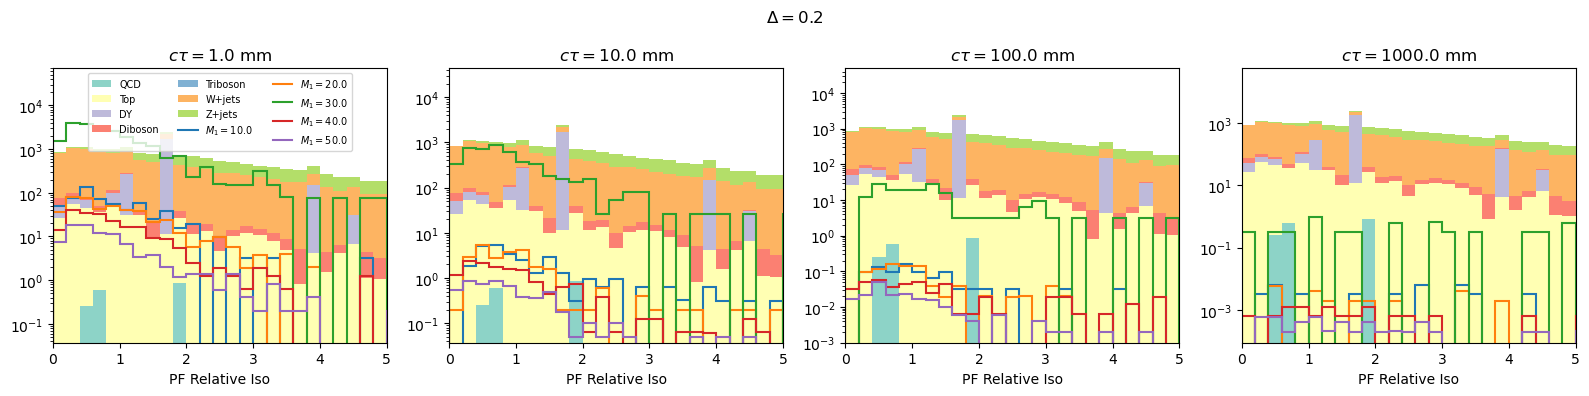

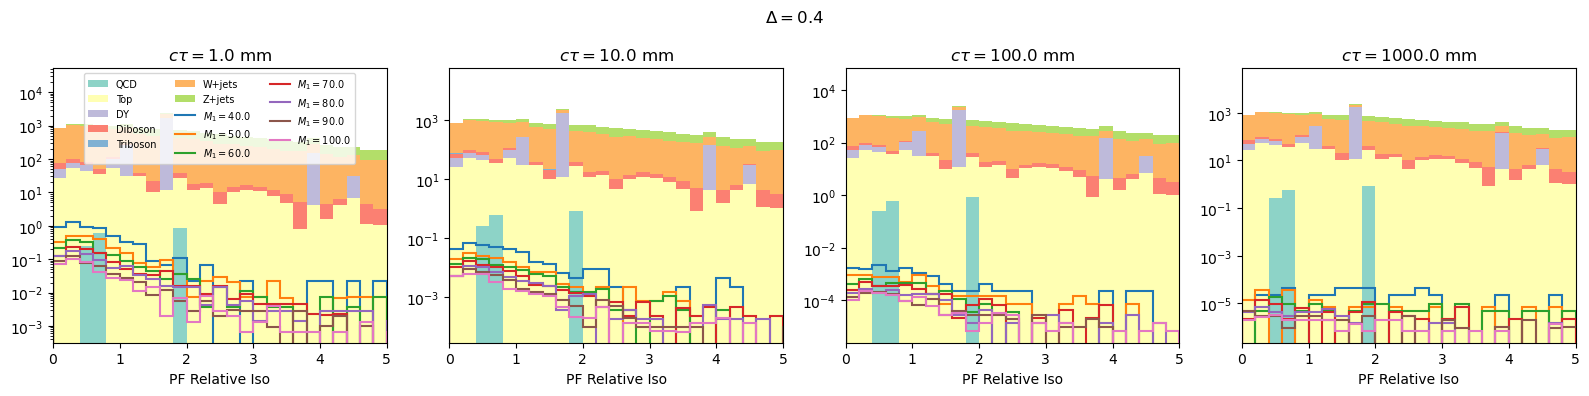

In [13]:
# vertex relative PF isolation dR < 0.4
plot("sel_vtx_PFRelIso4",[0,5],logy=True,rebin=2j,scaley=10)

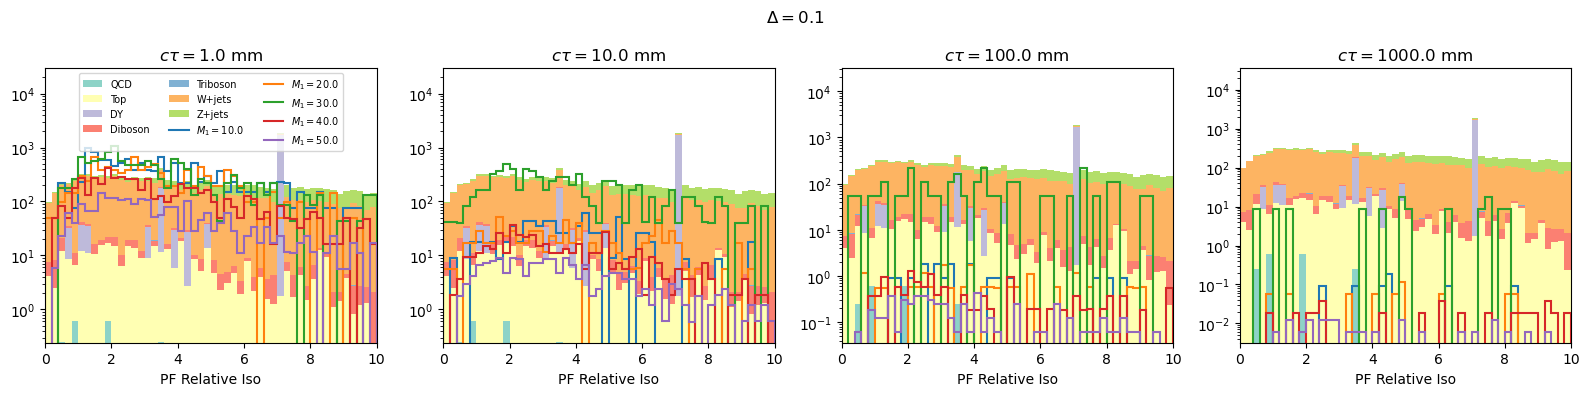

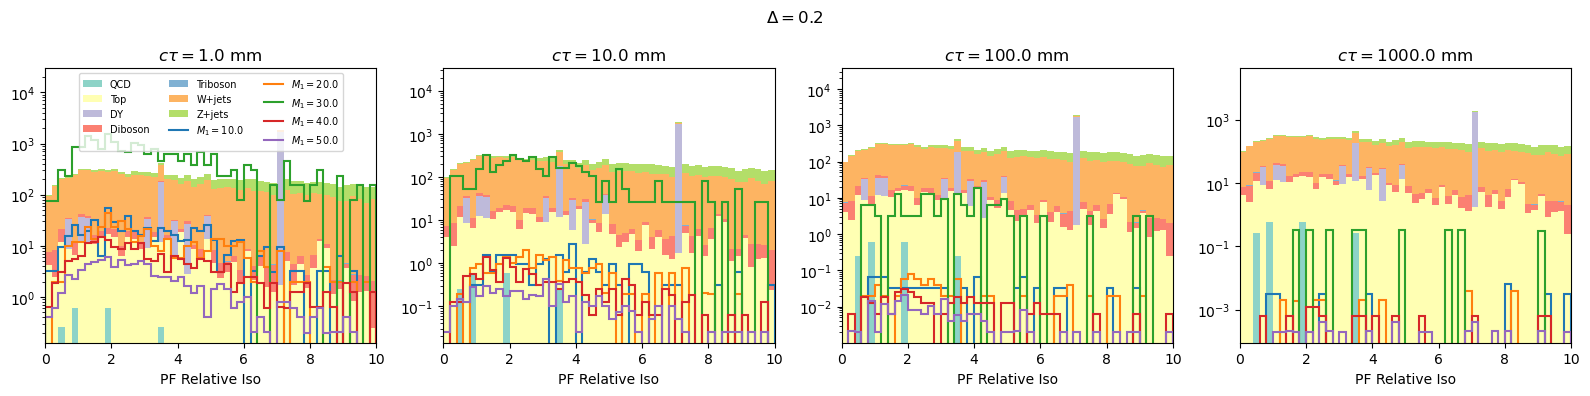

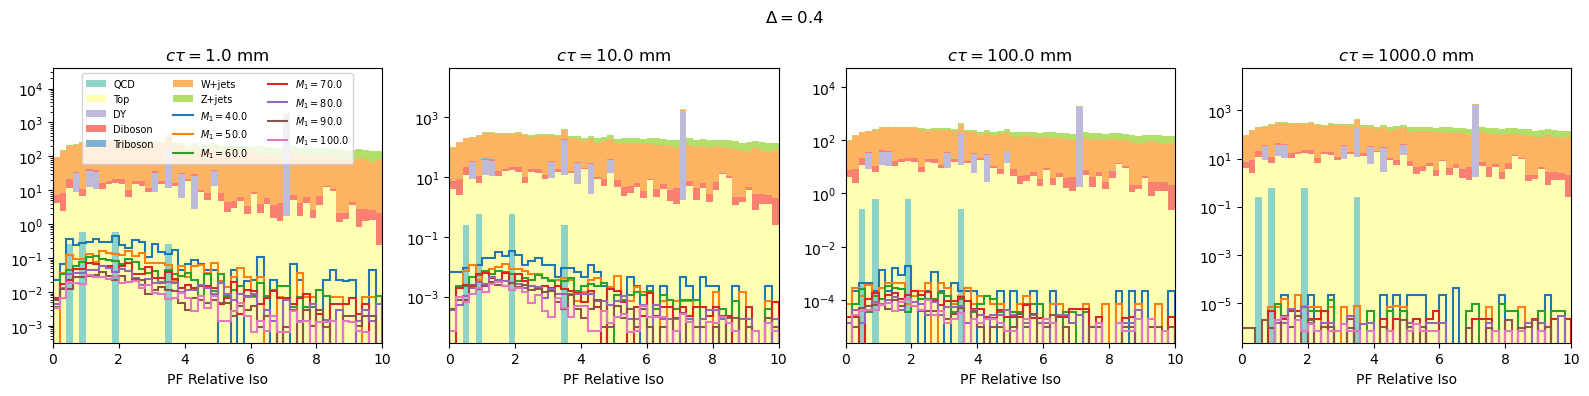

In [14]:
# vertex relative PF isolation dR < 0.8
plot("sel_vtx_PFRelIso8",[0,10],logy=True,rebin=2j,scaley=10)

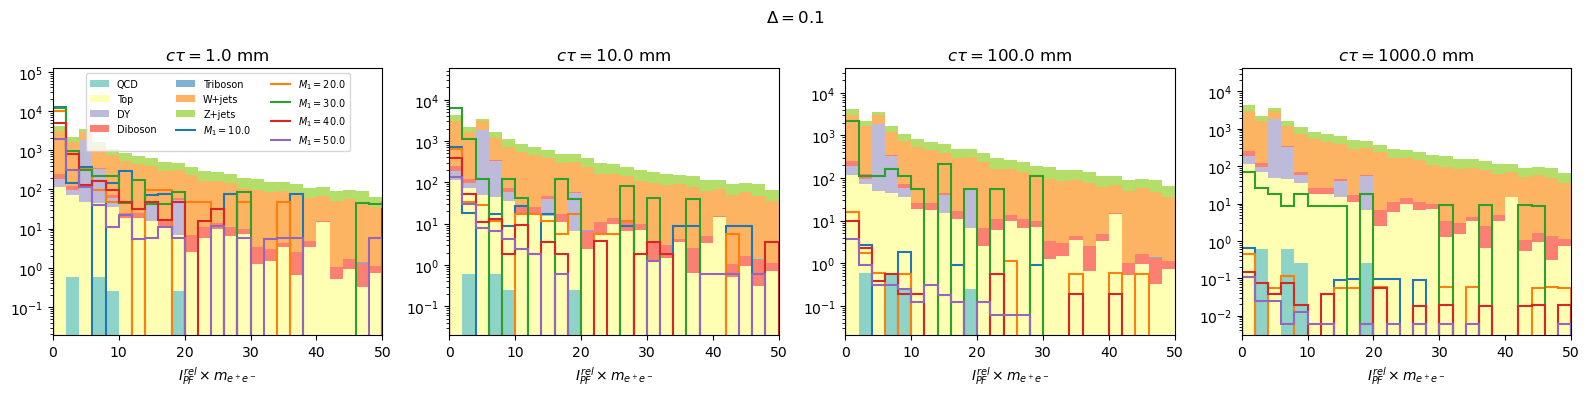

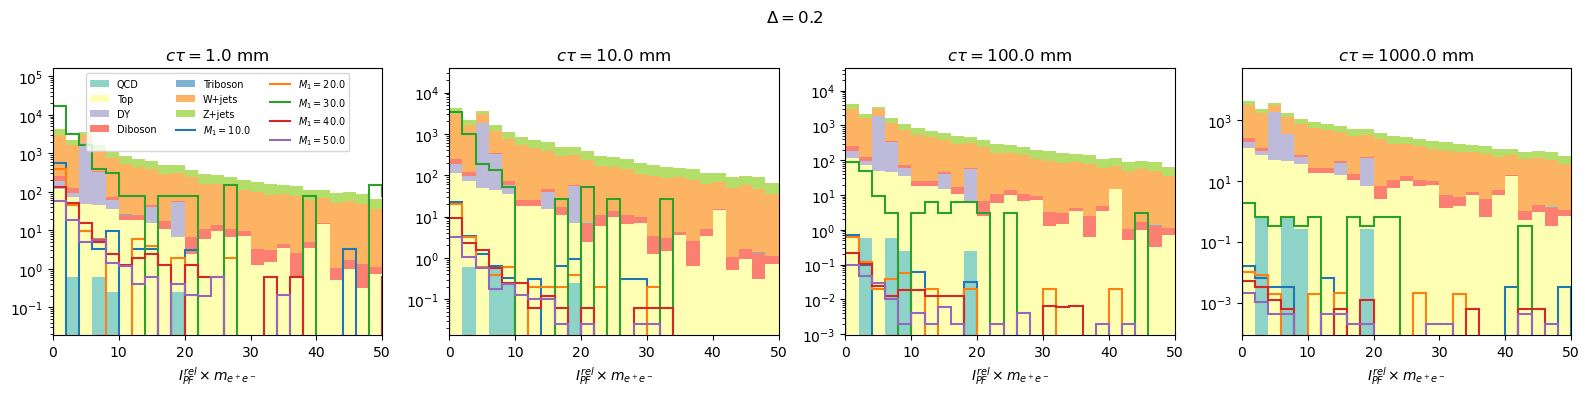

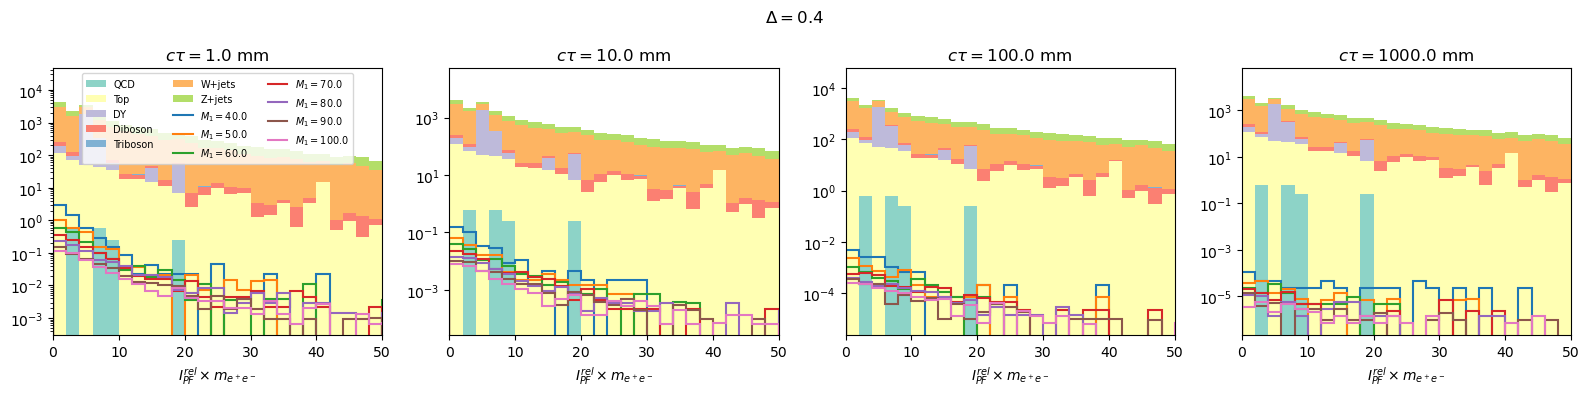

In [15]:
# vertex relative PF isolation*mass, dR < 0.3
plot("sel_vtx_PFRelIso3M",[0,50],logy=True,rebin=1j)

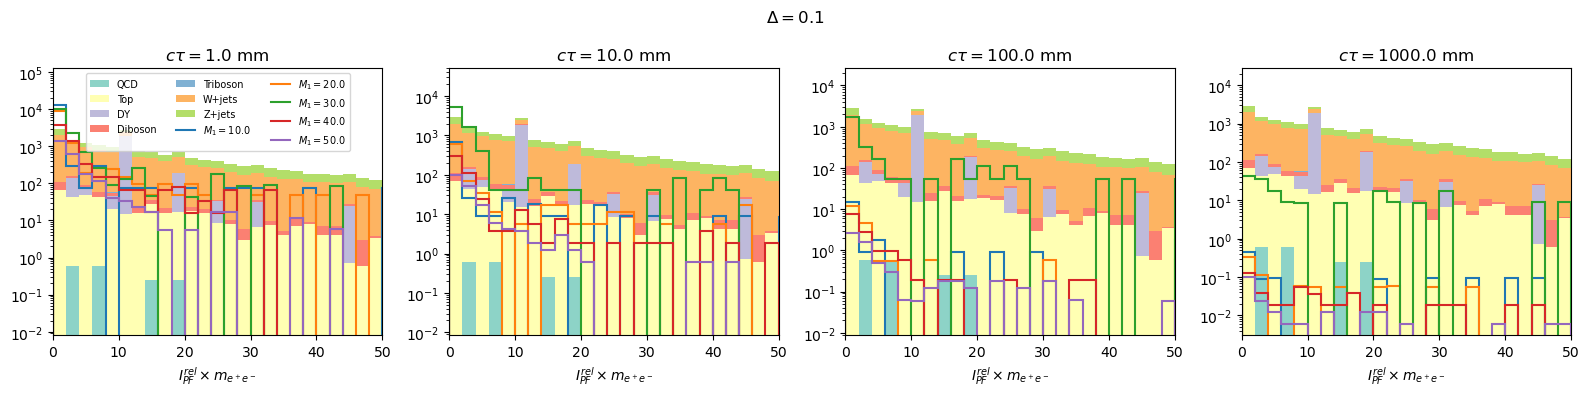

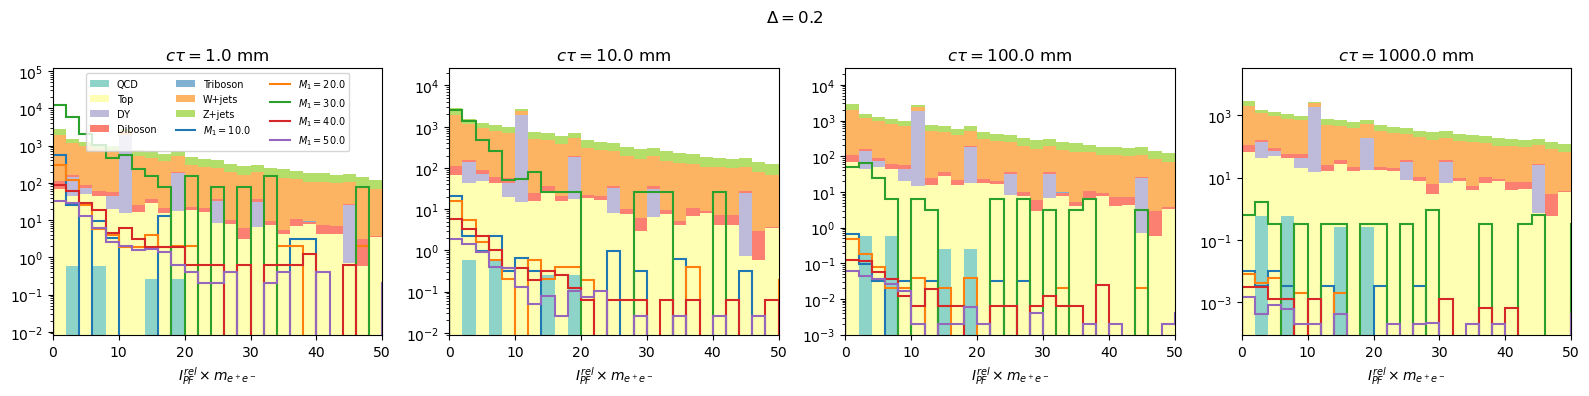

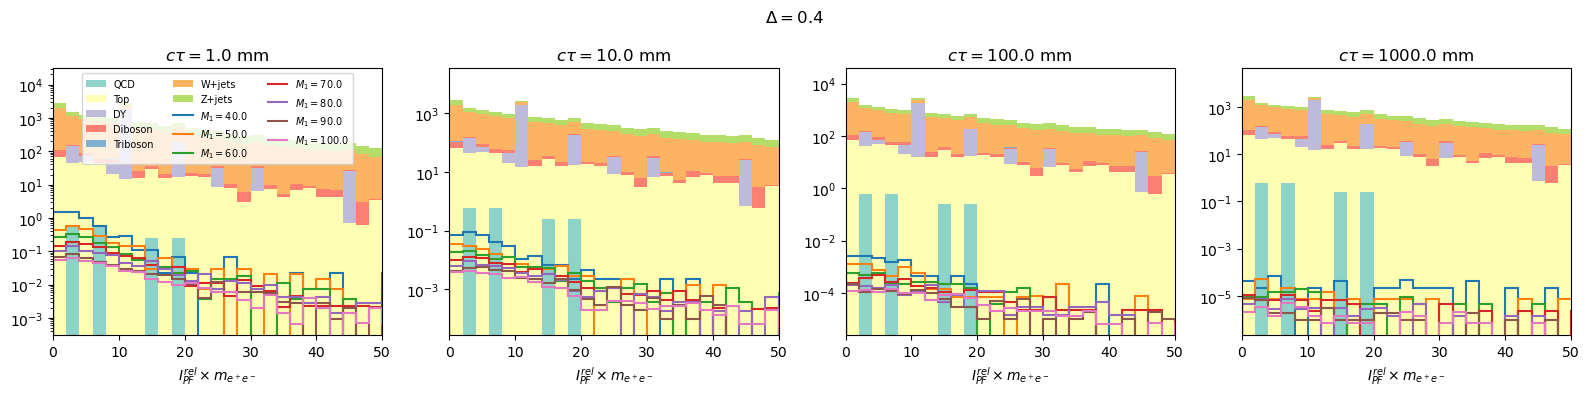

In [16]:
# vertex relative PF isolation*mass, dR < 0.4
plot("sel_vtx_PFRelIso4M",[0,50],logy=True,rebin=1j)

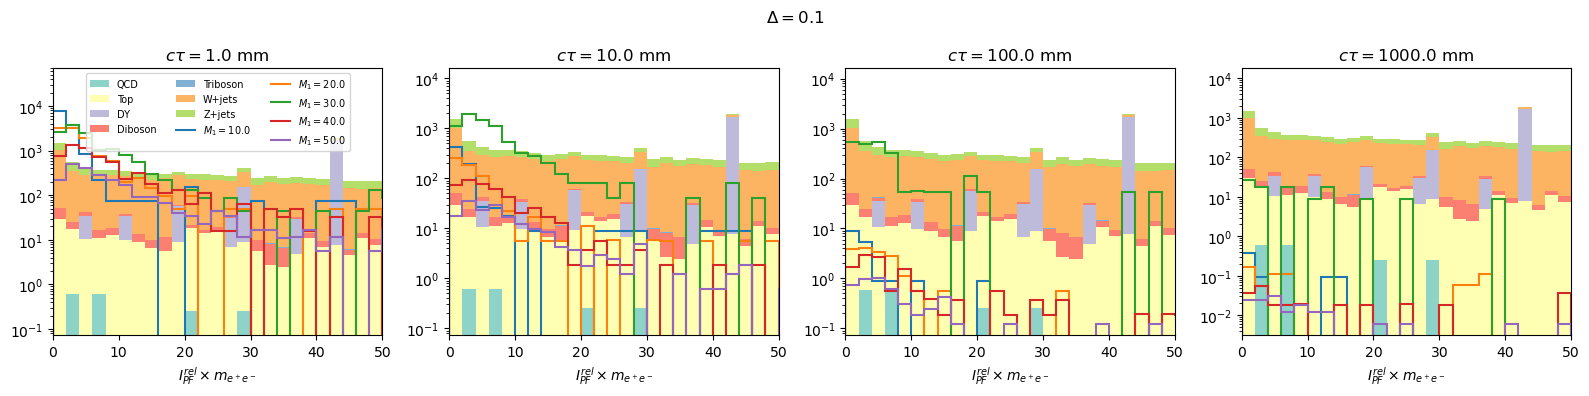

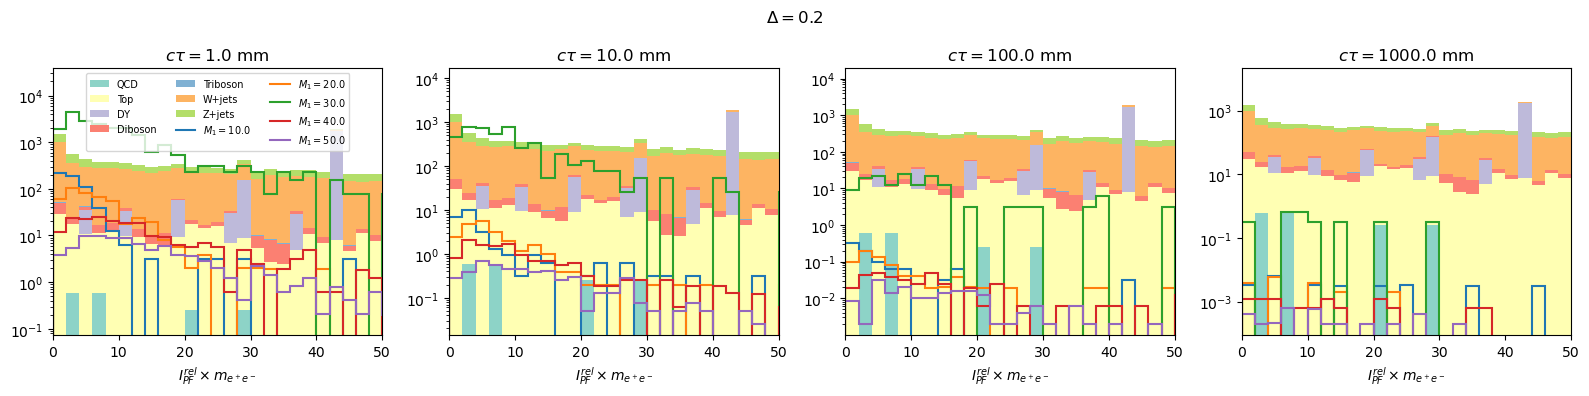

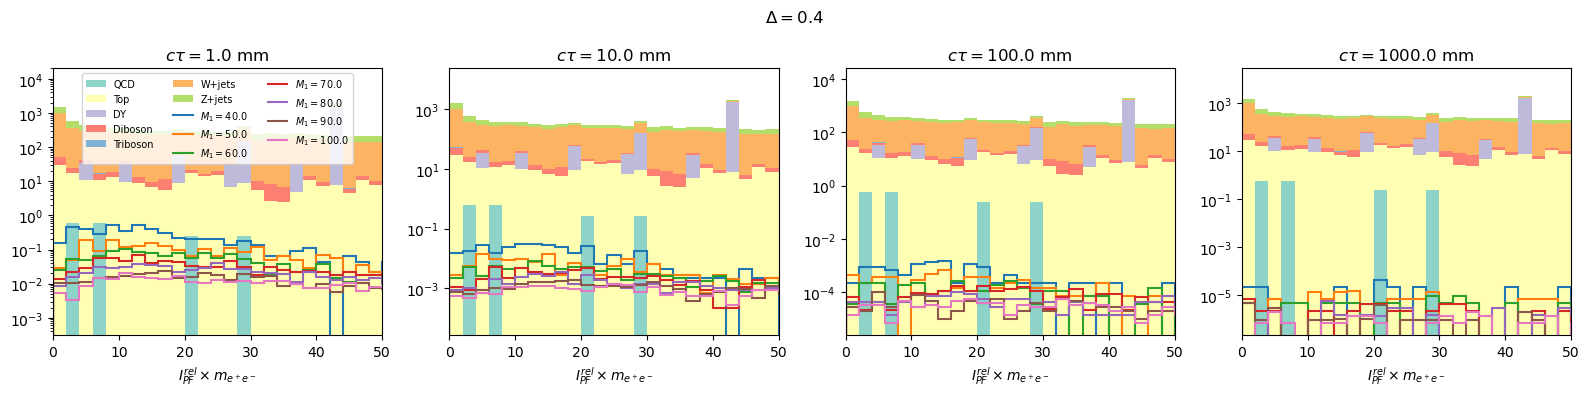

In [17]:
# vertex relative PF isolation*mass, dR < 0.8
plot("sel_vtx_PFRelIso8M",[0,50],logy=True,rebin=1j)

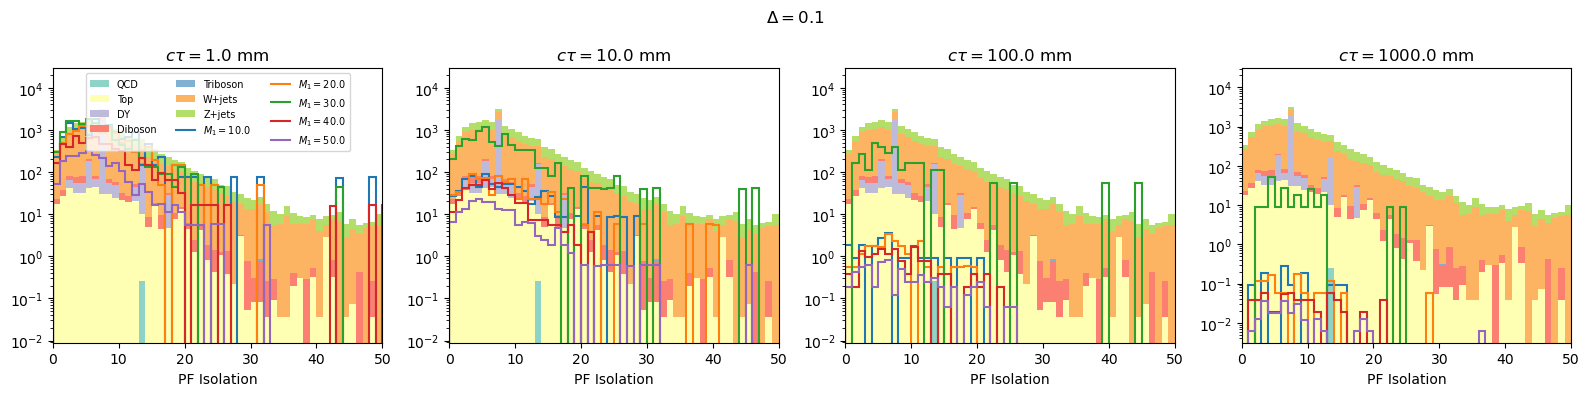

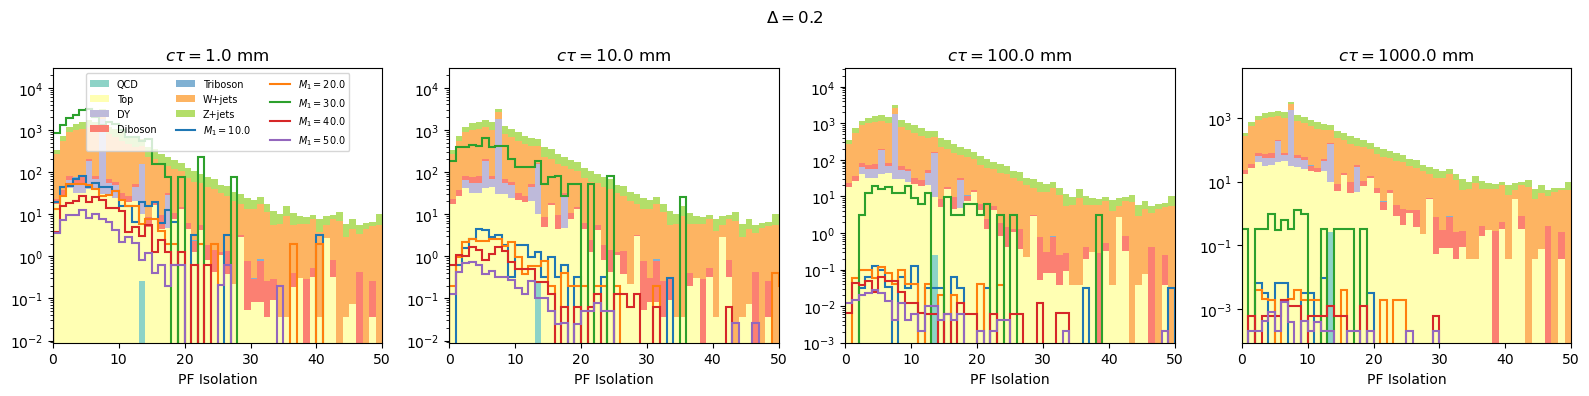

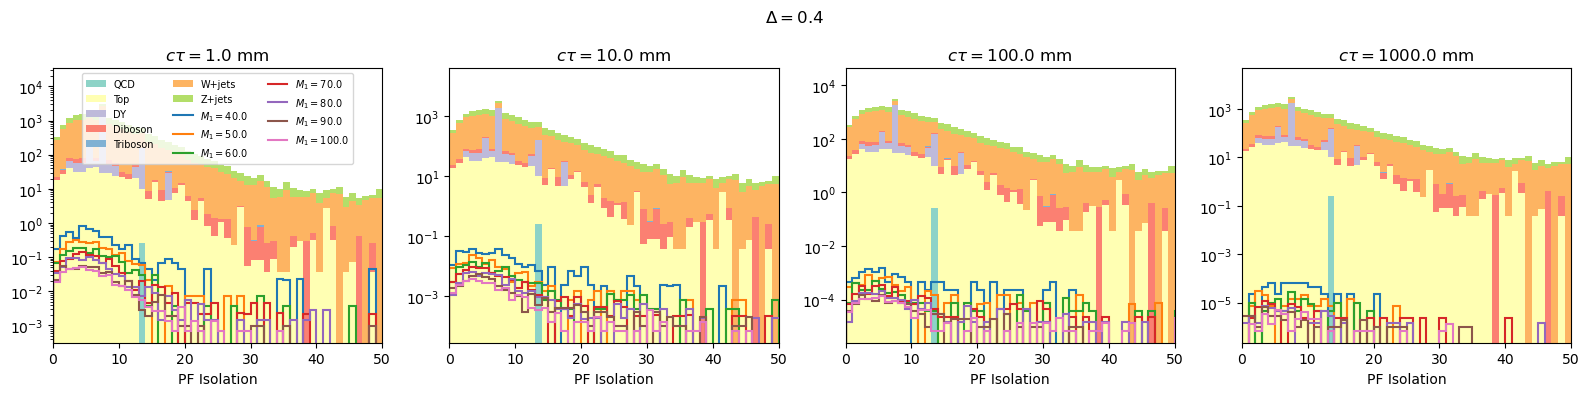

In [18]:
# vertex PF isolation dR < 0.3
plot("sel_vtx_PFIso3",[0,50],logy=True,rebin=1j)

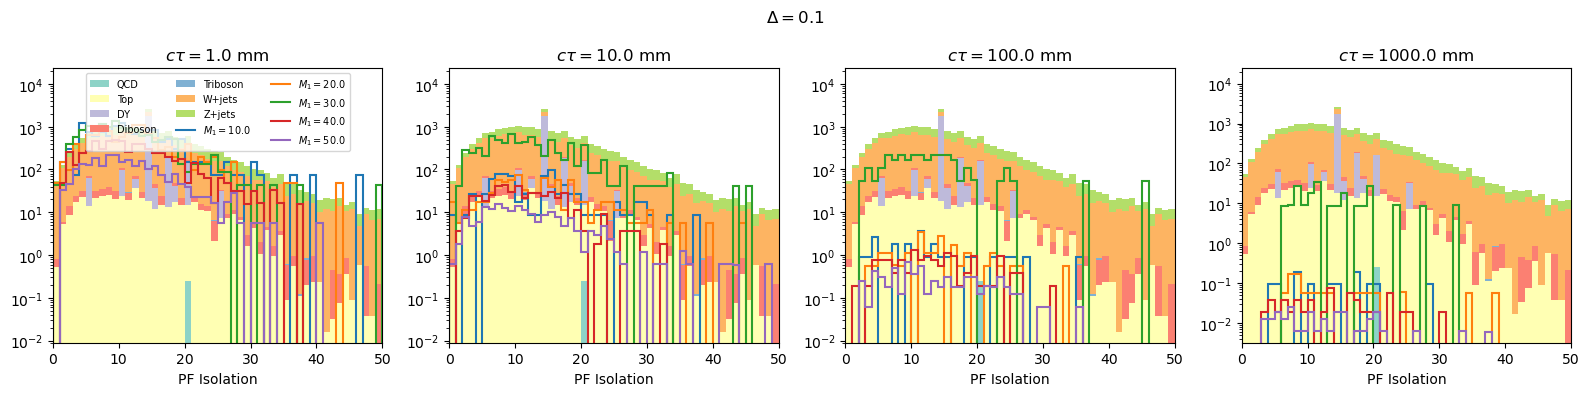

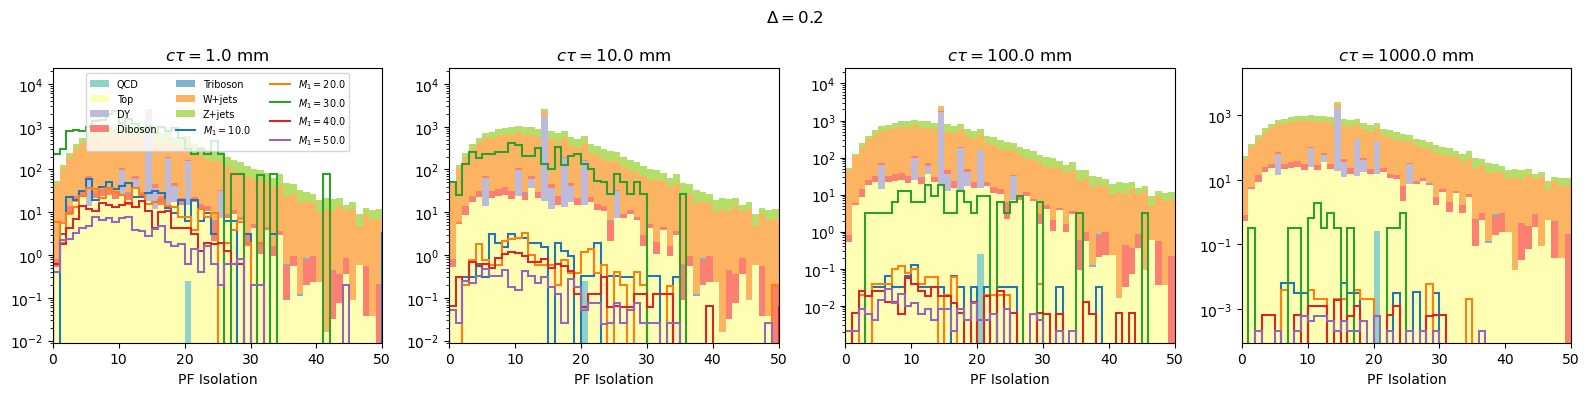

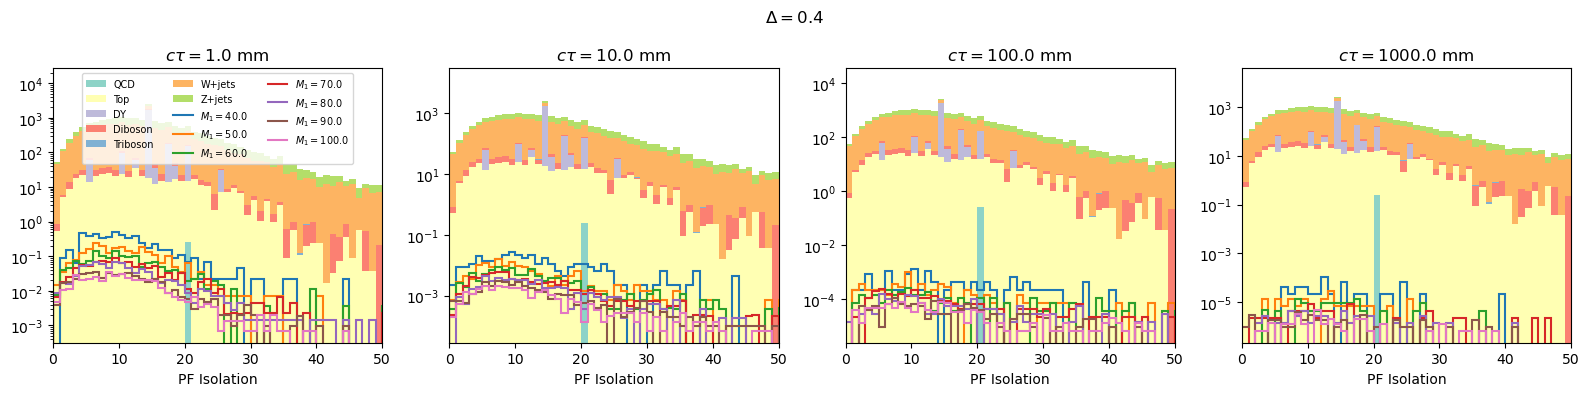

In [19]:
# vertex PF isolation dR < 0.4
plot("sel_vtx_PFIso4",[0,50],logy=True,rebin=1j)

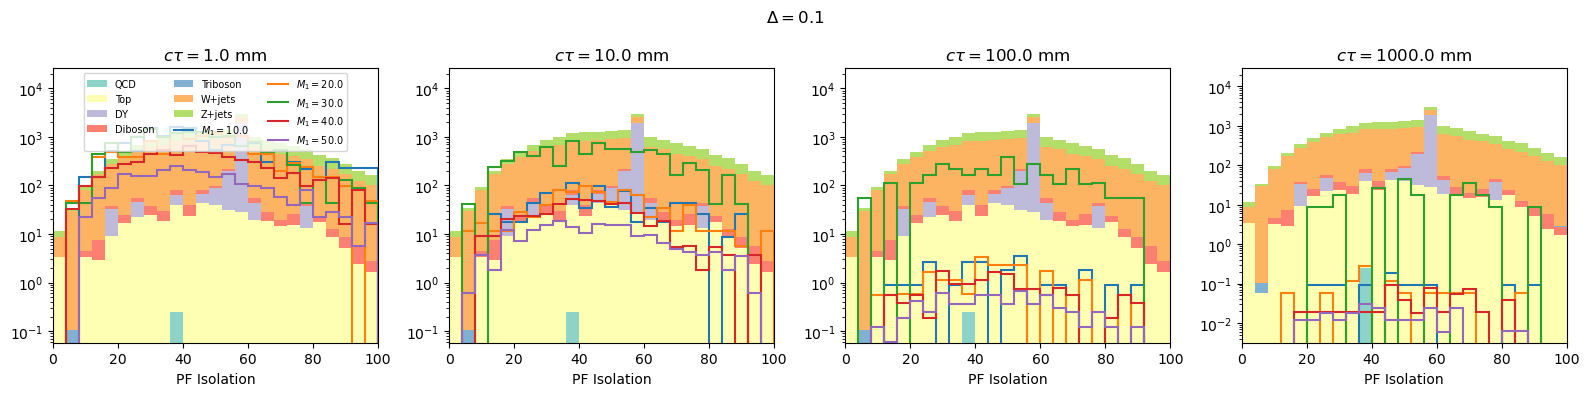

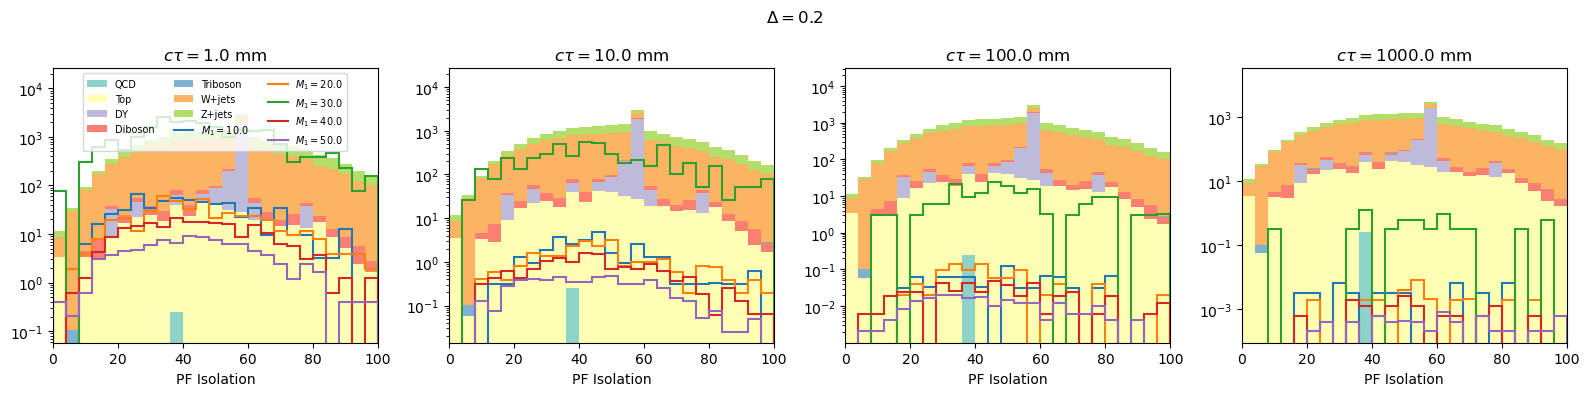

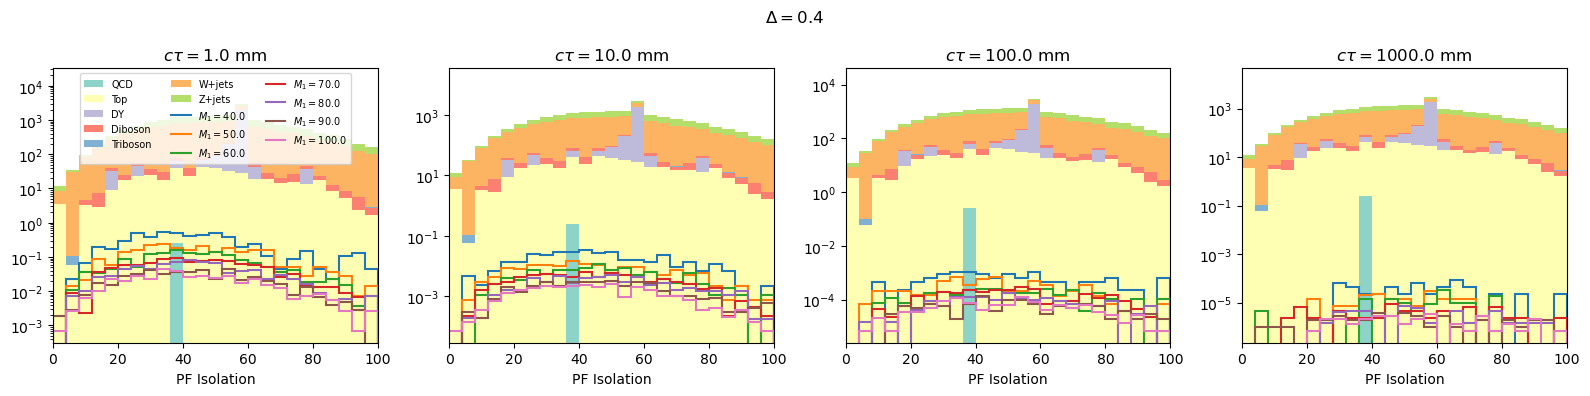

In [20]:
# vertex PF isolation dR < 0.8
plot("sel_vtx_PFIso8",[0,100],logy=True,rebin=4j)

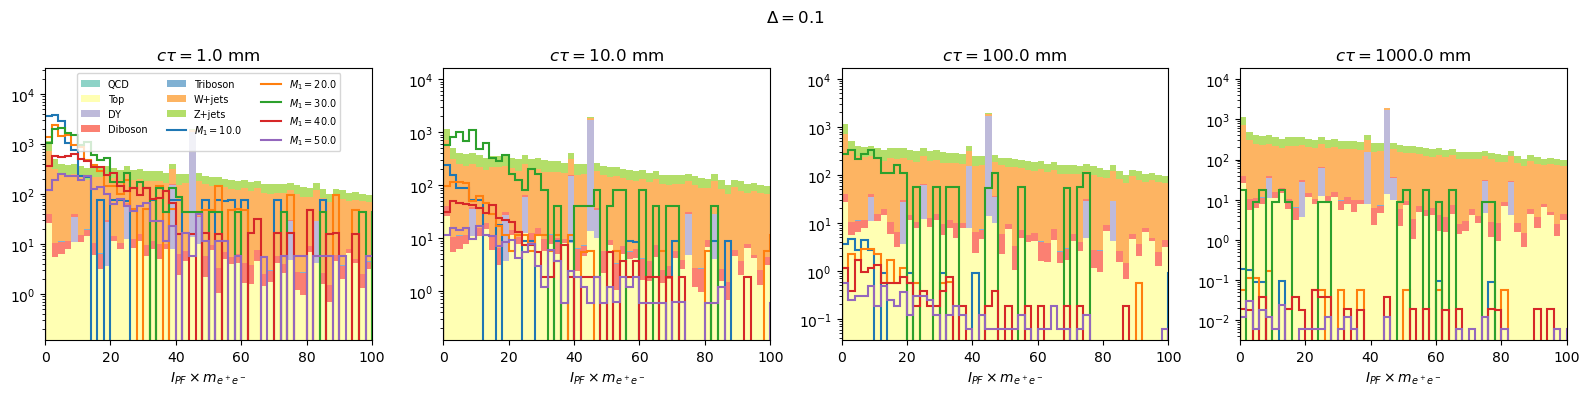

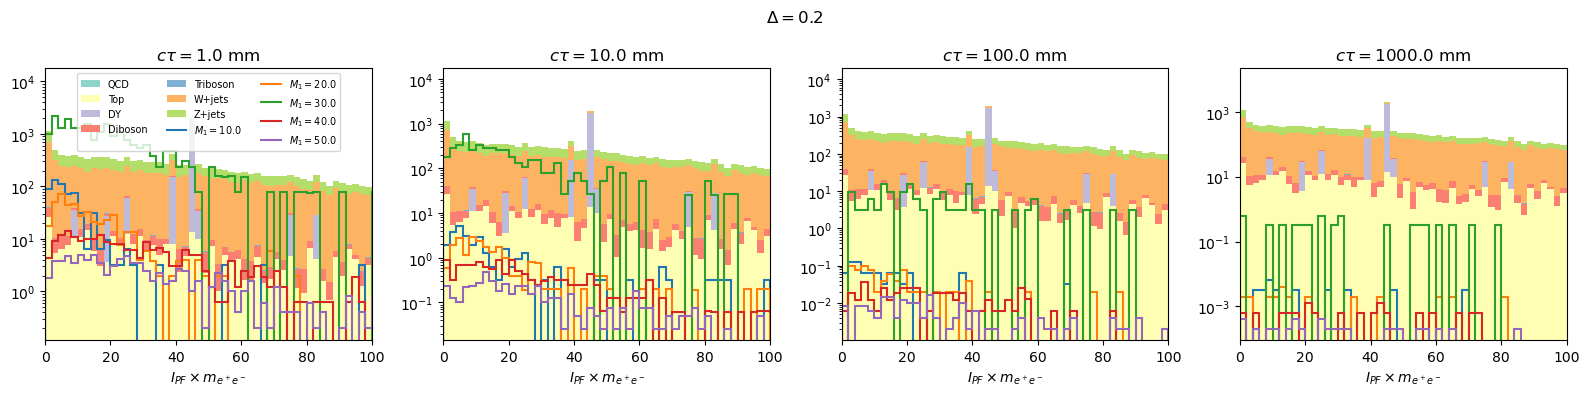

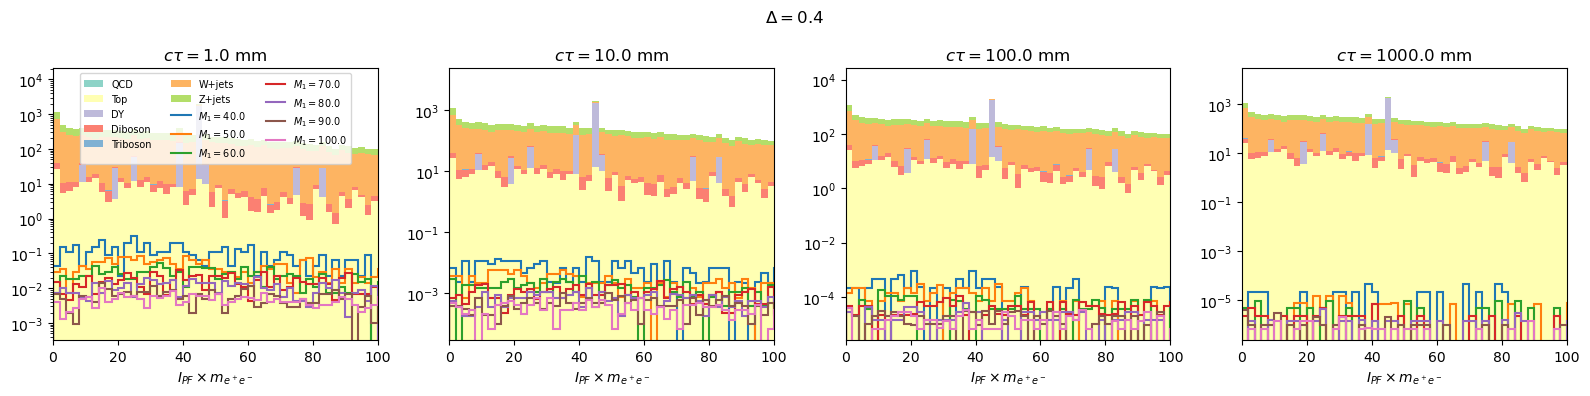

In [21]:
# vertex PF isolation * mass, dR < 0.3
plot("sel_vtx_PFIso3M",[0,100],logy=True,rebin=1j)

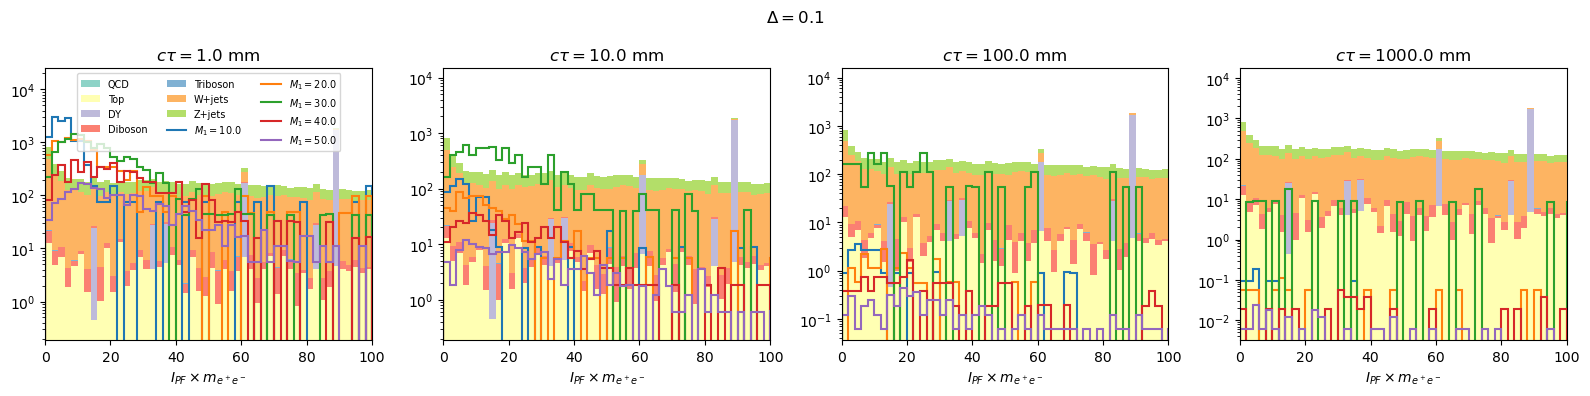

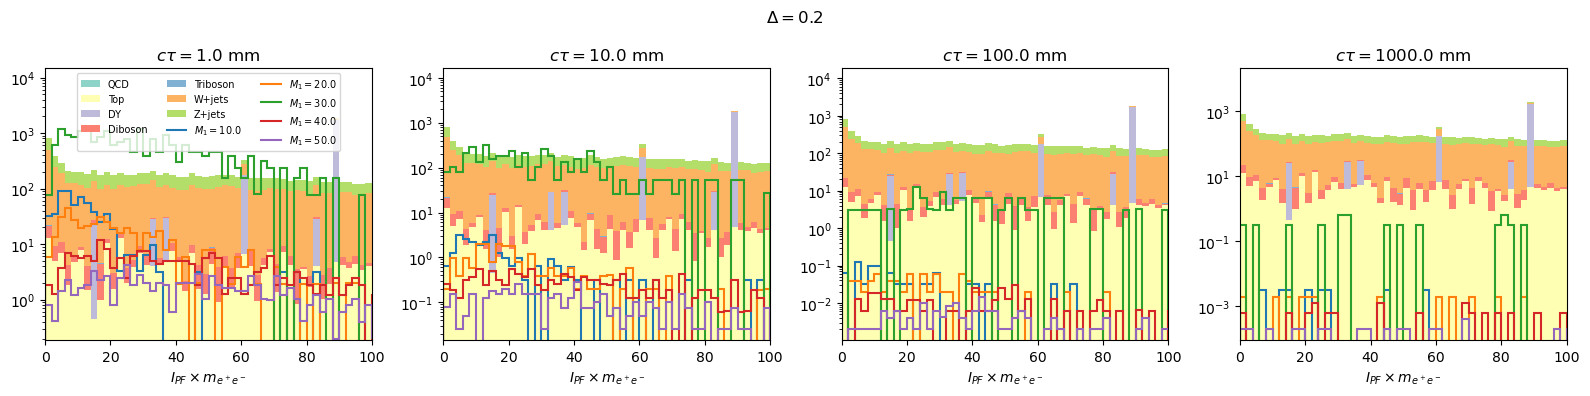

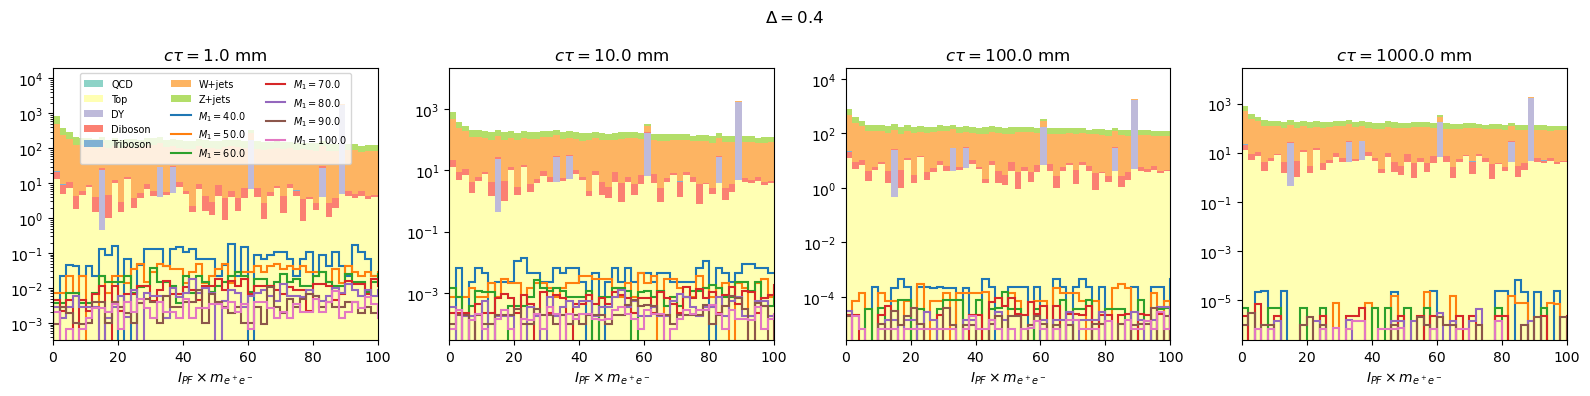

In [22]:
# vertex PF isolation * mass, dR < 0.4
plot("sel_vtx_PFIso4M",[0,100],logy=True,rebin=1j)

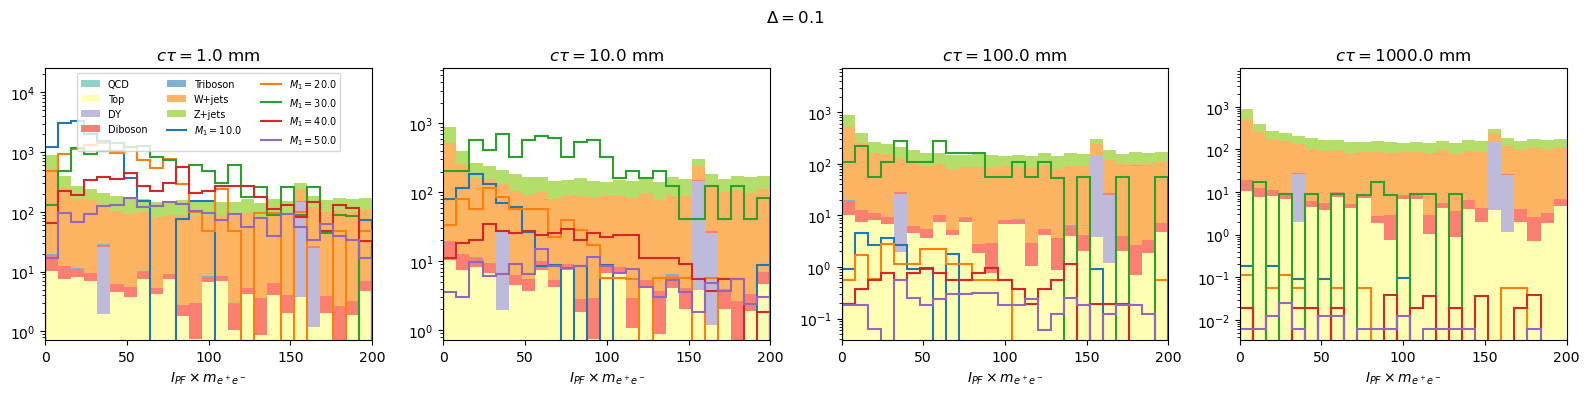

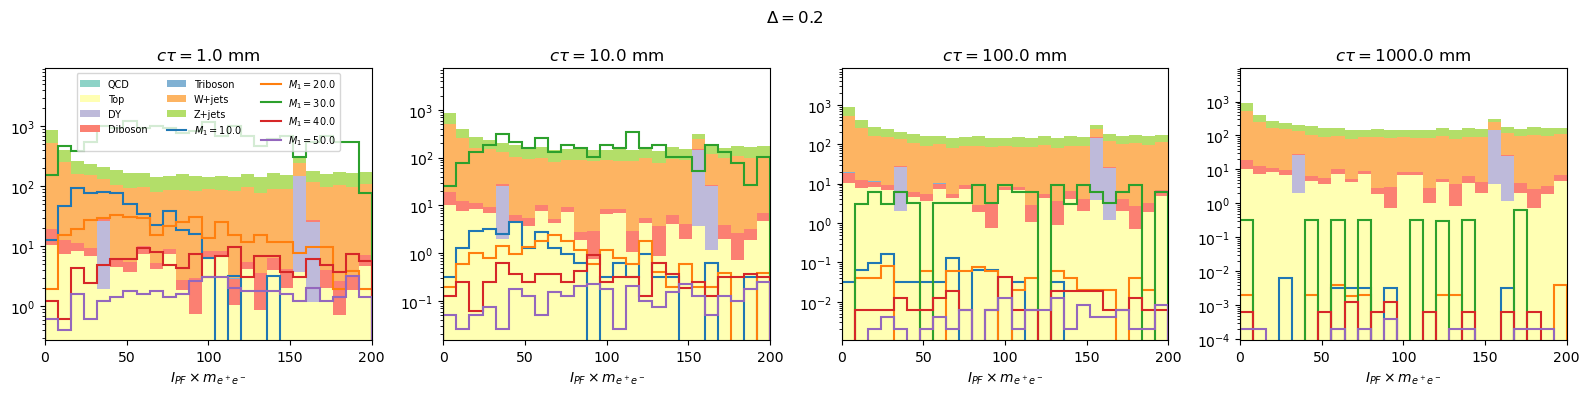

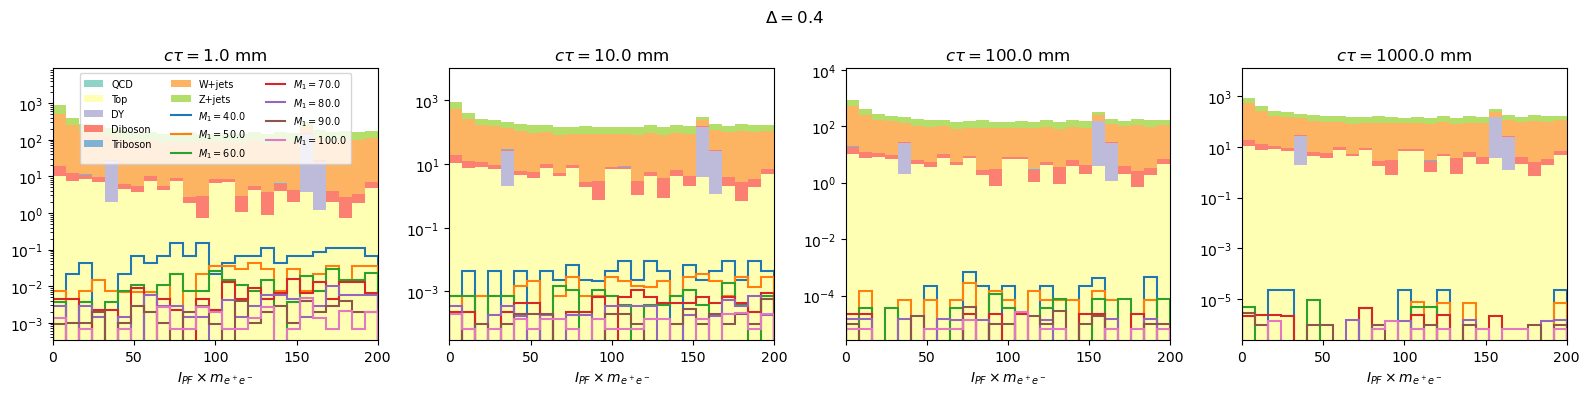

In [23]:
# vertex PF isolation * mass, dR < 0.8
plot("sel_vtx_PFIso8M",[0,200],logy=True,rebin=4j)

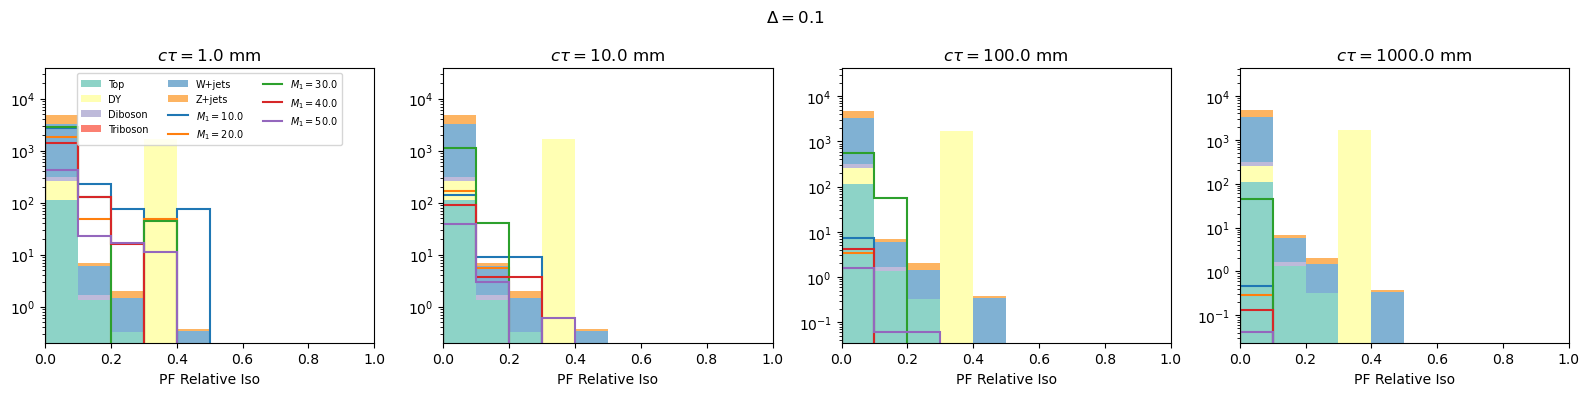

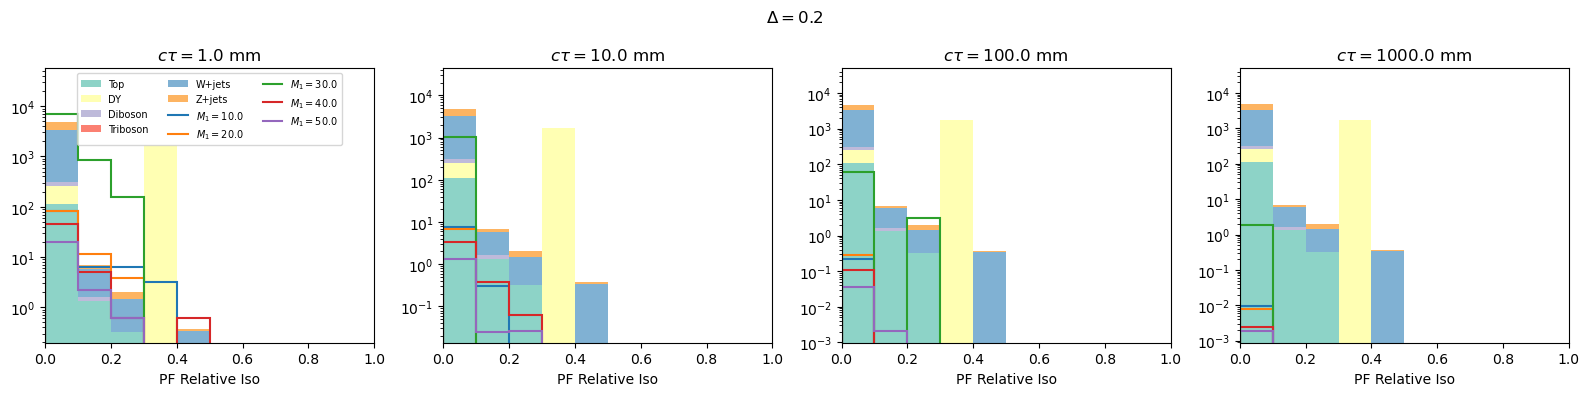

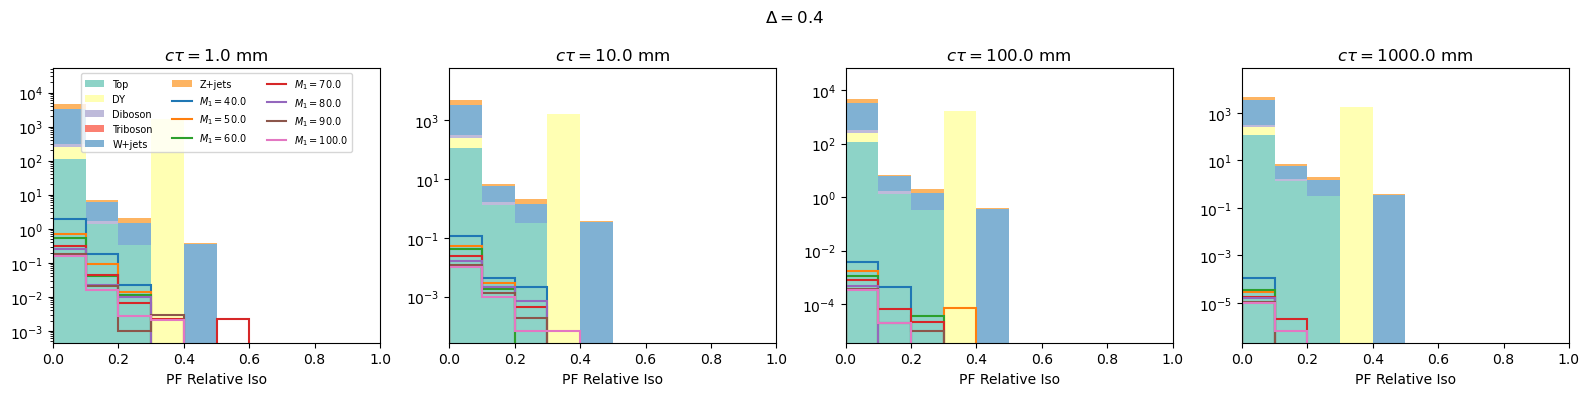

In [29]:
# vertex min PF isolation, using official PFIso for the electrons
plot("sel_vtx_minPFIso",[0,1],logy=True,rebin=1j)

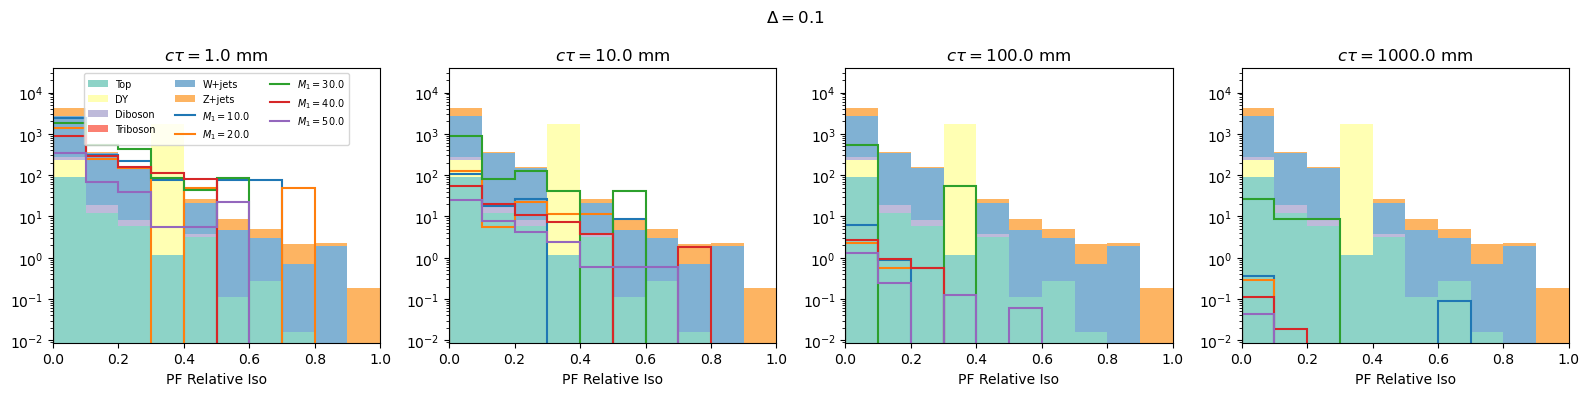

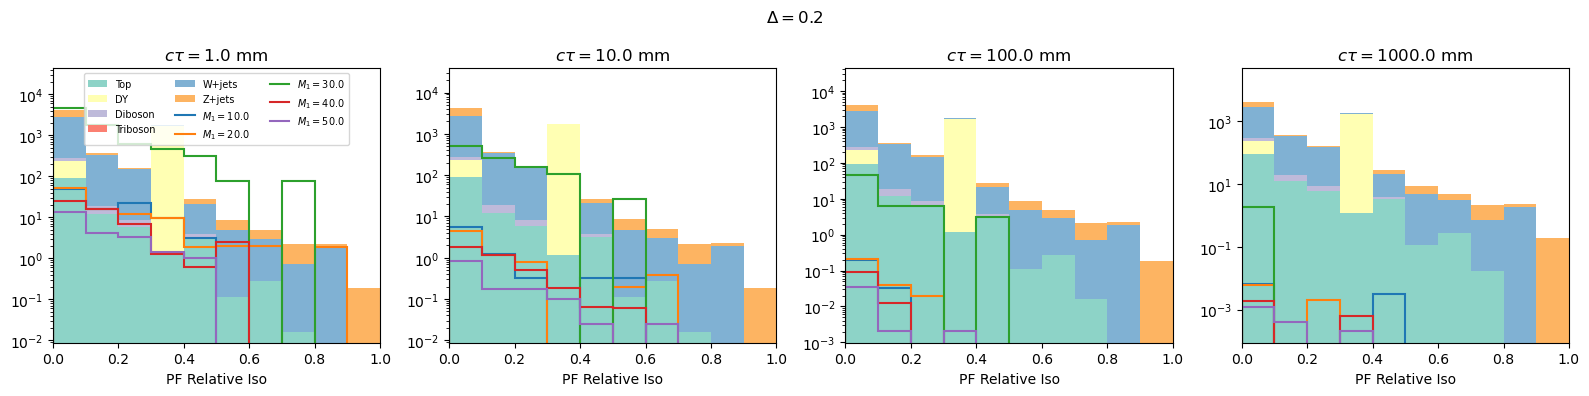

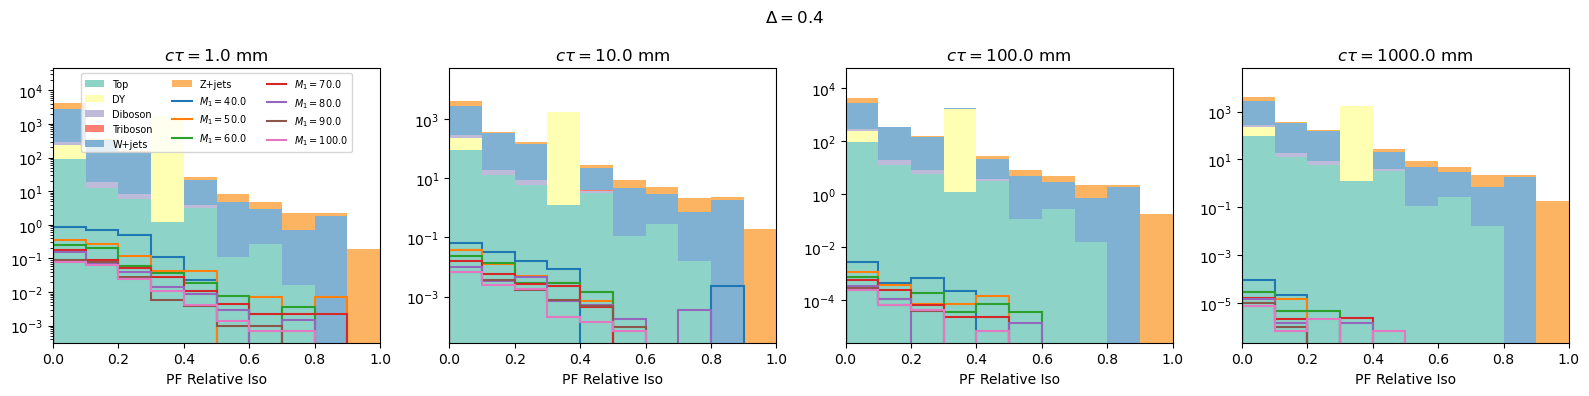

In [30]:
# vertex max PF isolation, using official PFIso for the electrons
plot("sel_vtx_maxPFIso",[0,1],logy=True,rebin=1j)

# Electron Quality

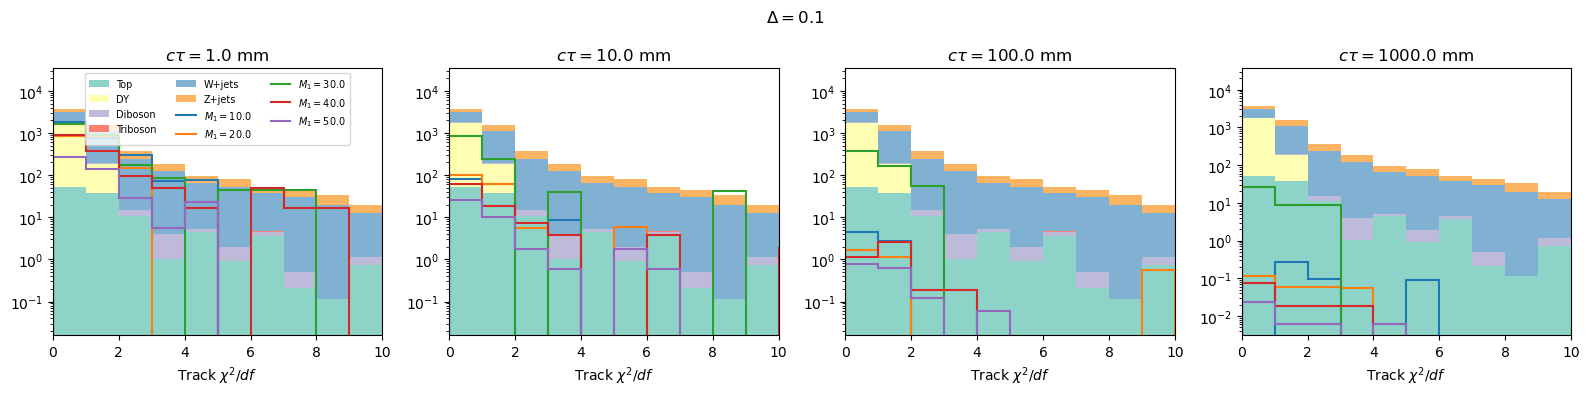

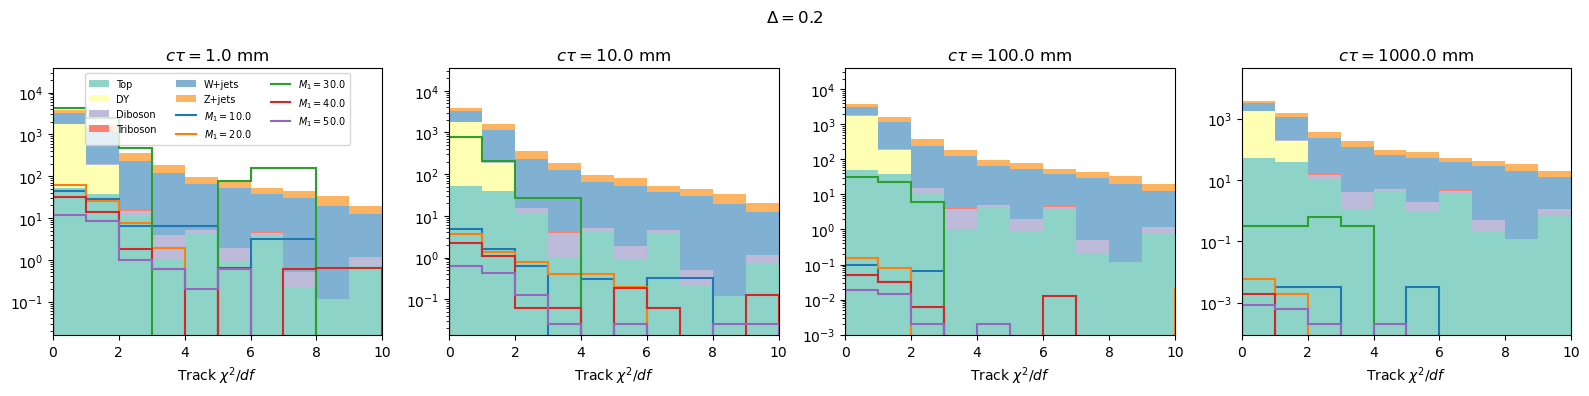

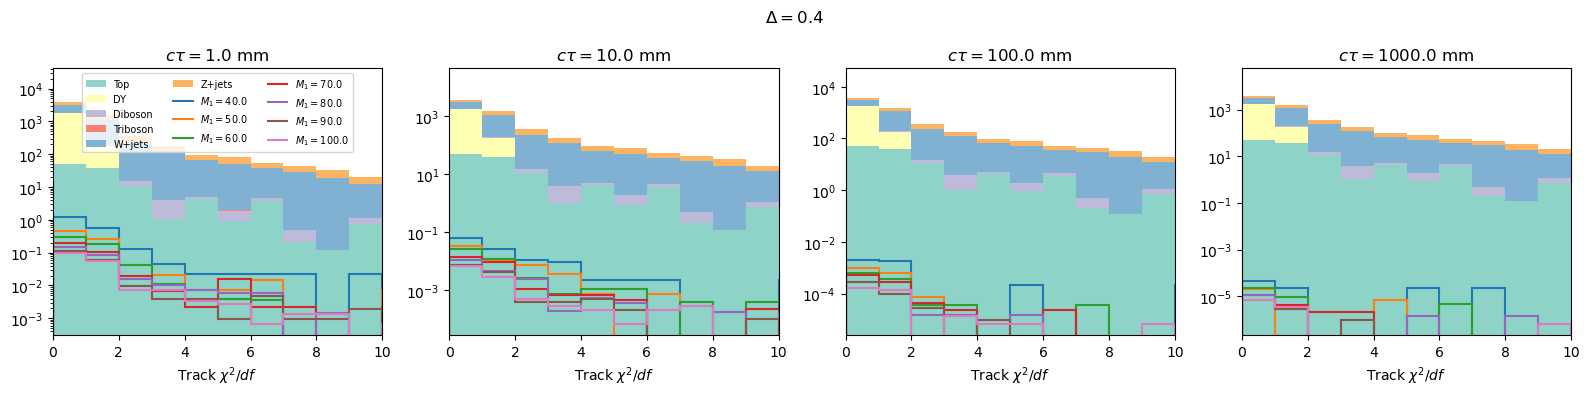

In [31]:
# electron 1 track chi2
plot("sel_e1_trkChi2",[0,10],logy=True,rebin=2j)

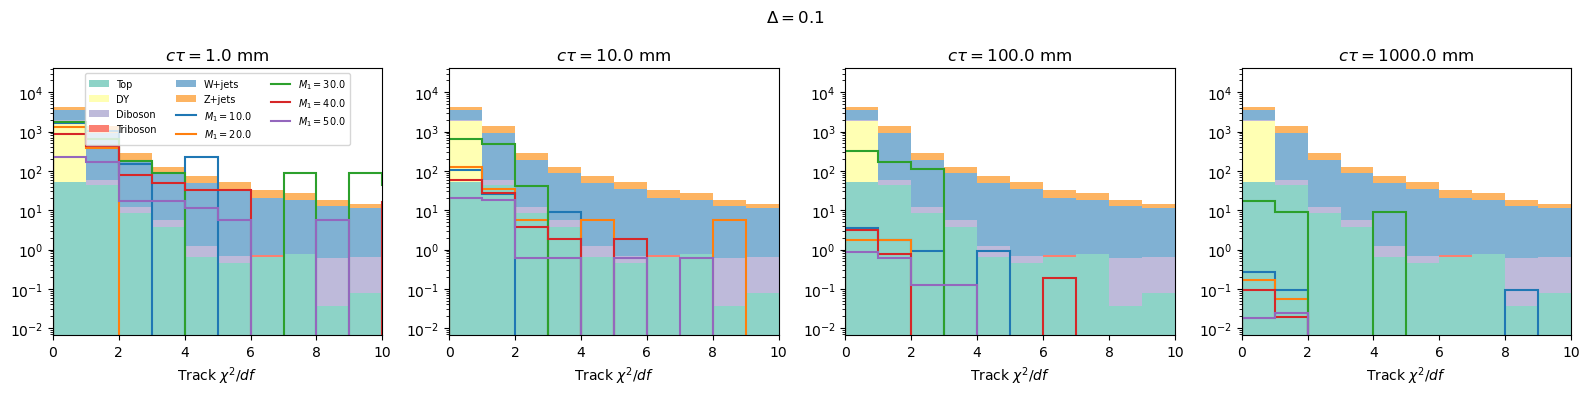

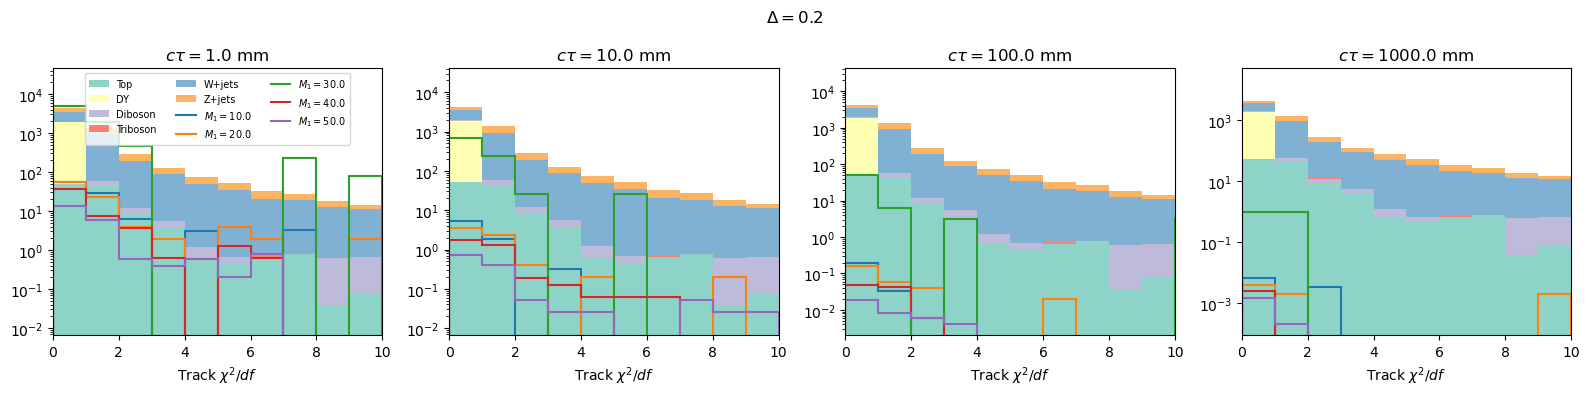

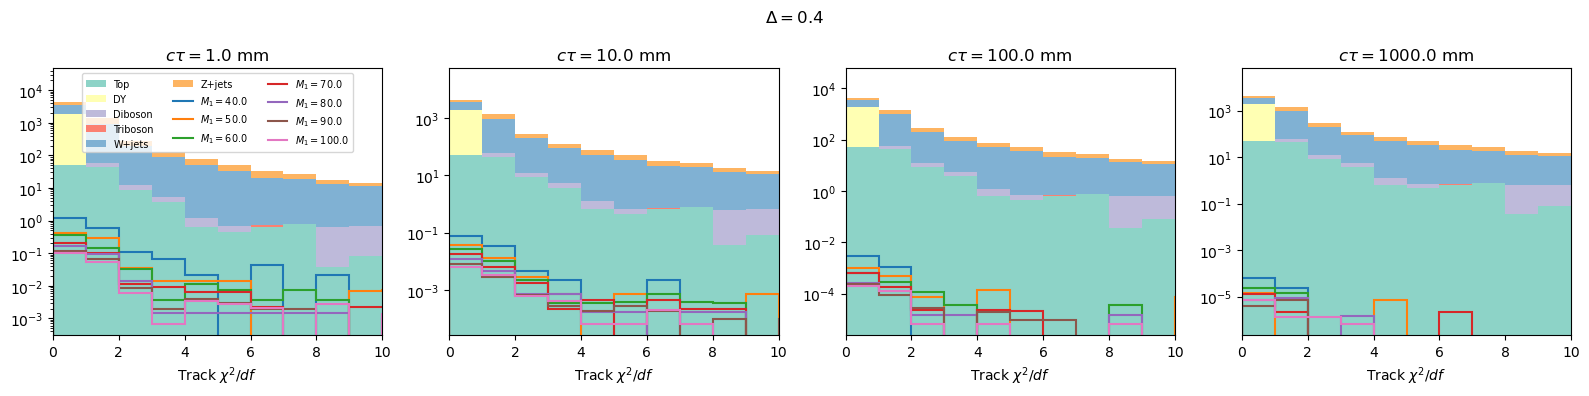

In [32]:
# electron 2 track chi2
plot("sel_e2_trkChi2",[0,10],logy=True,rebin=2j)

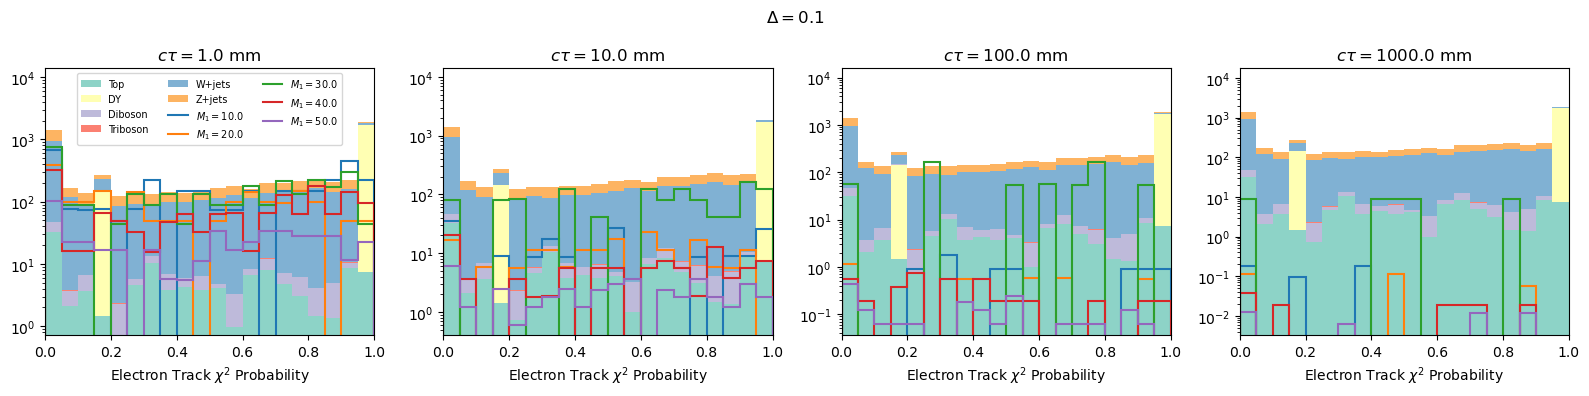

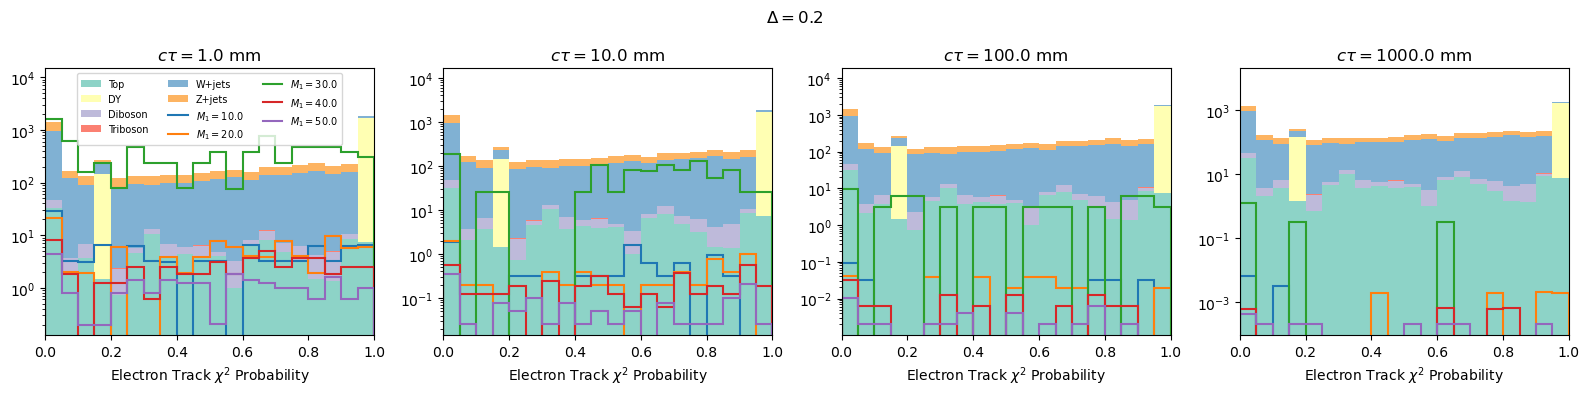

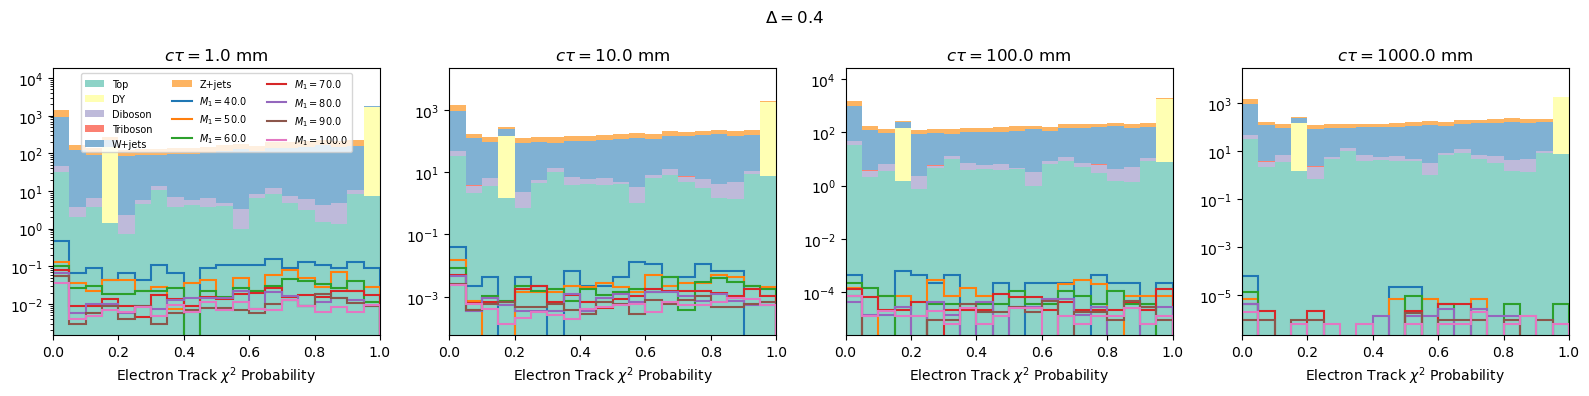

In [33]:
# electron 1 track probability
plot("sel_e1_trkProb",[0,1],logy=True,rebin=5j)

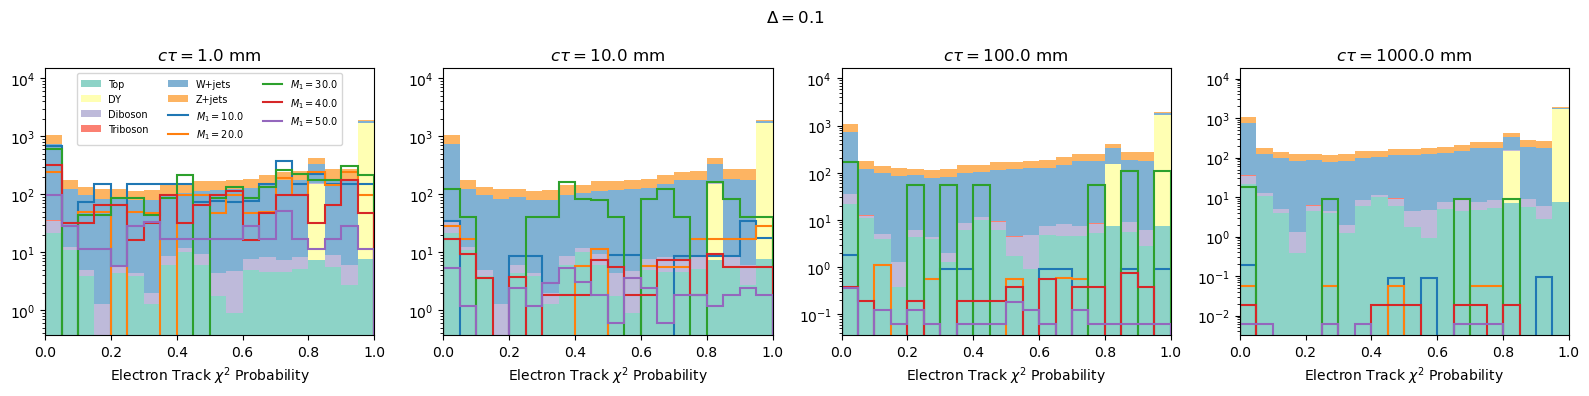

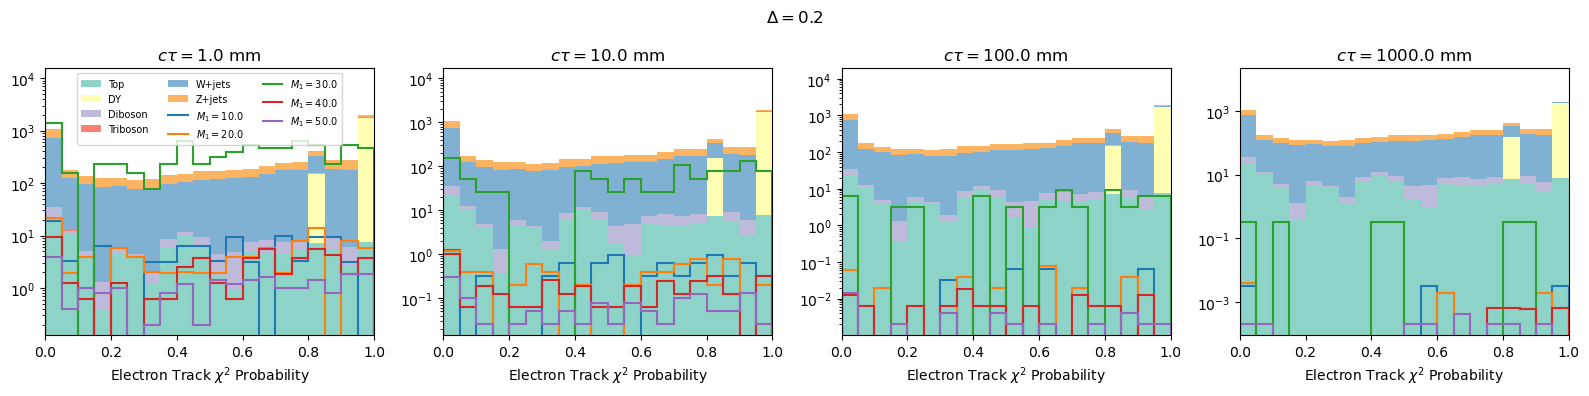

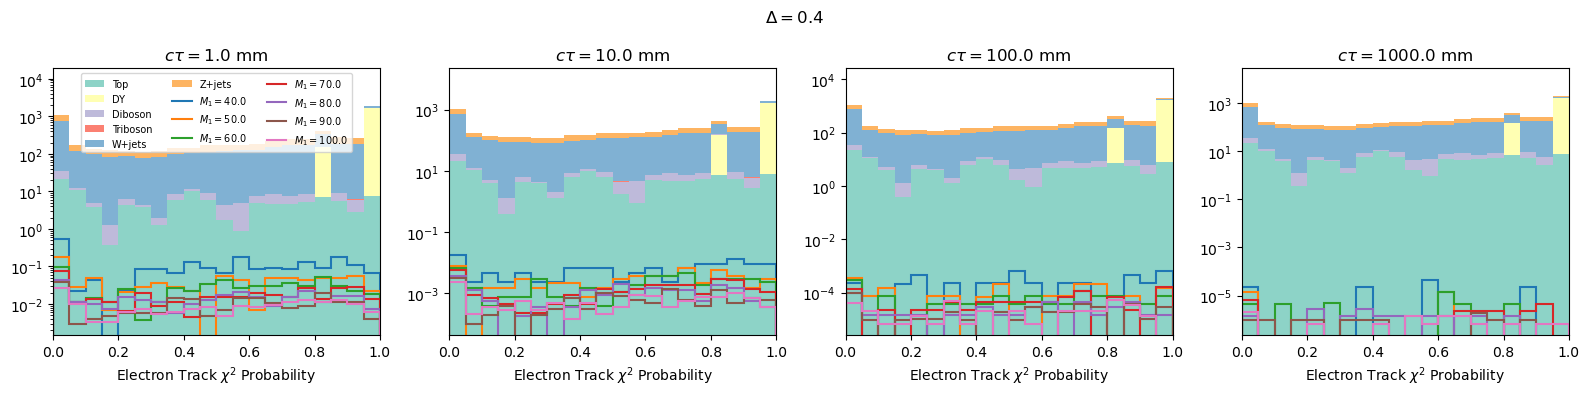

In [34]:
# electron 2 track probability
plot("sel_e2_trkProb",[0,1],logy=True,rebin=5j)

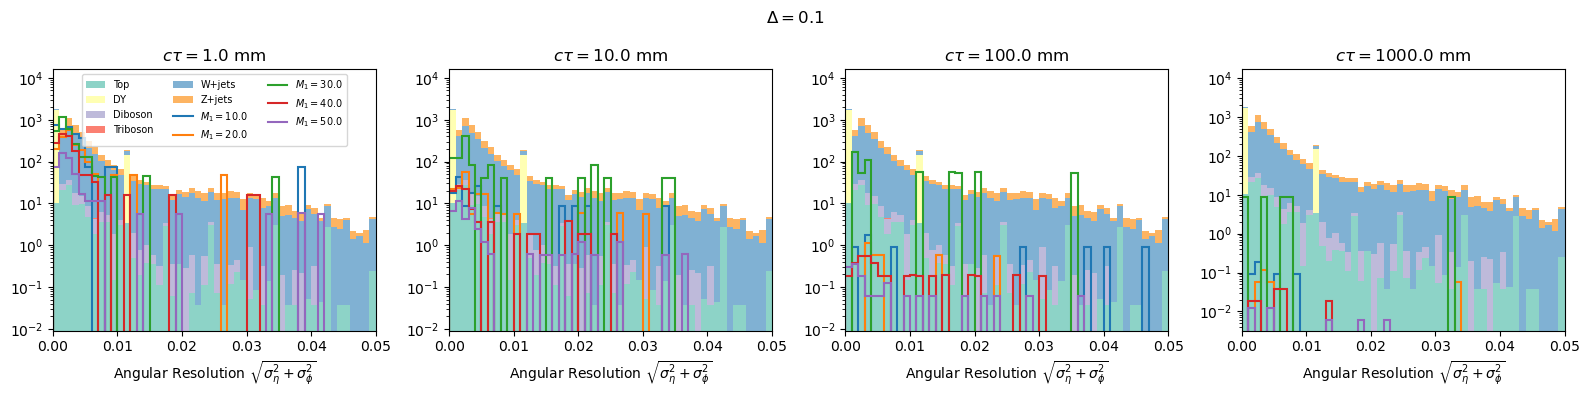

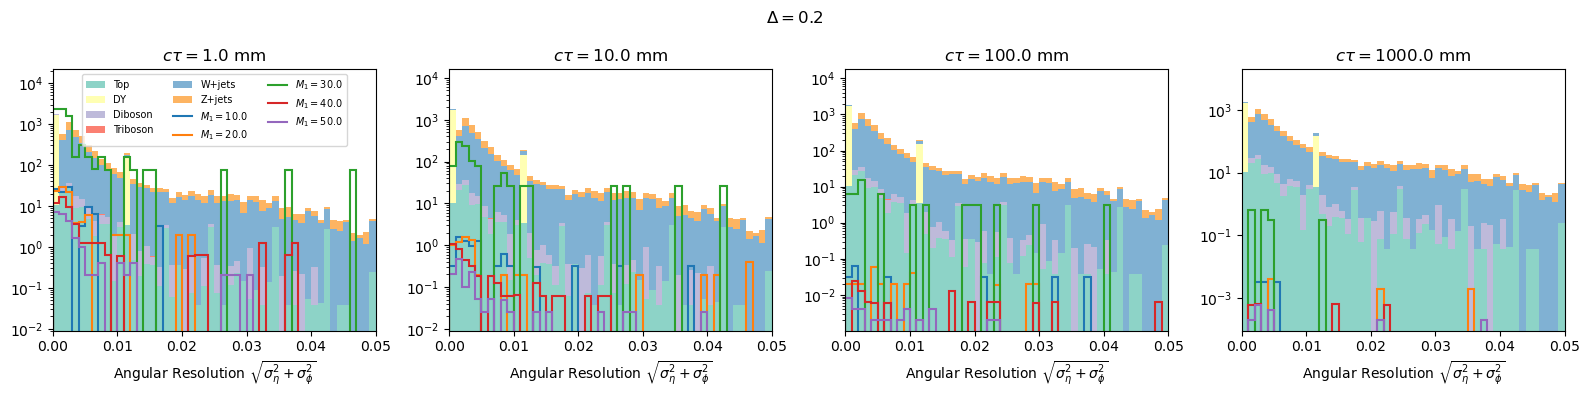

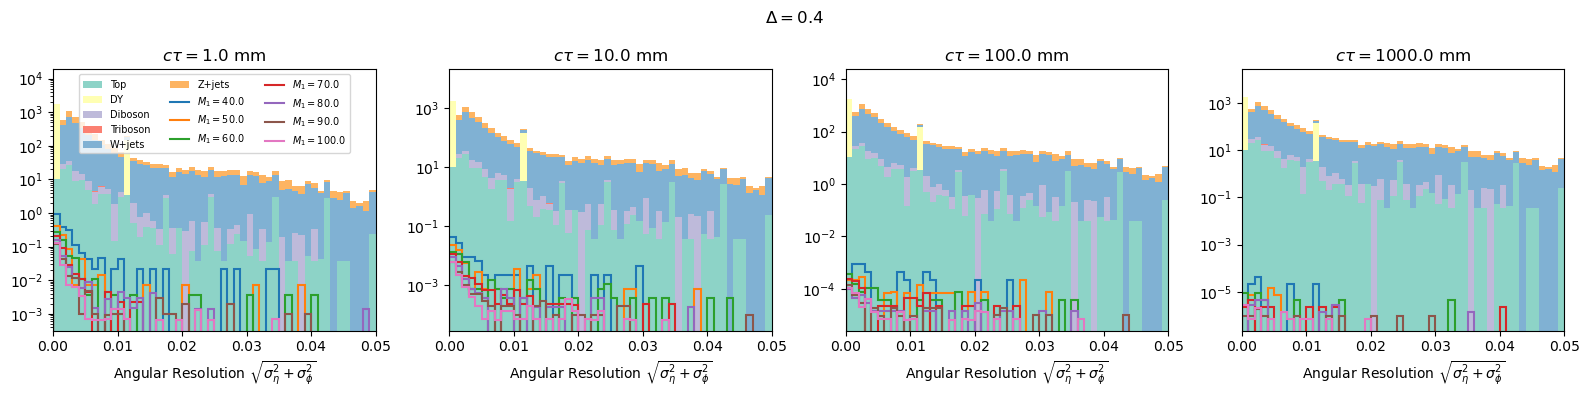

In [35]:
# electron 1 angular resolution
plot("sel_e1_angRes",[0,0.05],logy=True,rebin=1j)

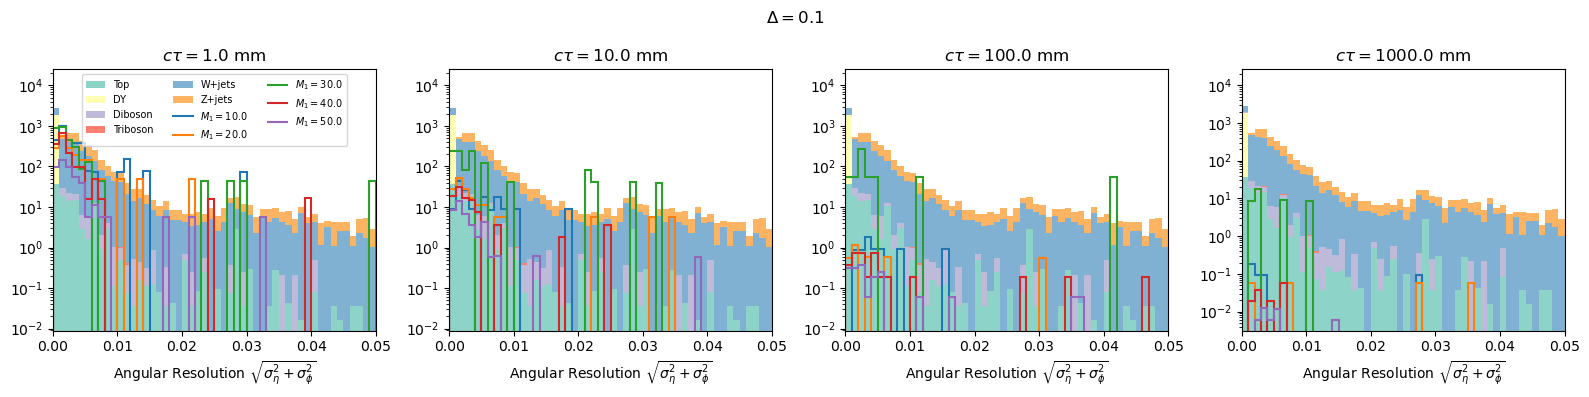

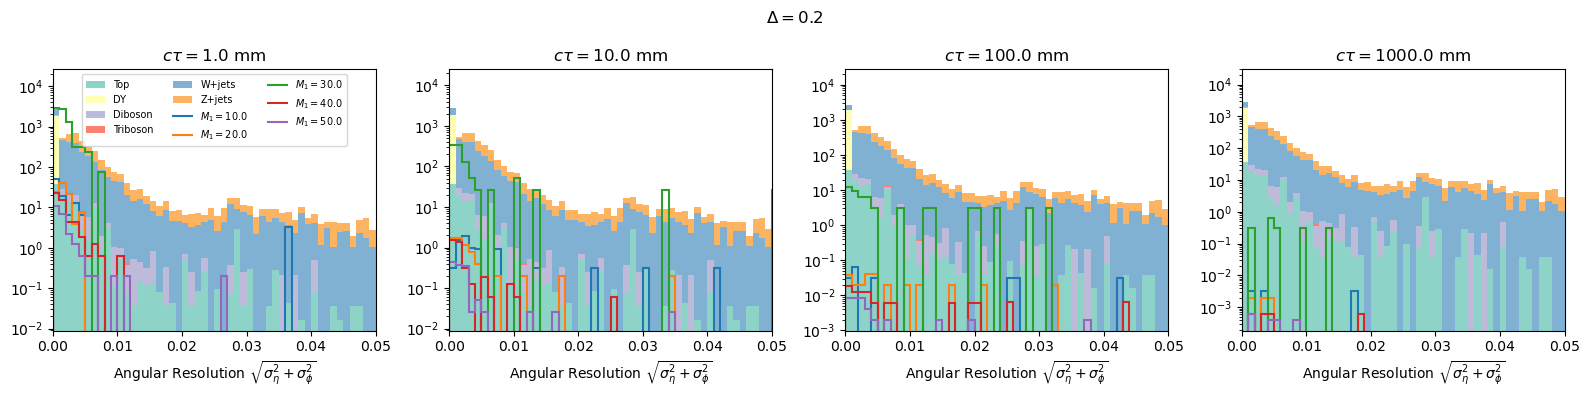

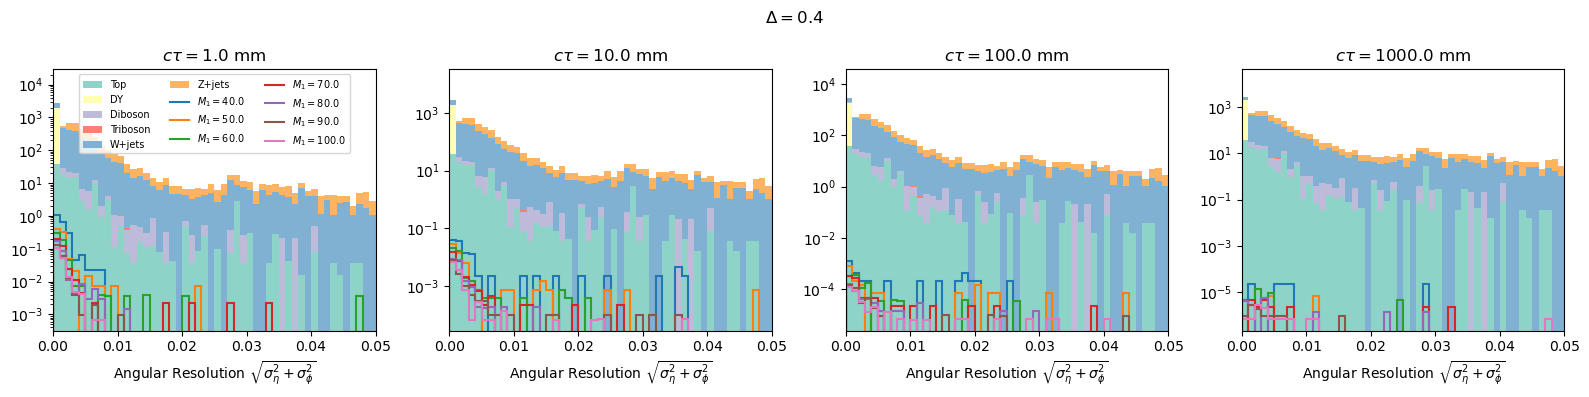

In [36]:
# electron 2 angular resolution
plot("sel_e2_angRes",[0,0.05],logy=True,rebin=1j)

# Displacement

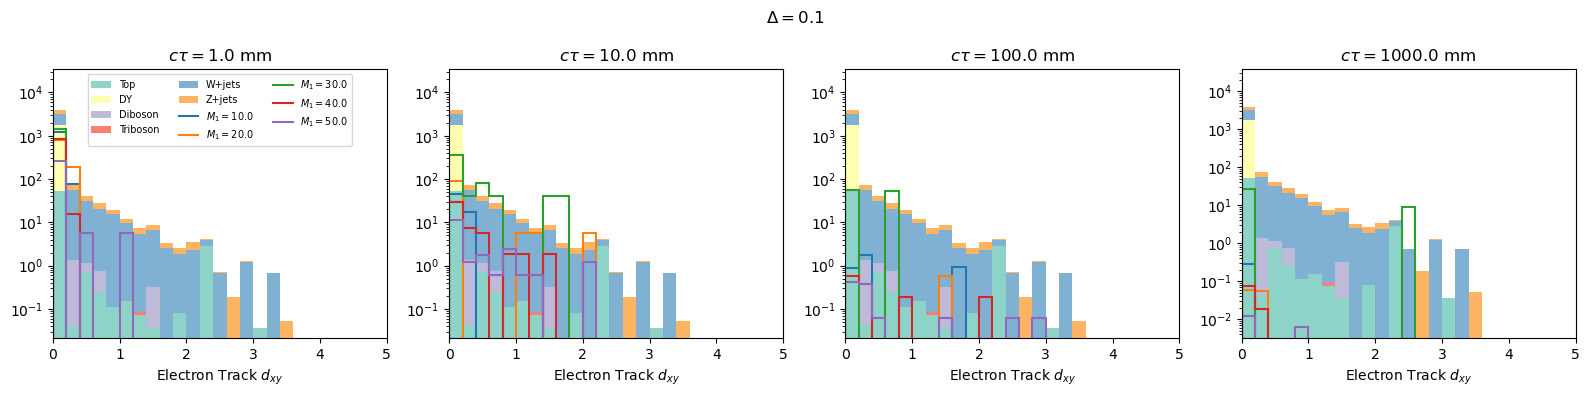

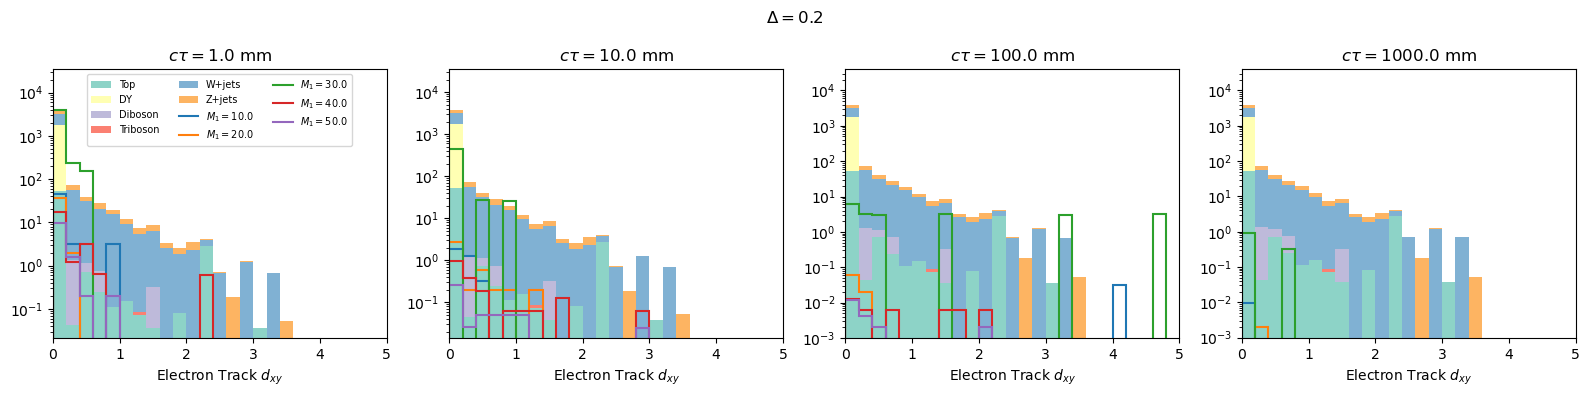

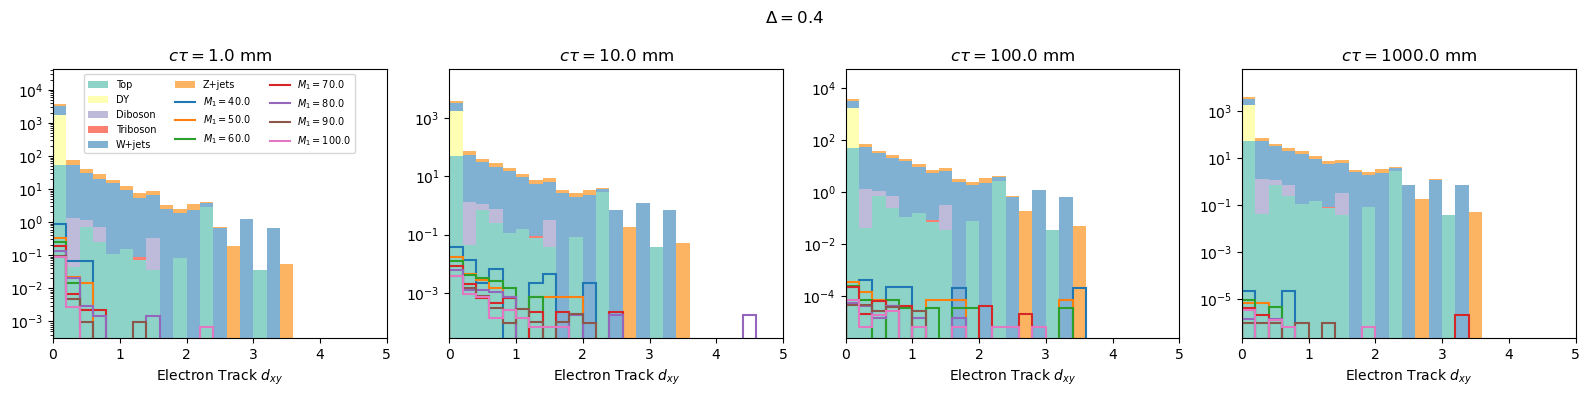

In [37]:
# electron 1 dxy
plot("sel_e1_dxy",[0,5],logy=True,rebin=2j)

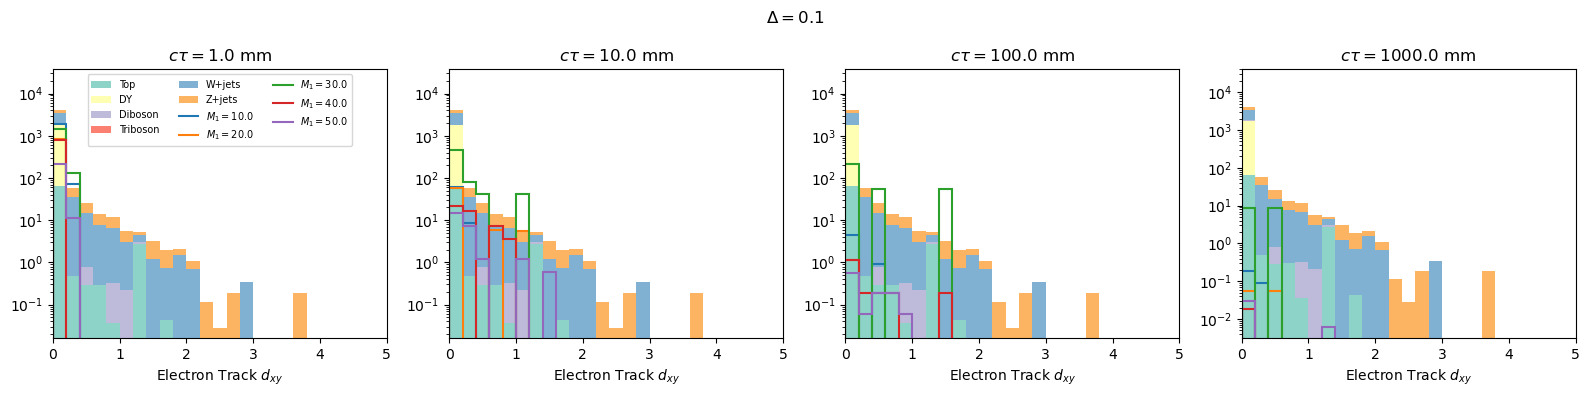

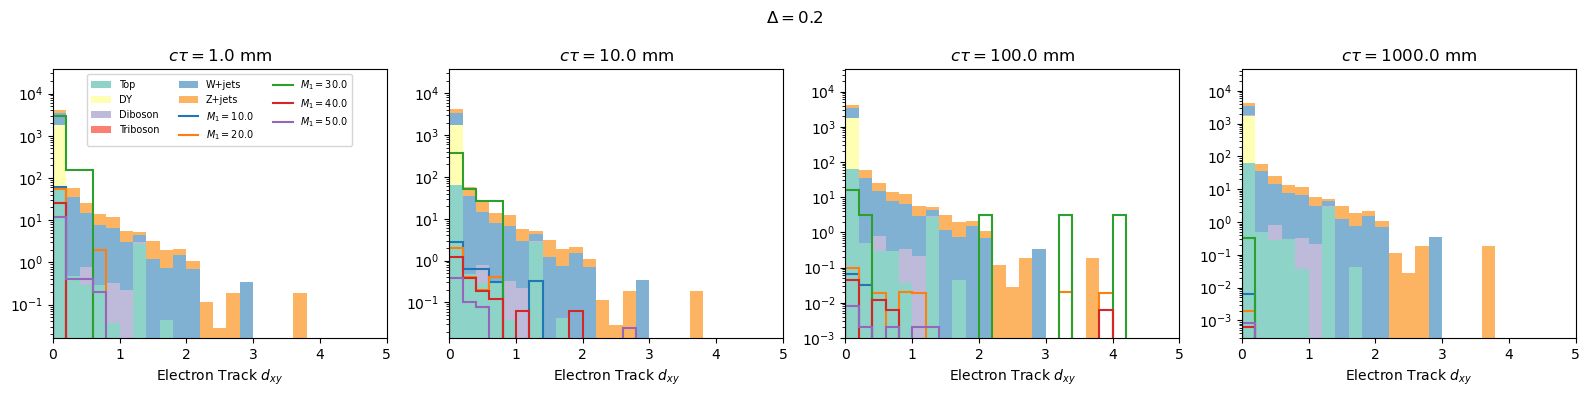

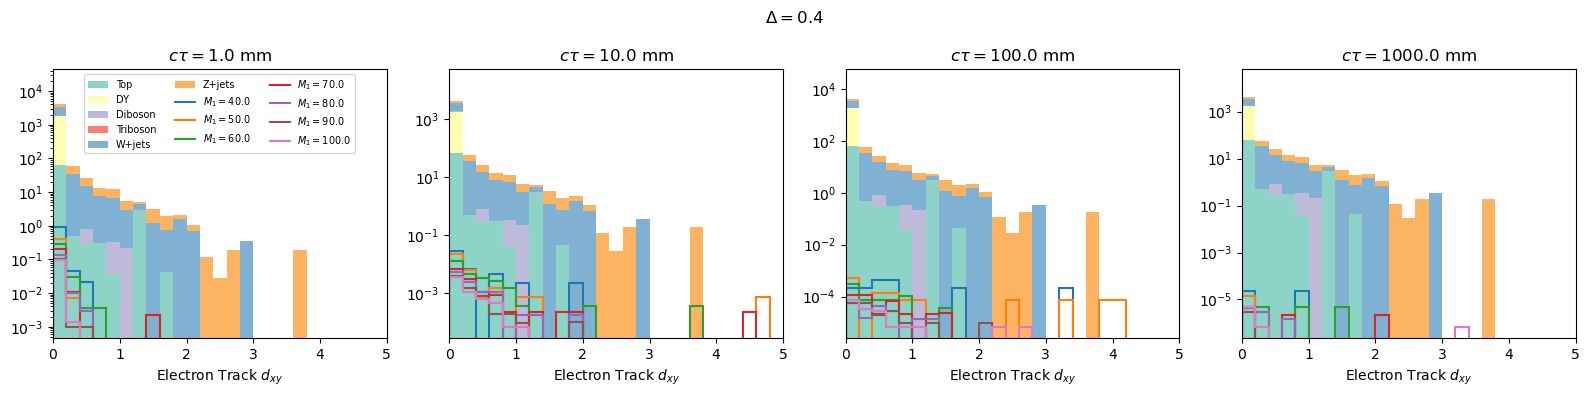

In [38]:
# electron 2 dxy
plot("sel_e2_dxy",[0,5],logy=True,rebin=2j)

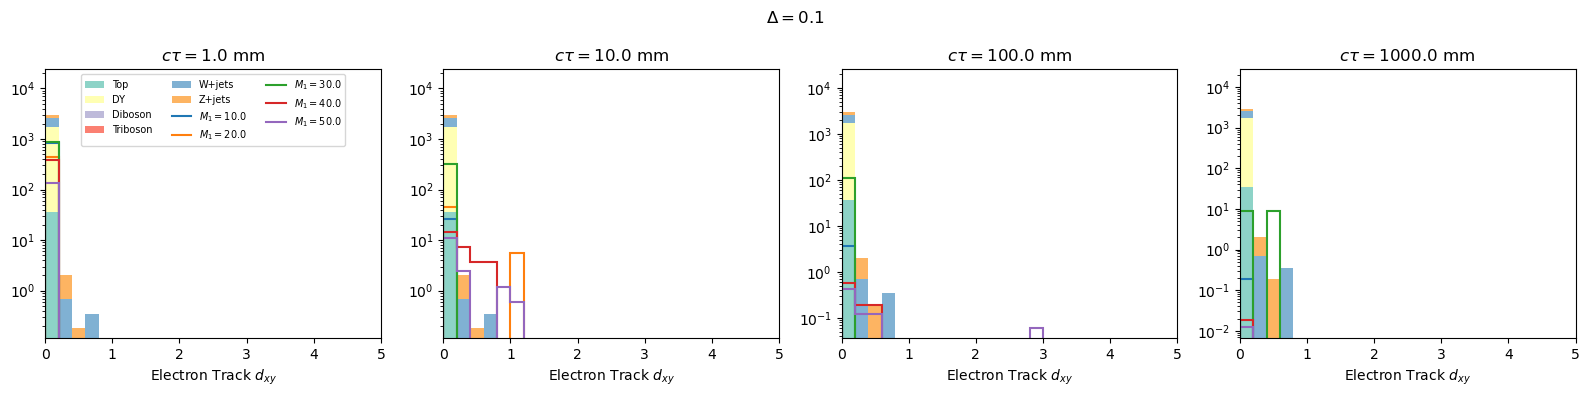

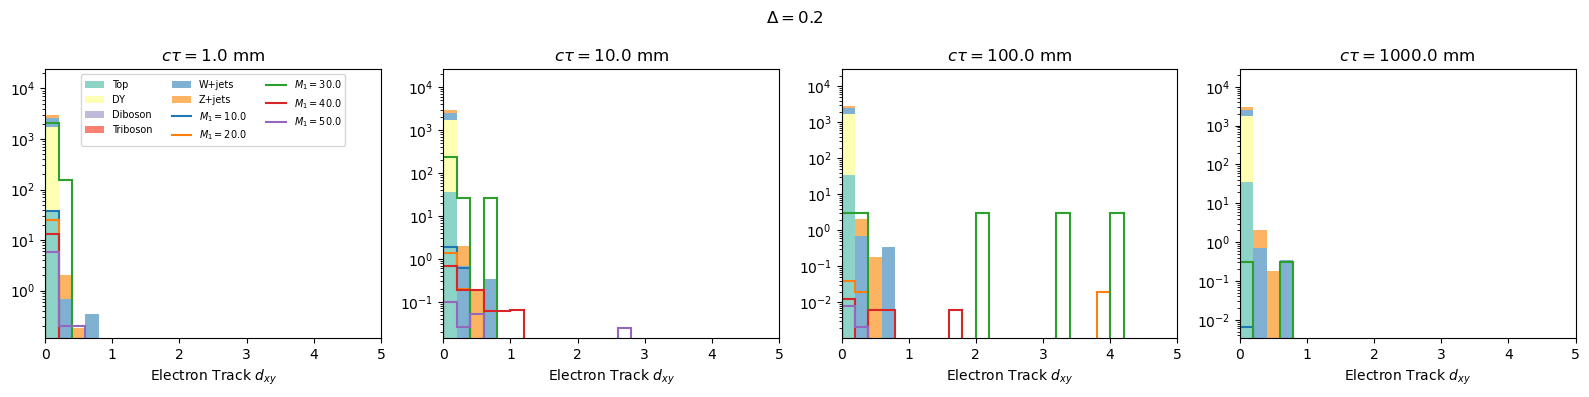

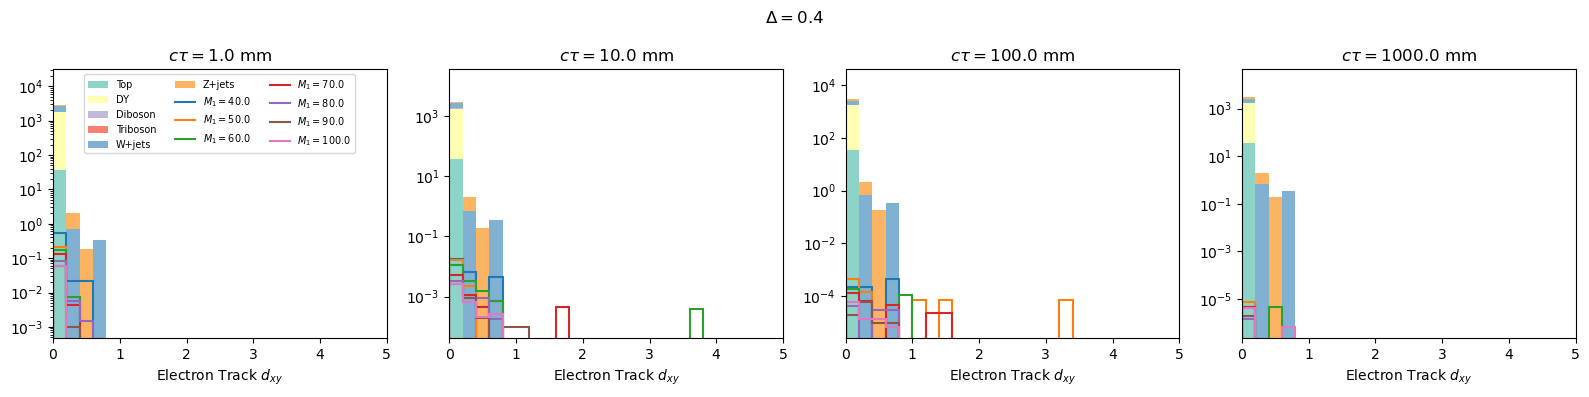

In [39]:
# vertex min(dxy1,dxy2)
plot("sel_vtx_minDxy",[0,5],logy=True,rebin=2j)

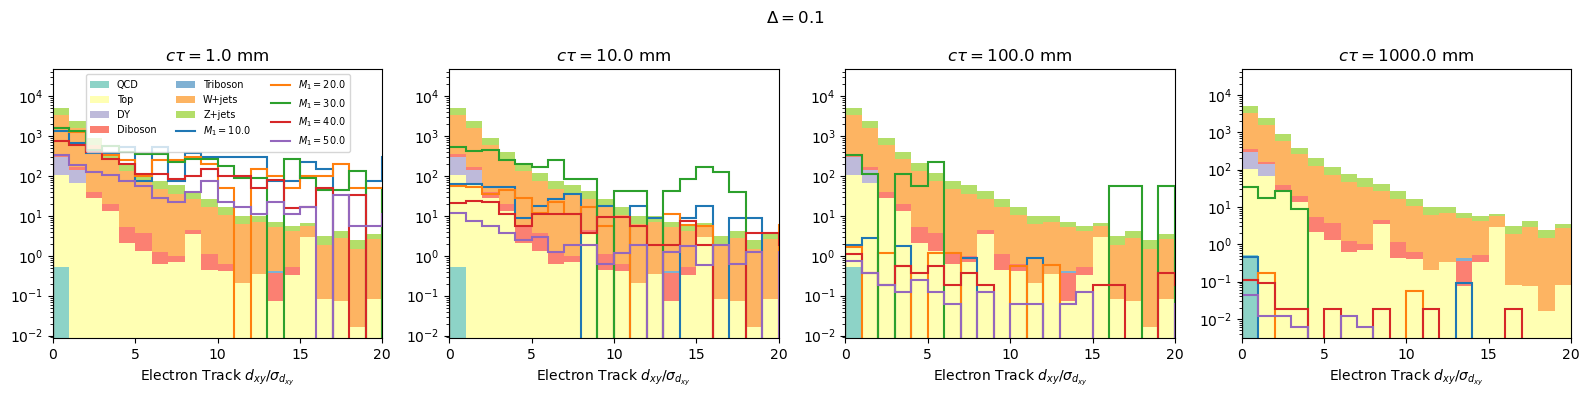

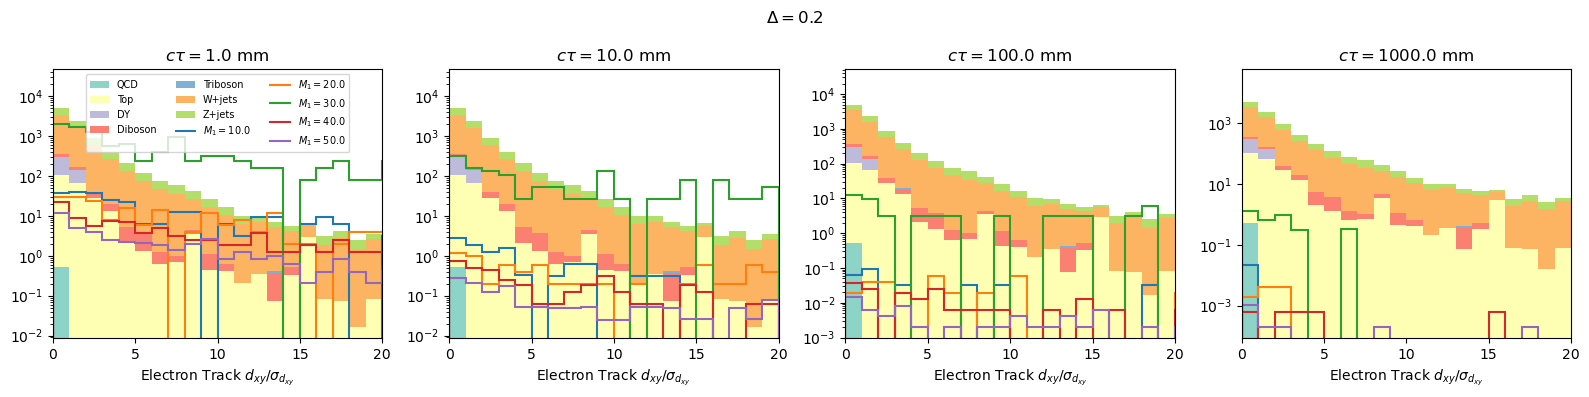

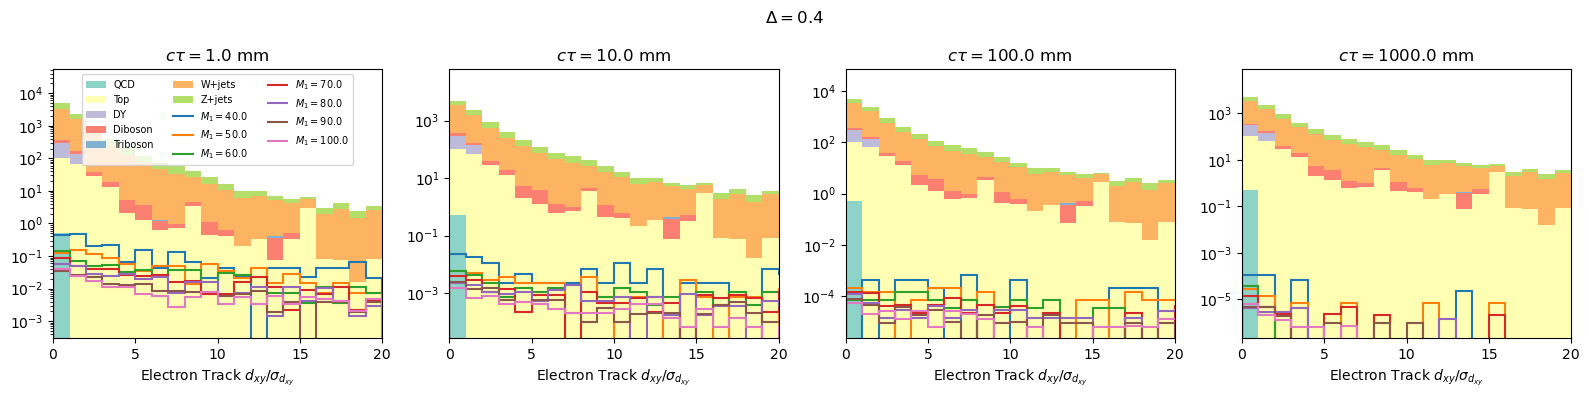

In [33]:
# electron 1 dxy significance
plot("sel_e1_dxySignif",[0,20],logy=True,rebin=1j)

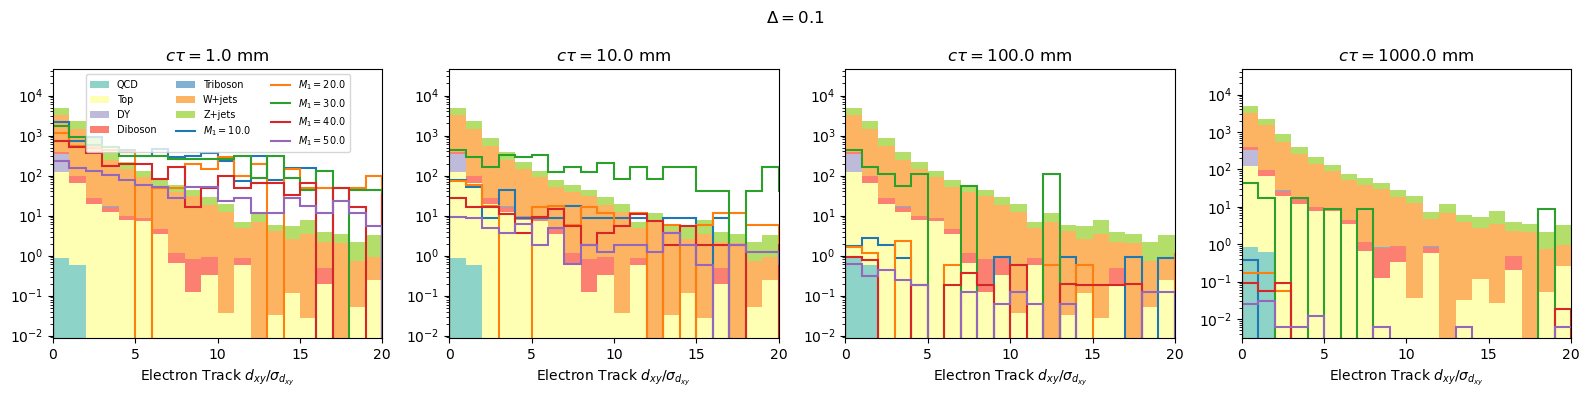

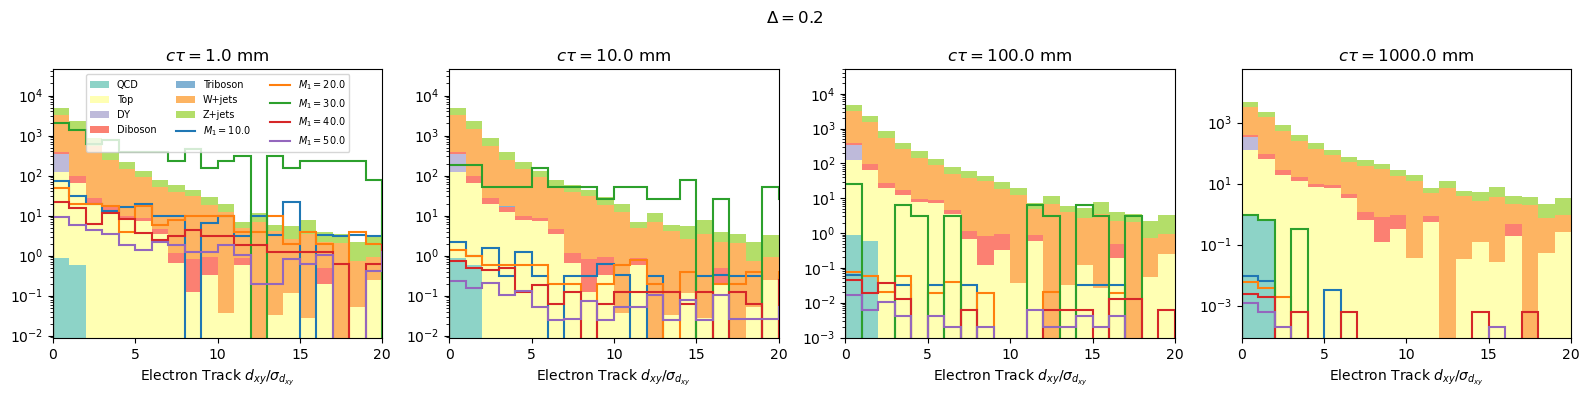

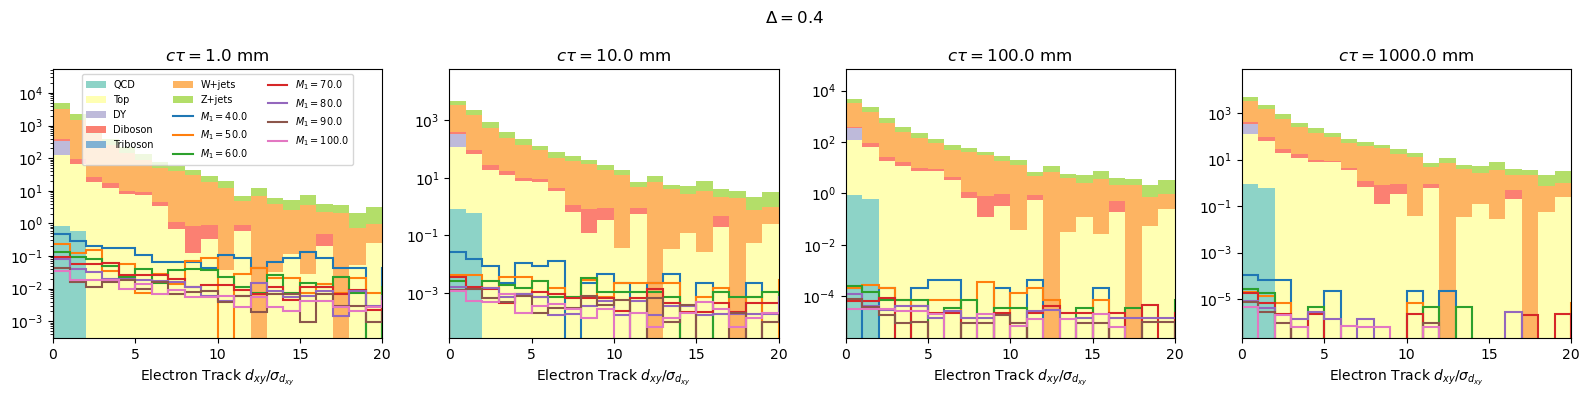

In [34]:
# electron 2 dxy significance
plot("sel_e2_dxySignif",[0,20],logy=True,rebin=1j)

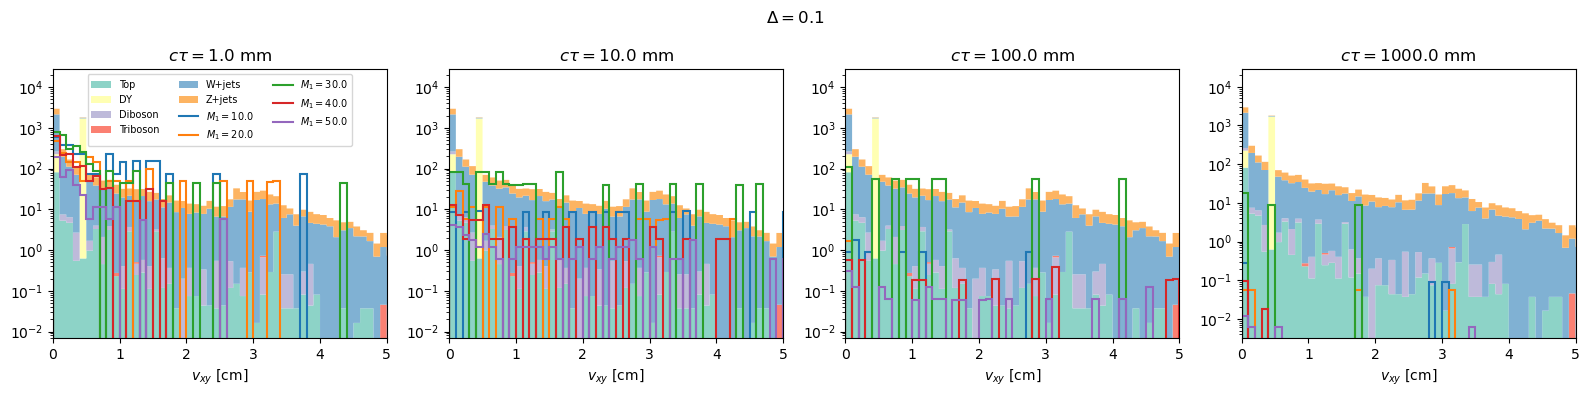

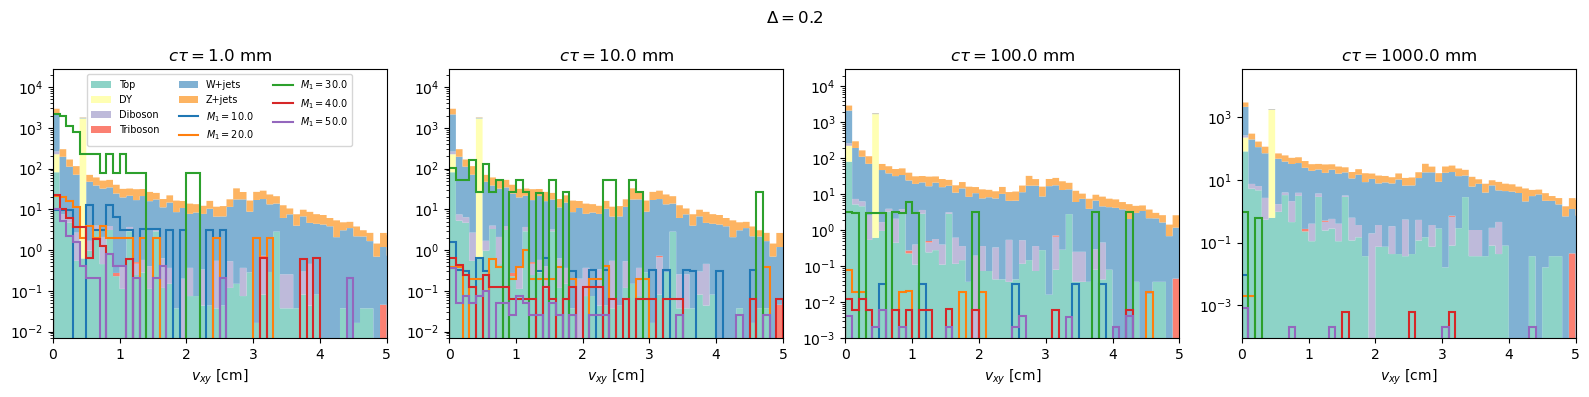

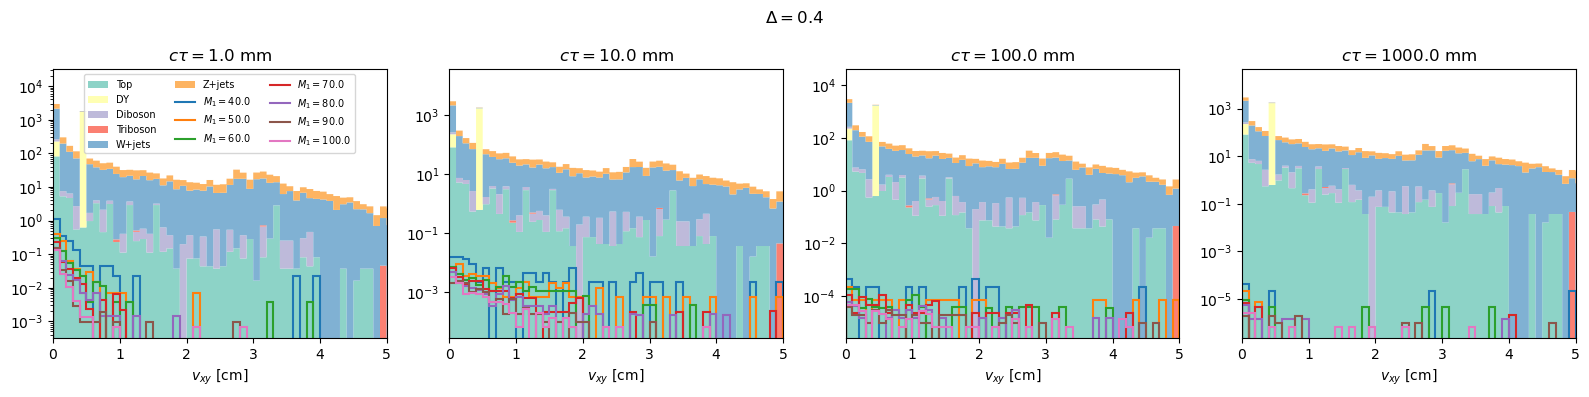

In [40]:
# vertex vxy
plot("sel_vtx_vxy",[0,5],logy=True,rebin=4j)

# Vertex dR

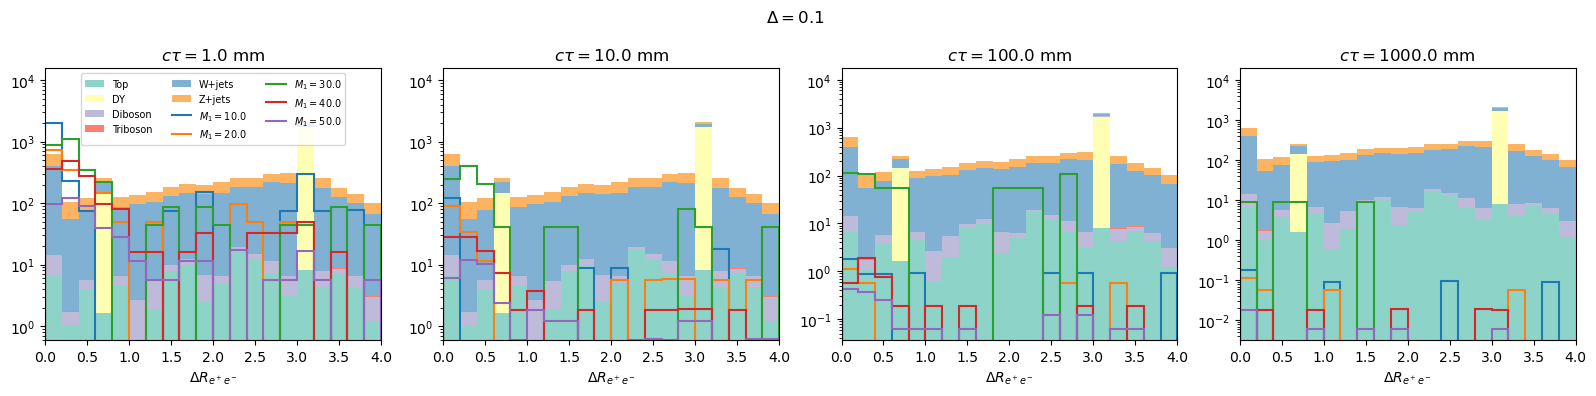

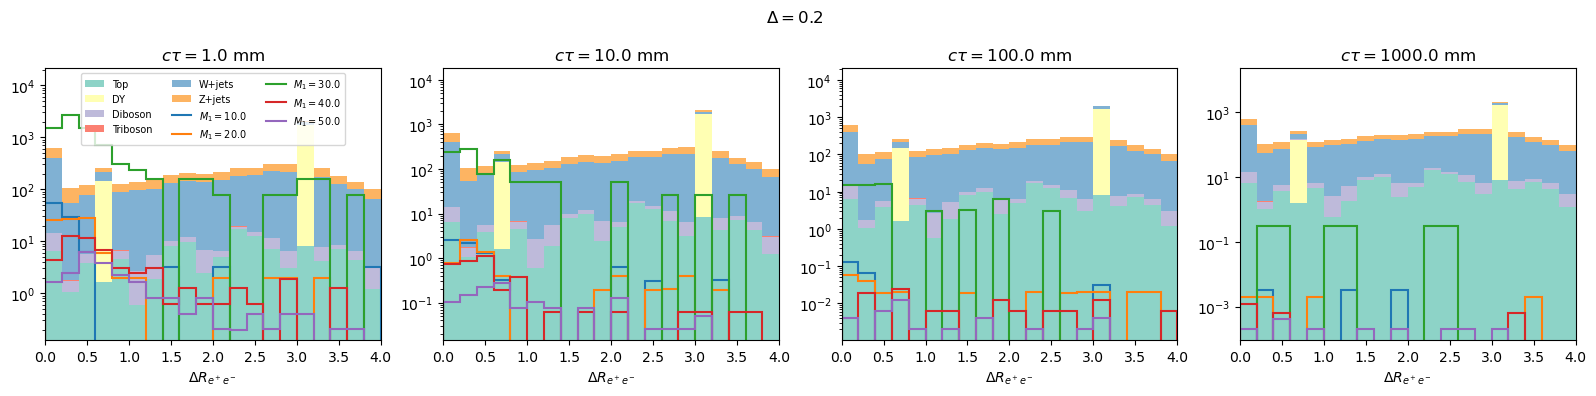

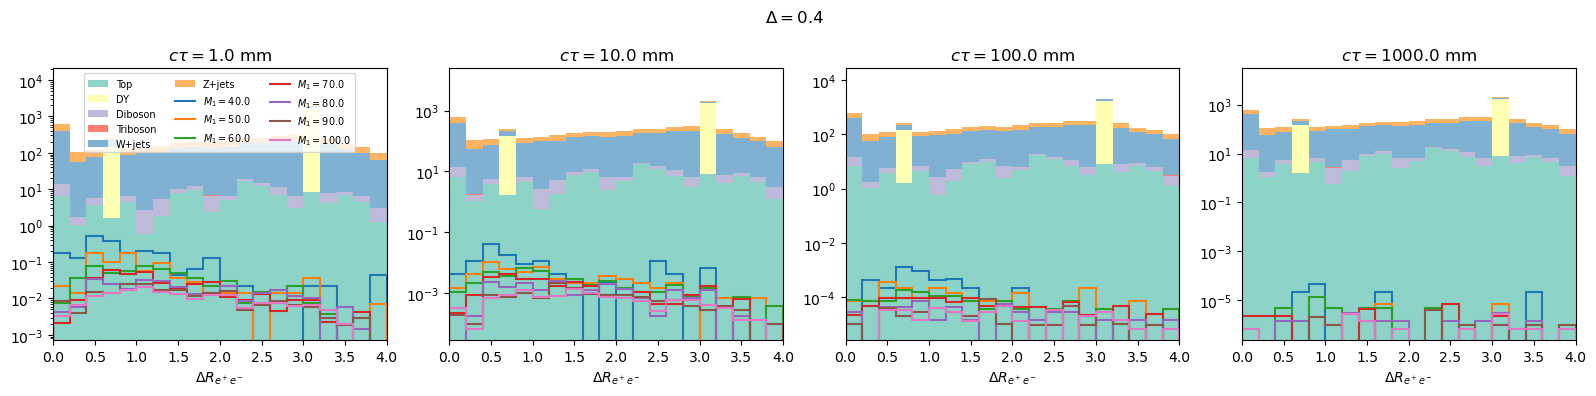

In [41]:
# vertex dR
plot("sel_vtx_dR",[0,4],logy=True,rebin=4j)

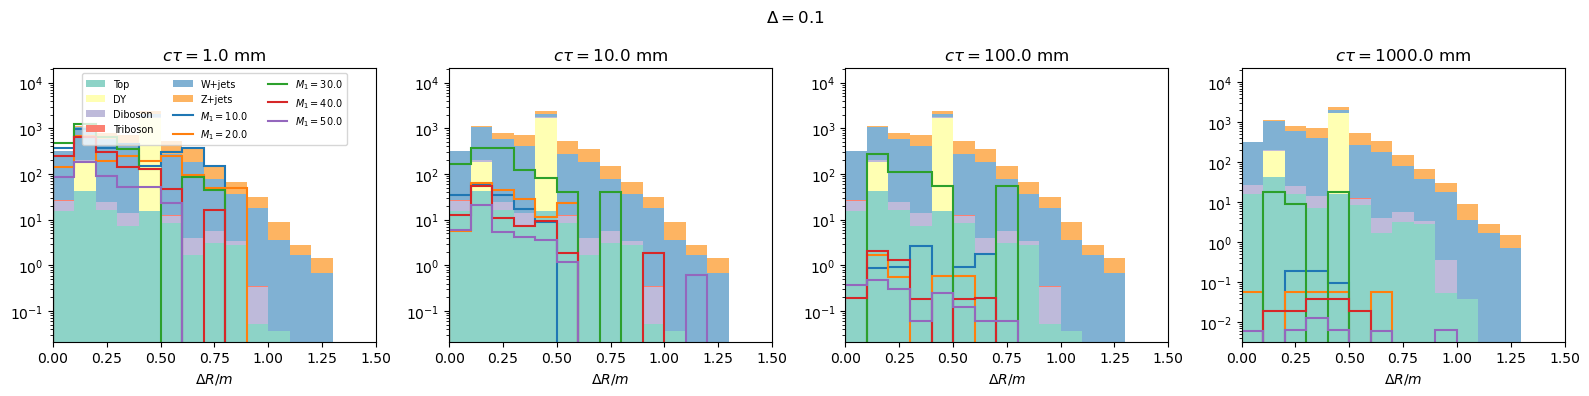

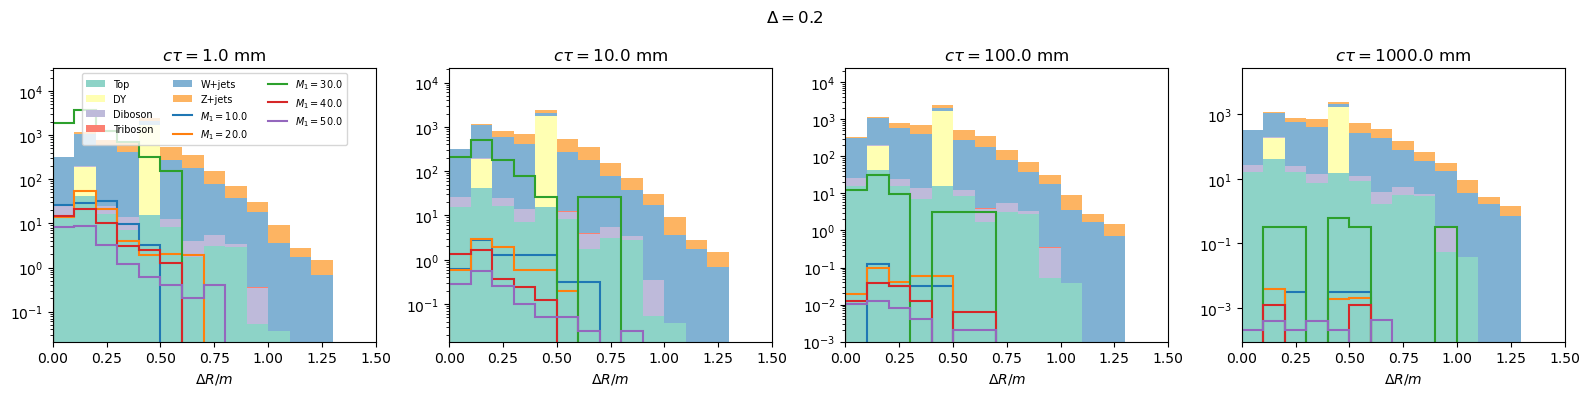

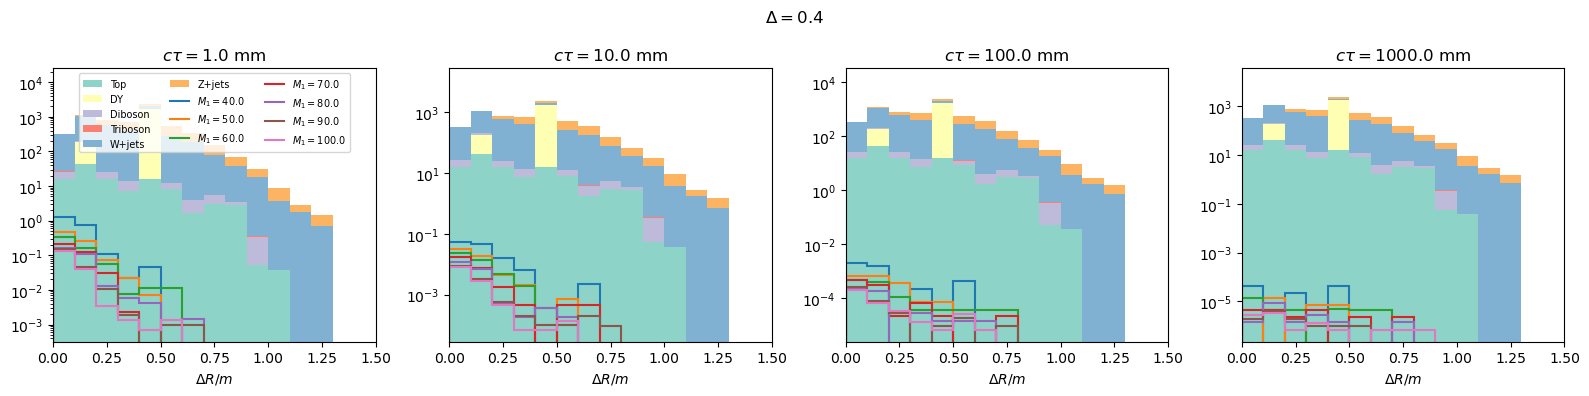

In [42]:
# vertex dR/m
plot("sel_vtx_dR_over_m",[0,1.5],logy=True,rebin=2j)

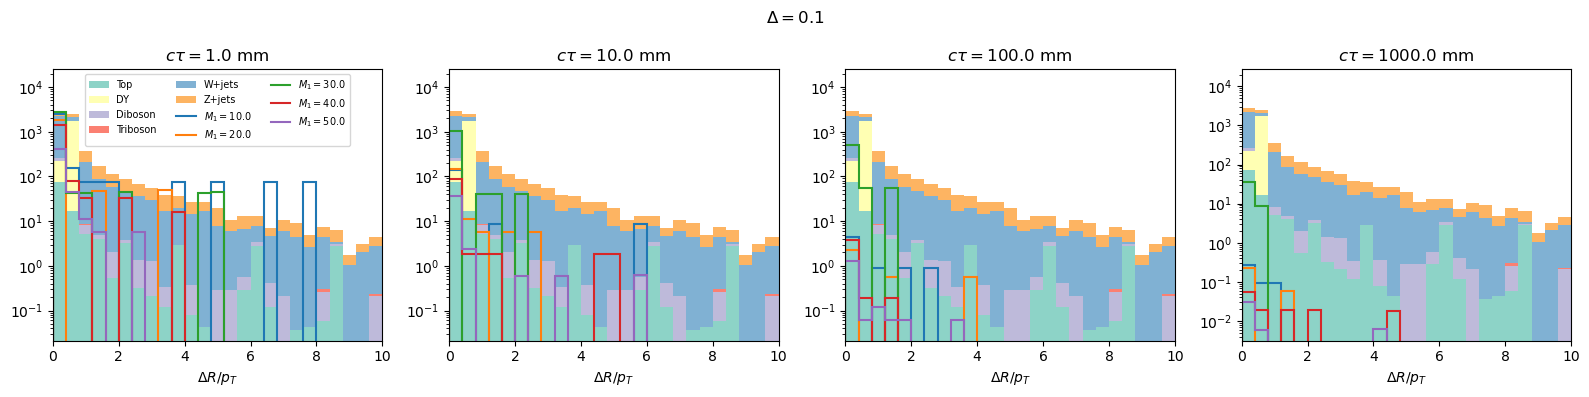

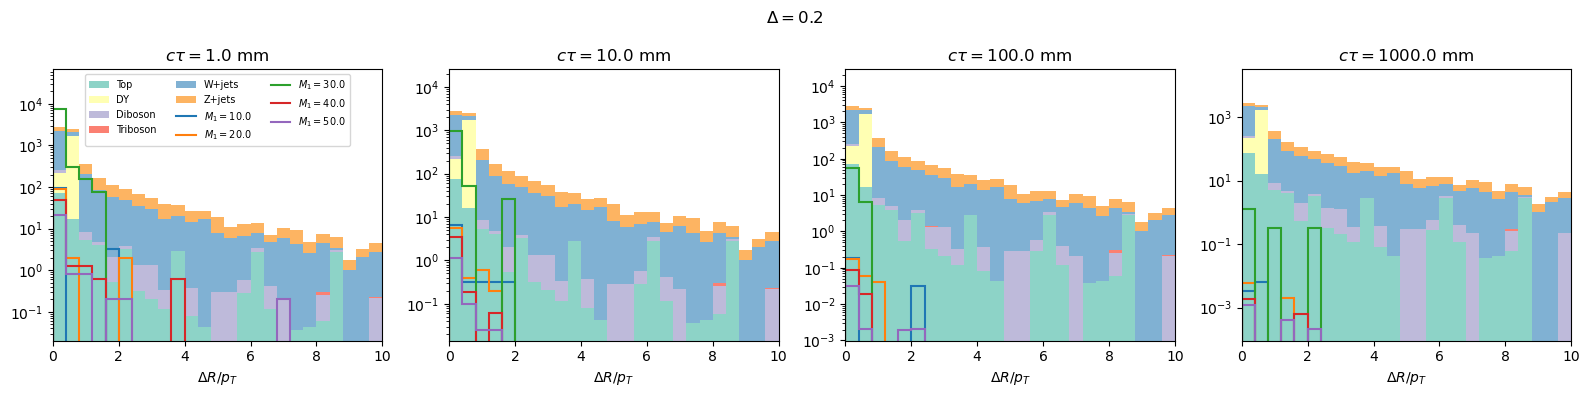

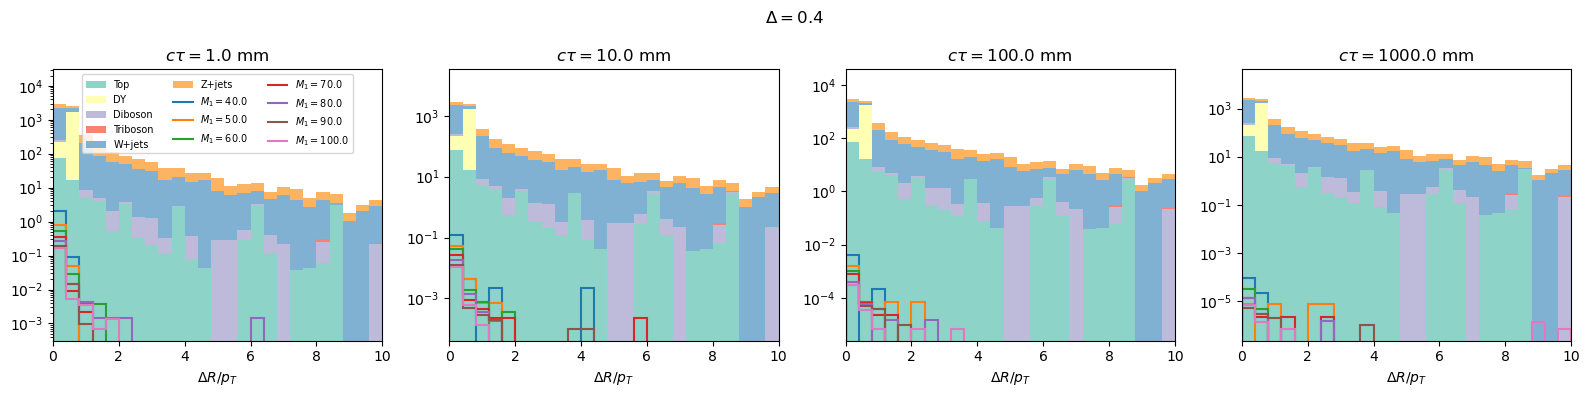

In [43]:
# vertex dR/pT
plot("sel_vtx_dR_over_pT",[0,10],logy=True,rebin=4j)

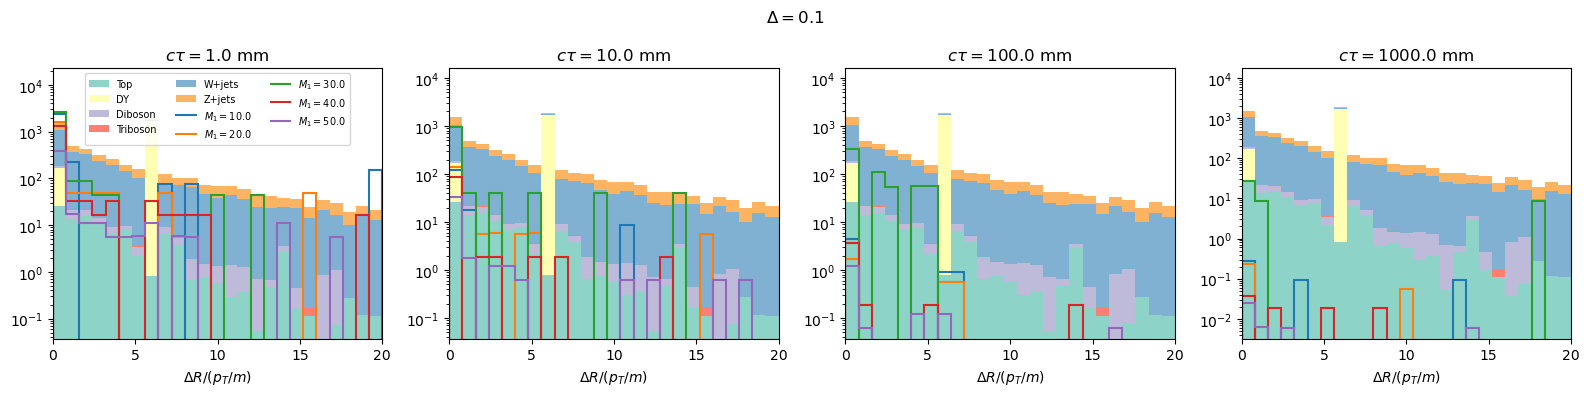

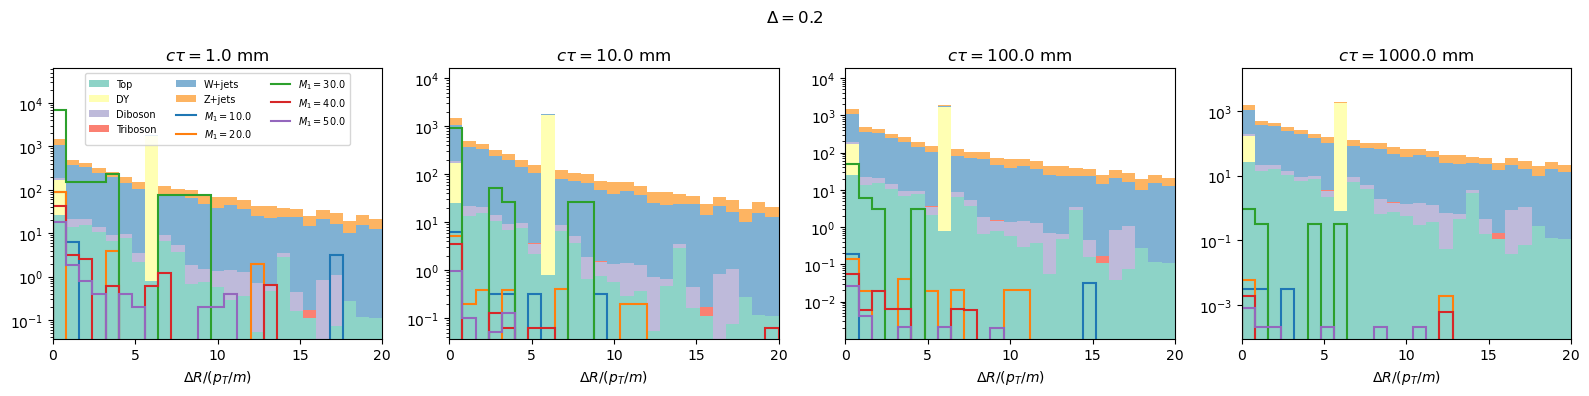

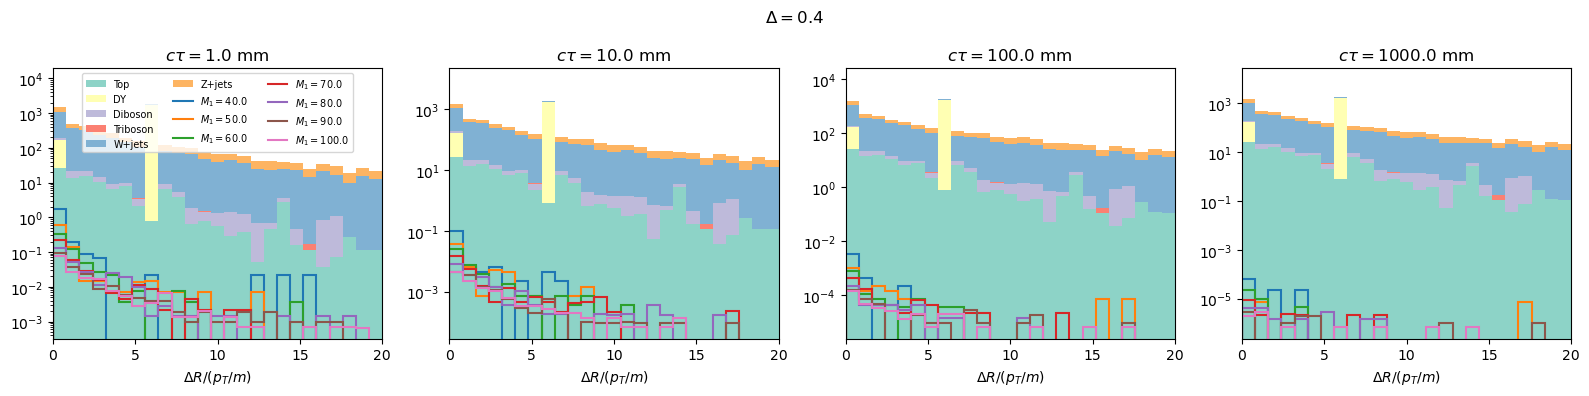

In [44]:
# vertex dR/(pT/m)
plot("sel_vtx_dR_over_pTm",[0,20],logy=True,rebin=4j)

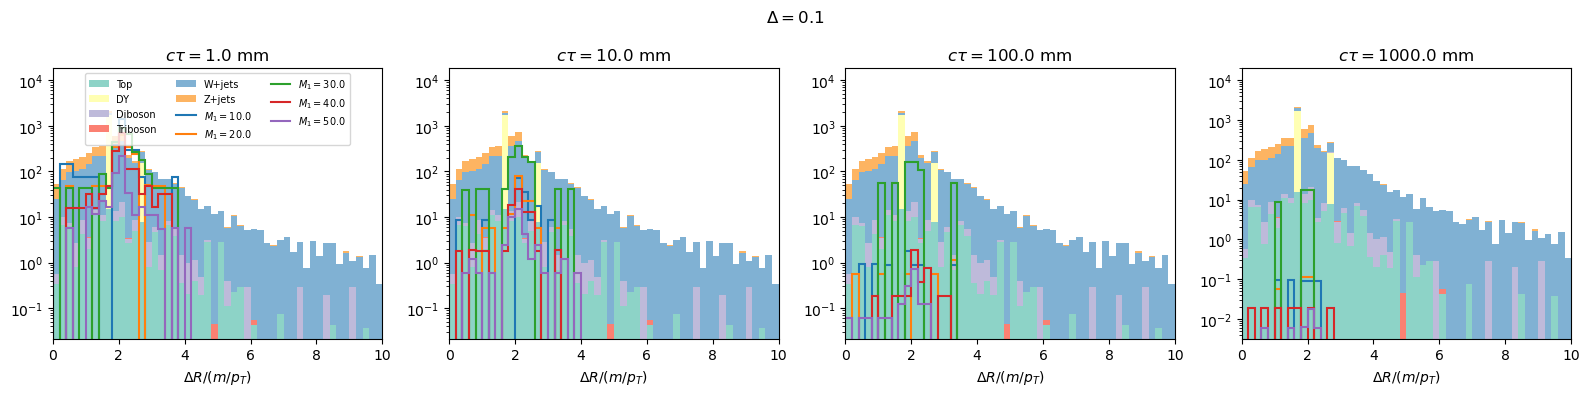

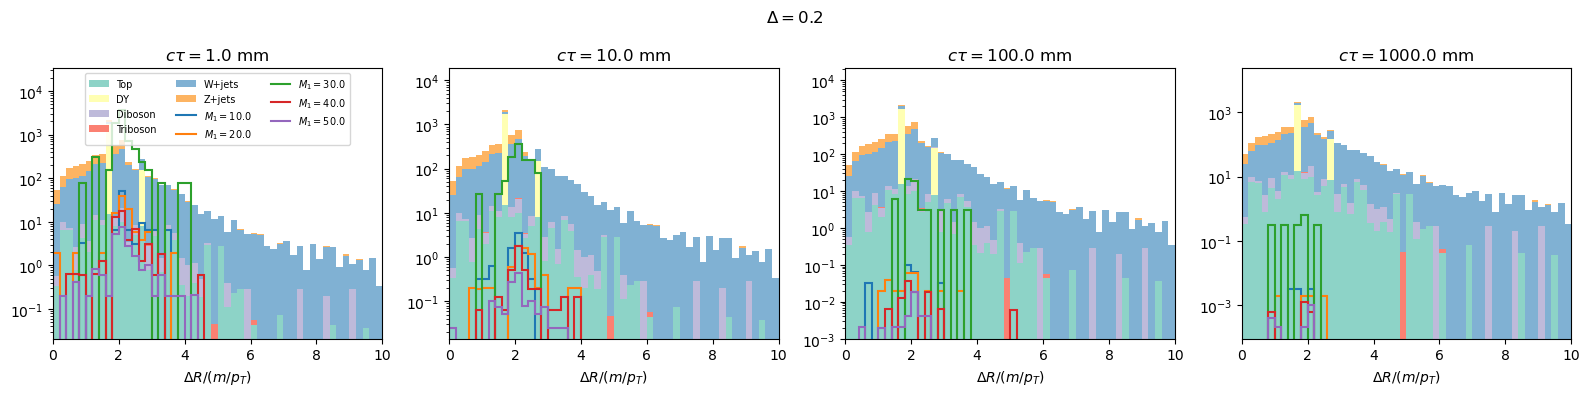

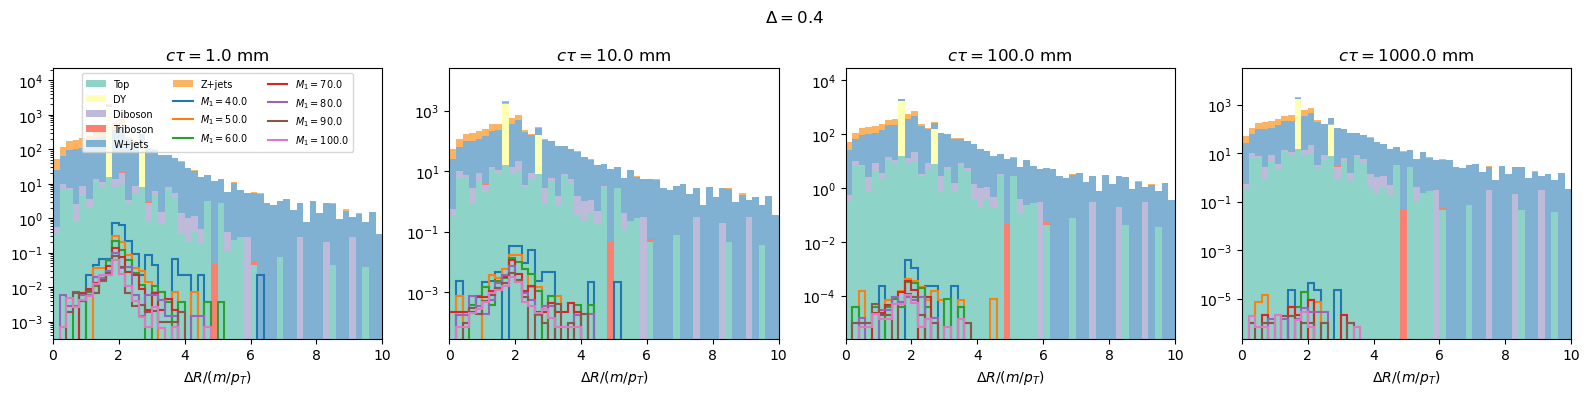

In [45]:
# vertex dR/(m/pT)
plot("sel_vtx_dR_over_mpT",[0,10],logy=True,rebin=2j)

# Vertex-MET dPhi

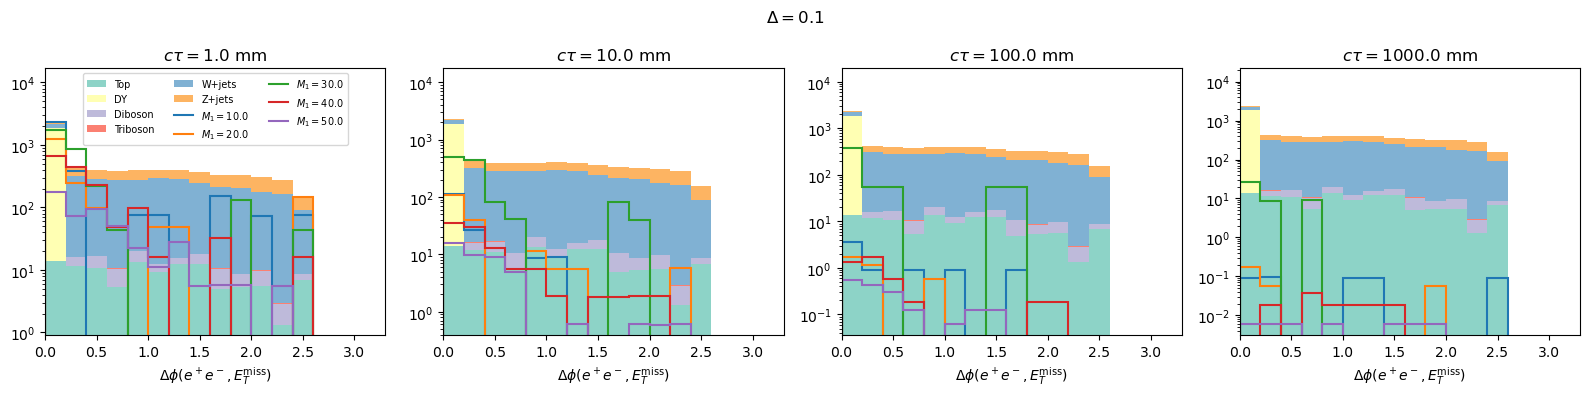

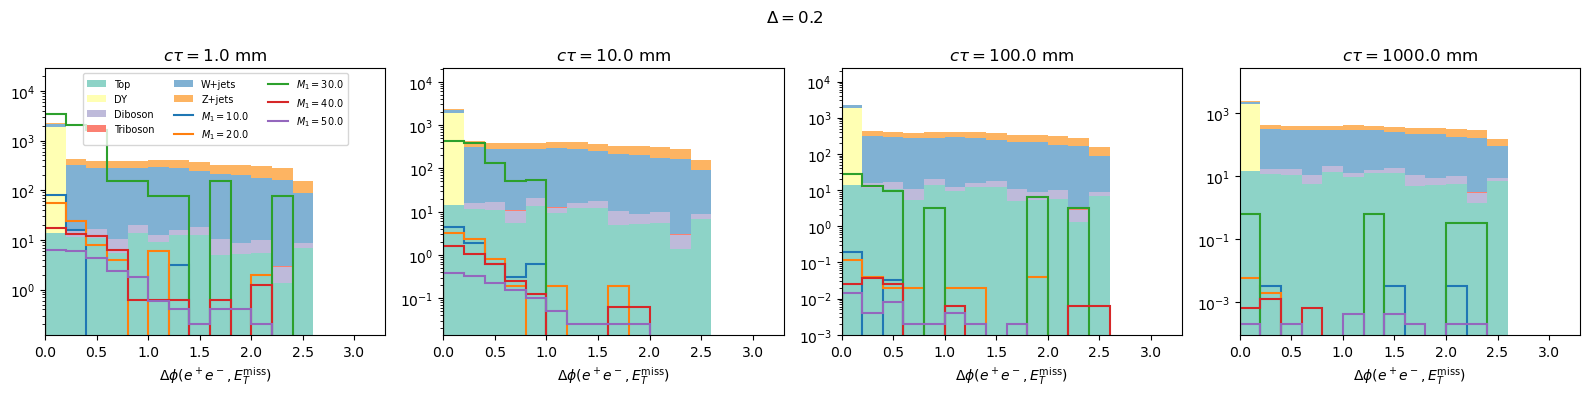

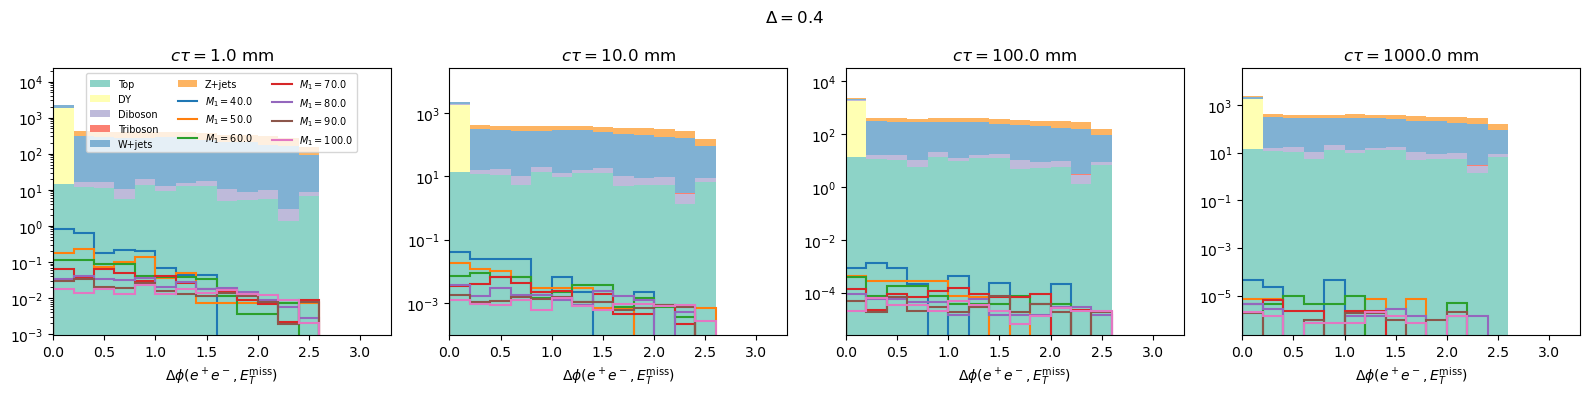

In [46]:
# vertex MET dPhi
plot("vtx_met_dPhi",[0,3.3],logy=True,rebin=2j,xlabel=r"$\Delta \phi(e^+e^-,E_T^\mathrm{miss})$")

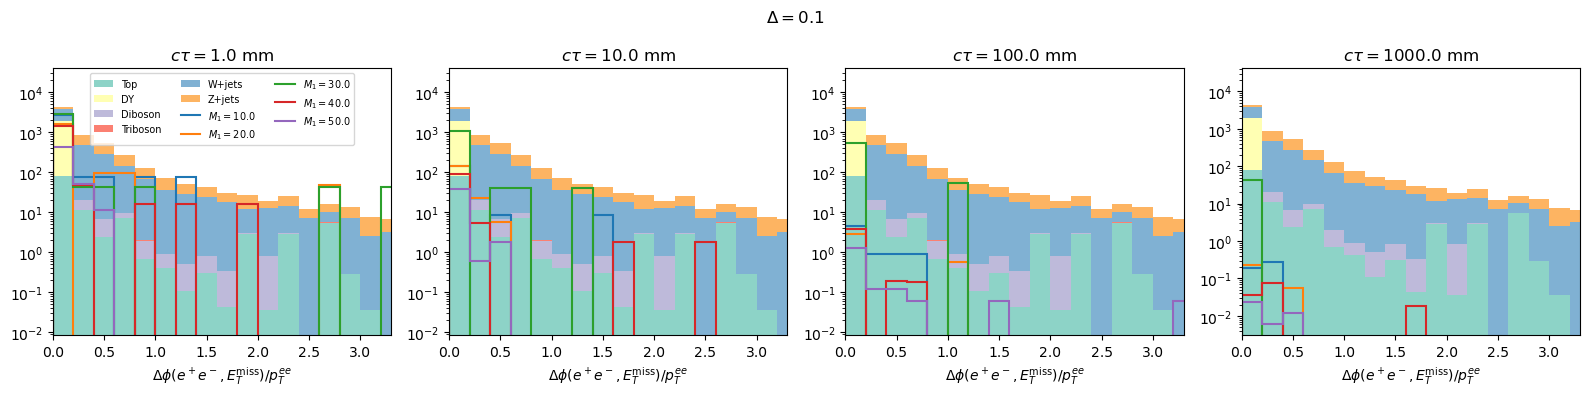

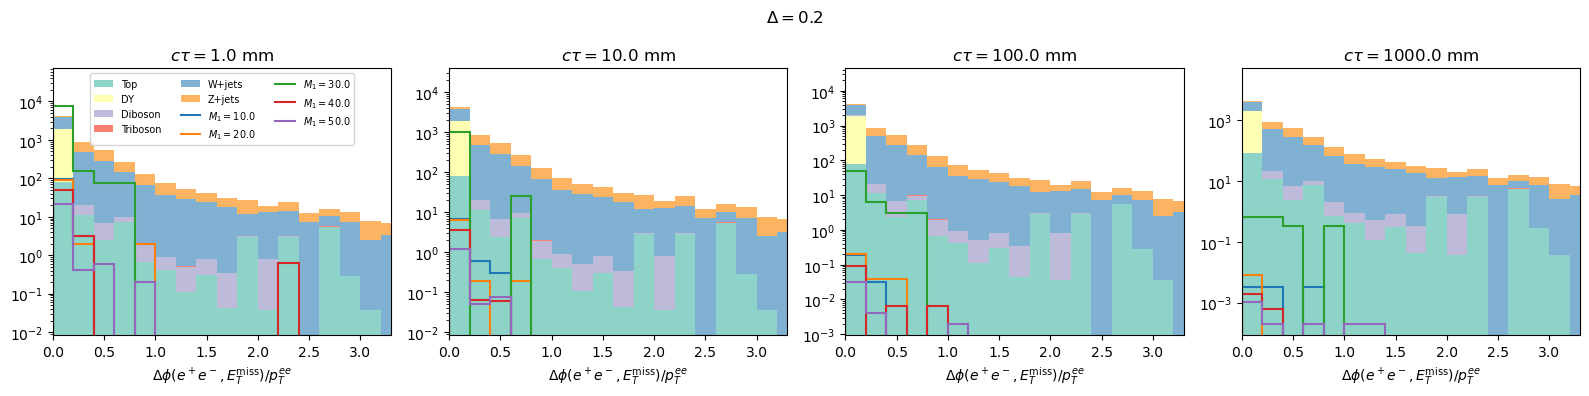

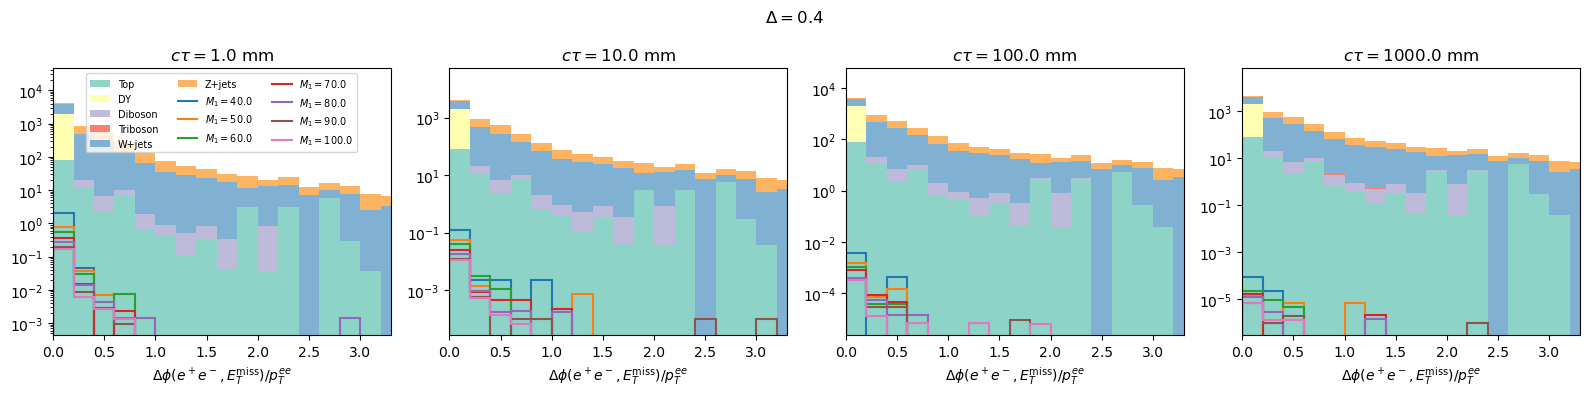

In [47]:
# vertex MET dPhi / pT
plot("sel_vtx_METdPhi_over_pT",[0,3.3],logy=True,rebin=2j,xlabel=r"$\Delta \phi(e^+e^-,E_T^\mathrm{miss})/p_T^{ee}$")

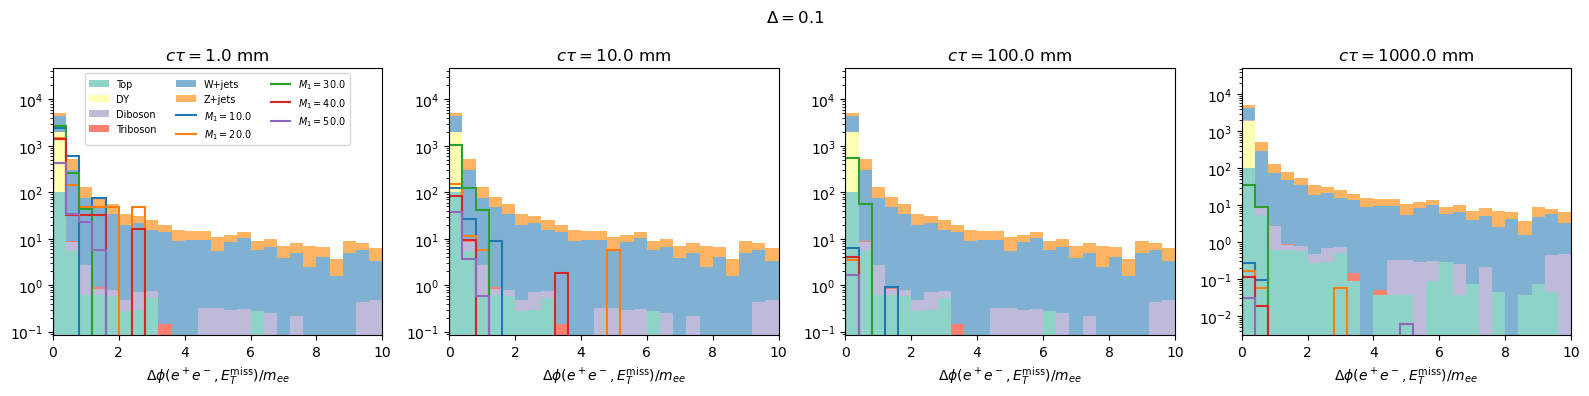

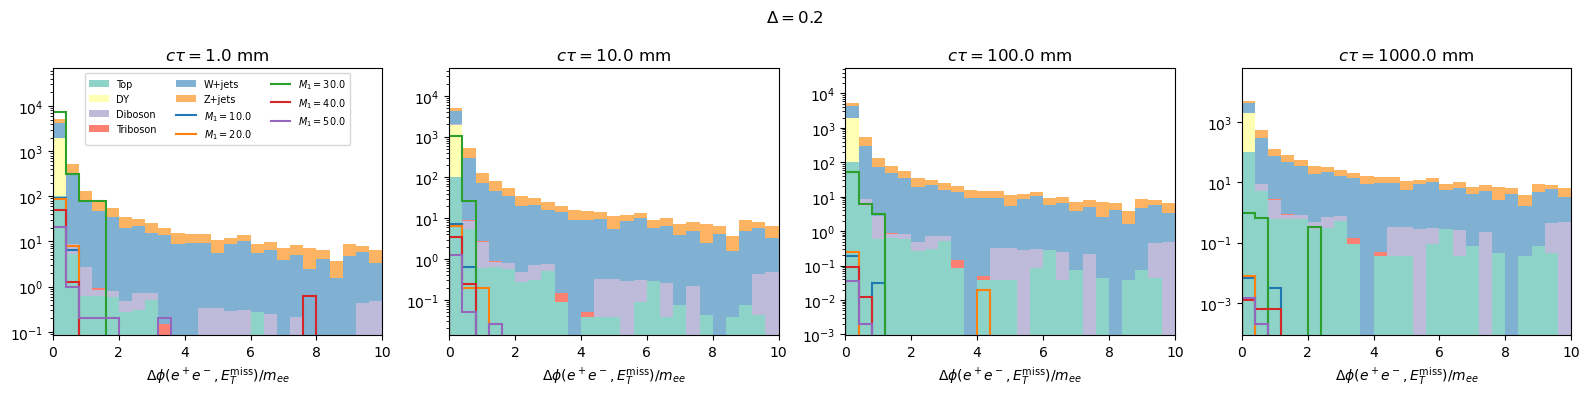

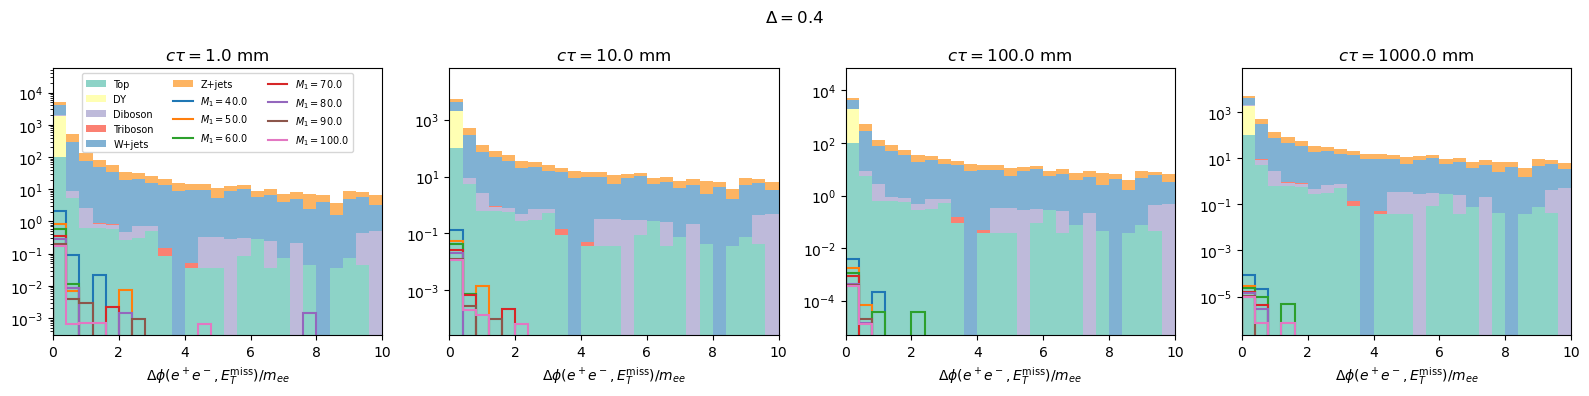

In [48]:
# vertex MET dPhi / m
plot("sel_vtx_METdPhi_over_m",[0,10],logy=True,rebin=2j,xlabel=r"$\Delta \phi(e^+e^-,E_T^\mathrm{miss})/m_{ee}$")

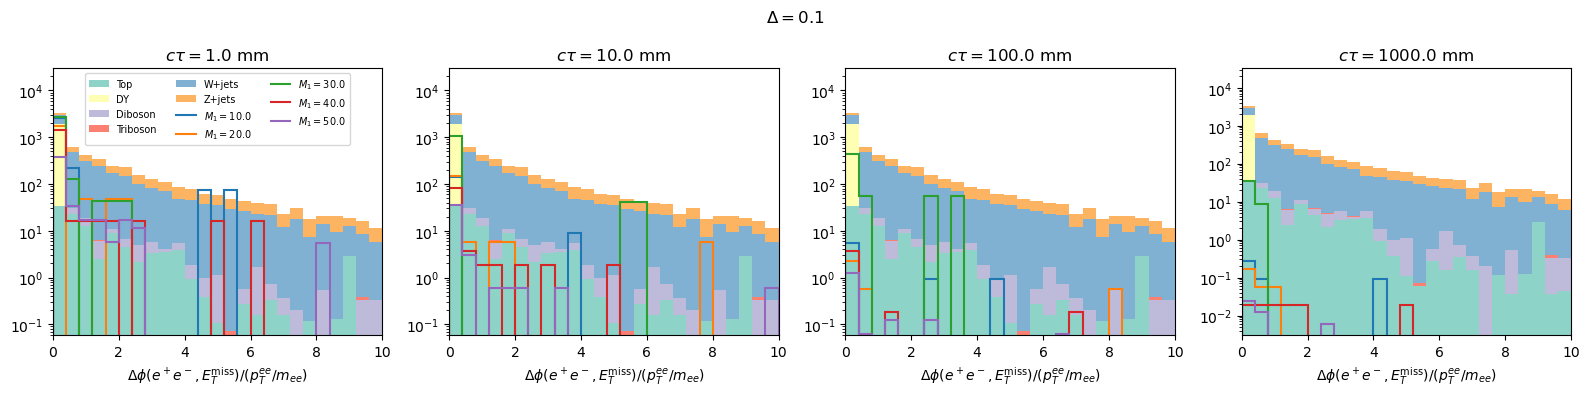

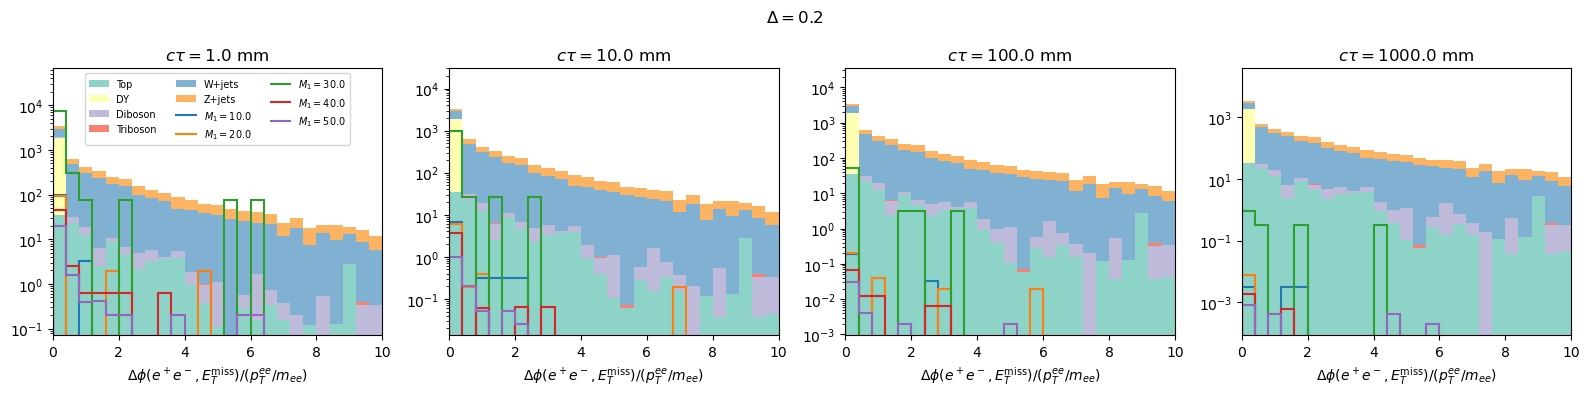

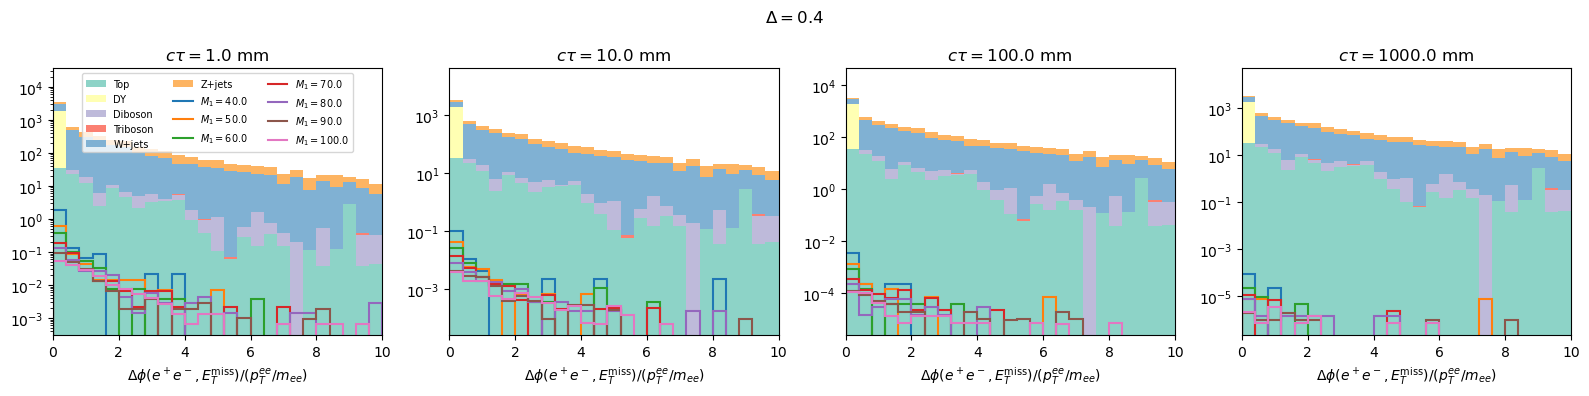

In [49]:
# vertex MET dPhi / (pT/m)
plot("sel_vtx_METdPhi_over_pTm",[0,10],logy=True,rebin=4j,xlabel=r"$\Delta \phi(e^+e^-,E_T^\mathrm{miss})/(p_T^{ee}/m_{ee})$")

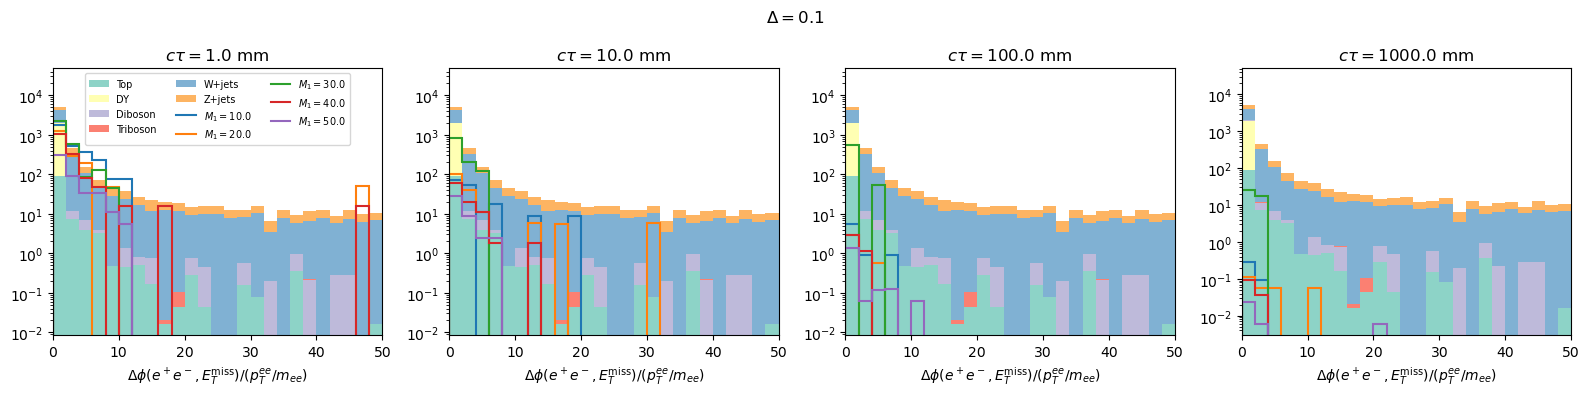

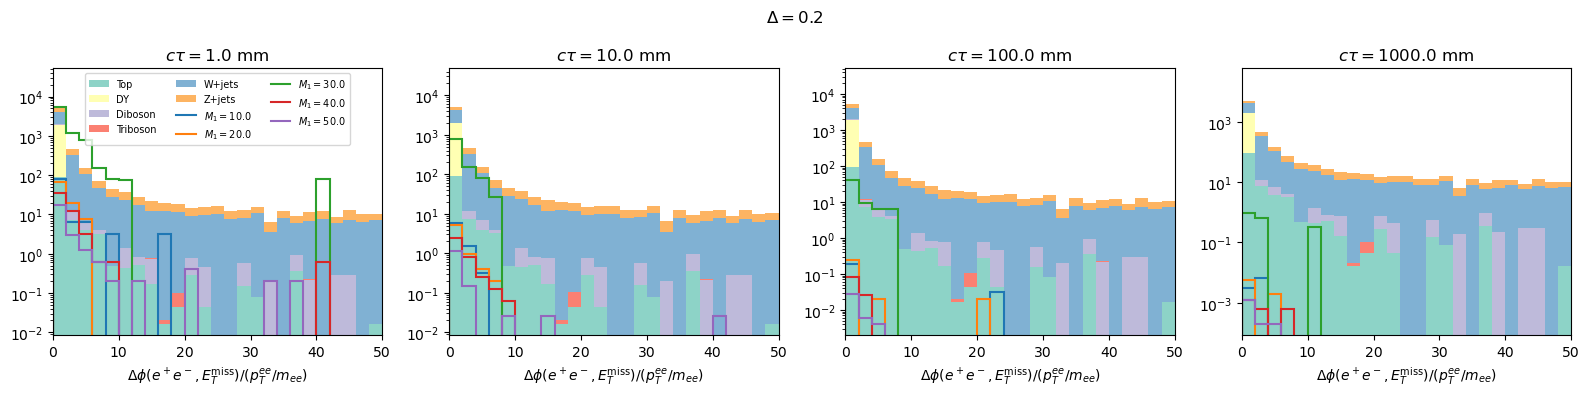

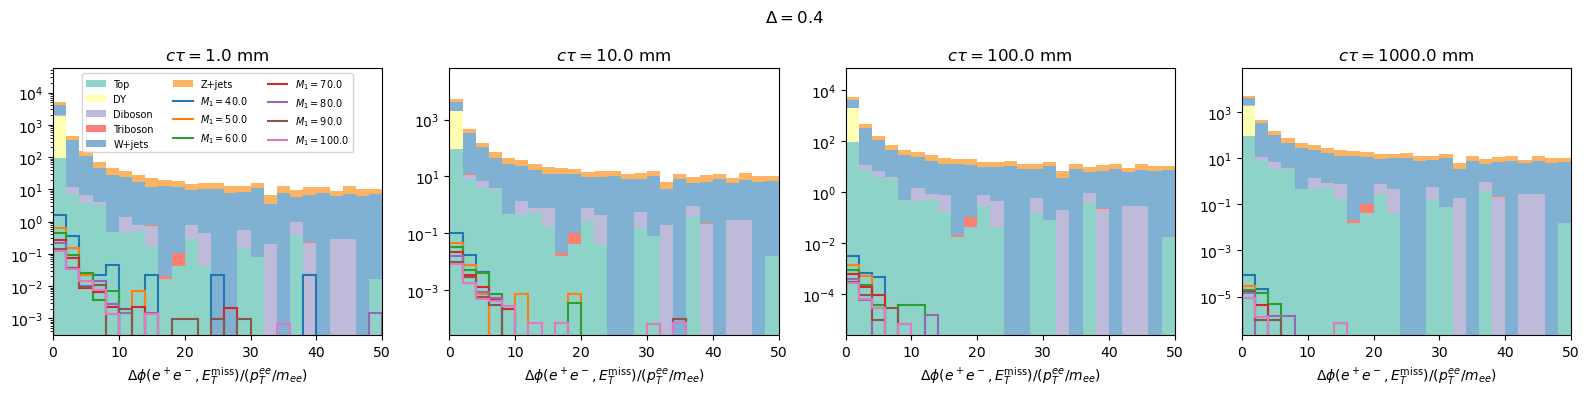

In [50]:
# vertex MET dPhi / (m/pT)
plot("sel_vtx_METdPhi_over_mpT",[0,50],logy=True,rebin=4j,xlabel=r"$\Delta \phi(e^+e^-,E_T^\mathrm{miss})/(p_T^{ee}/m_{ee})$")

# Vertex Chi2

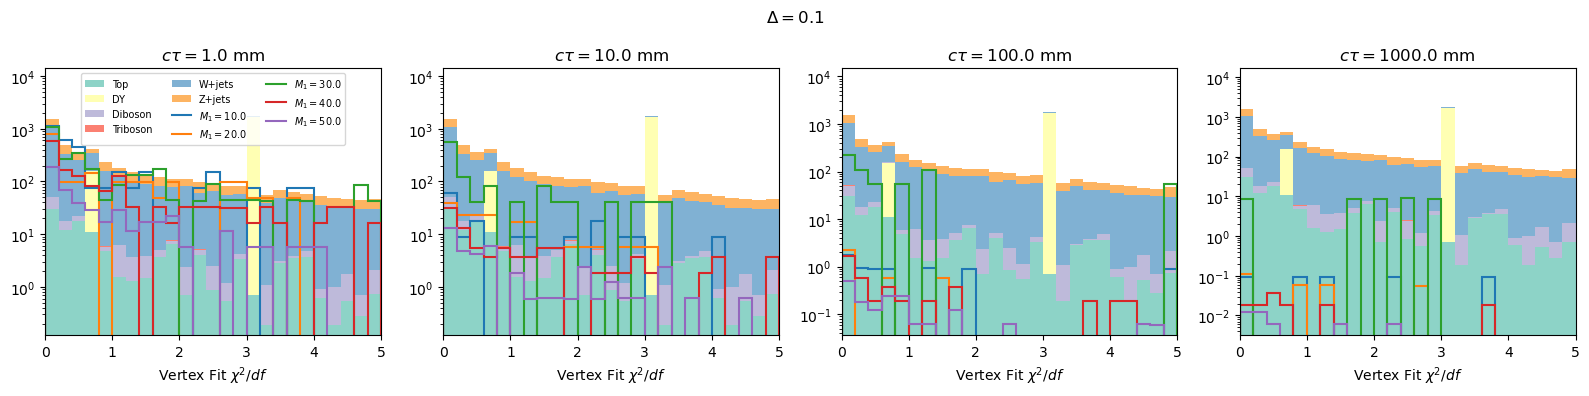

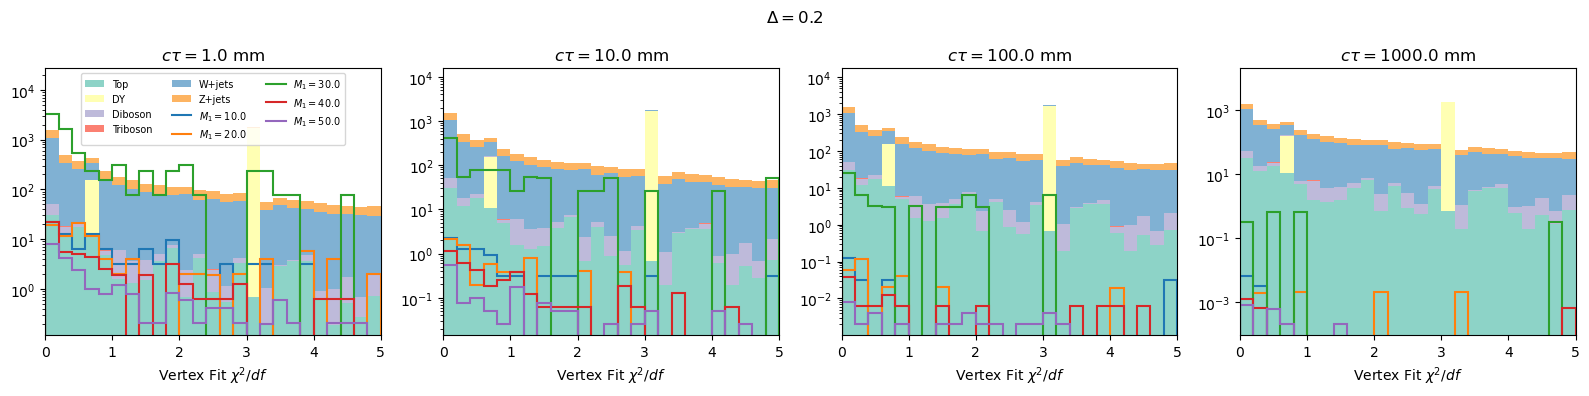

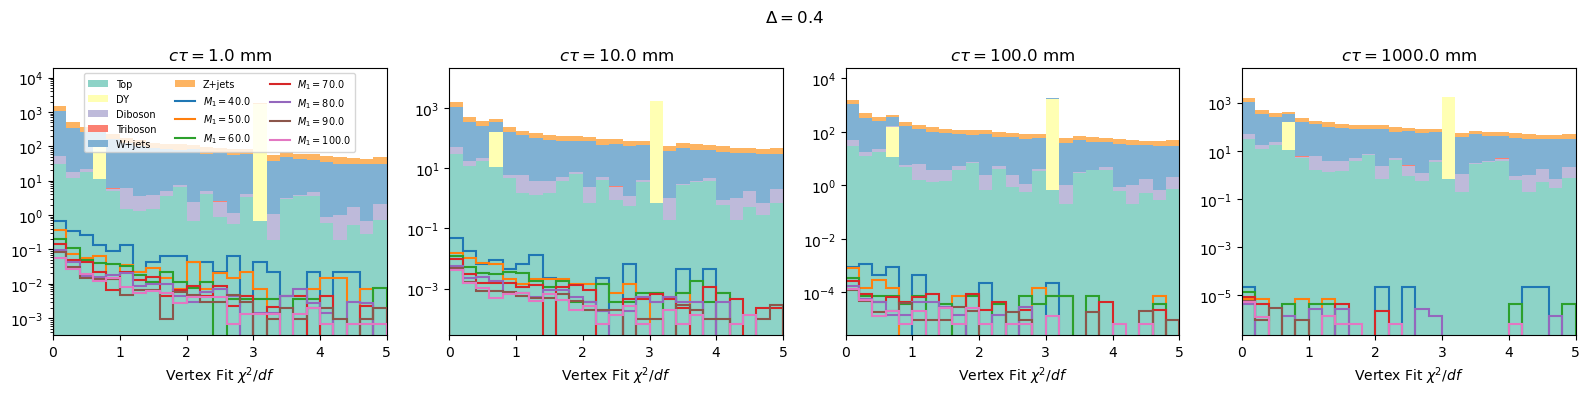

In [58]:
# vertex chi2
plot("sel_vtx_chi2",[0,5],logy=True,rebin=1j)

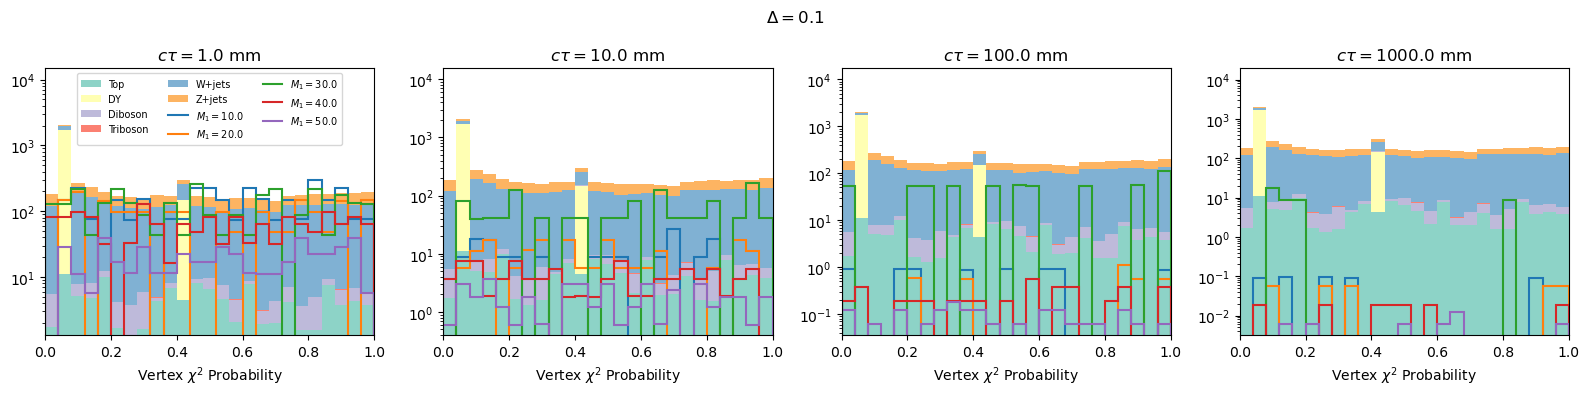

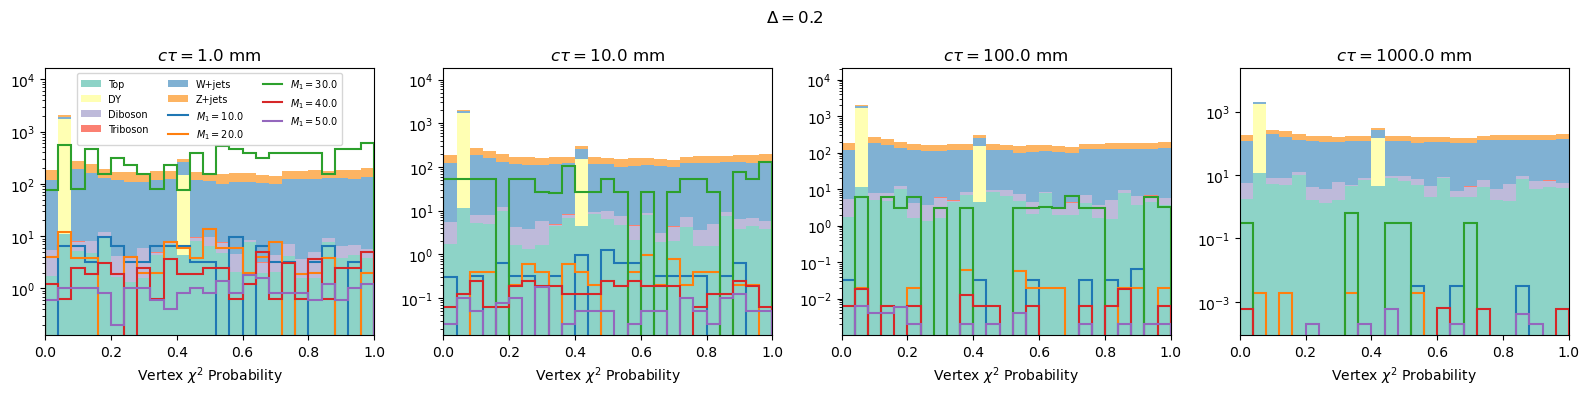

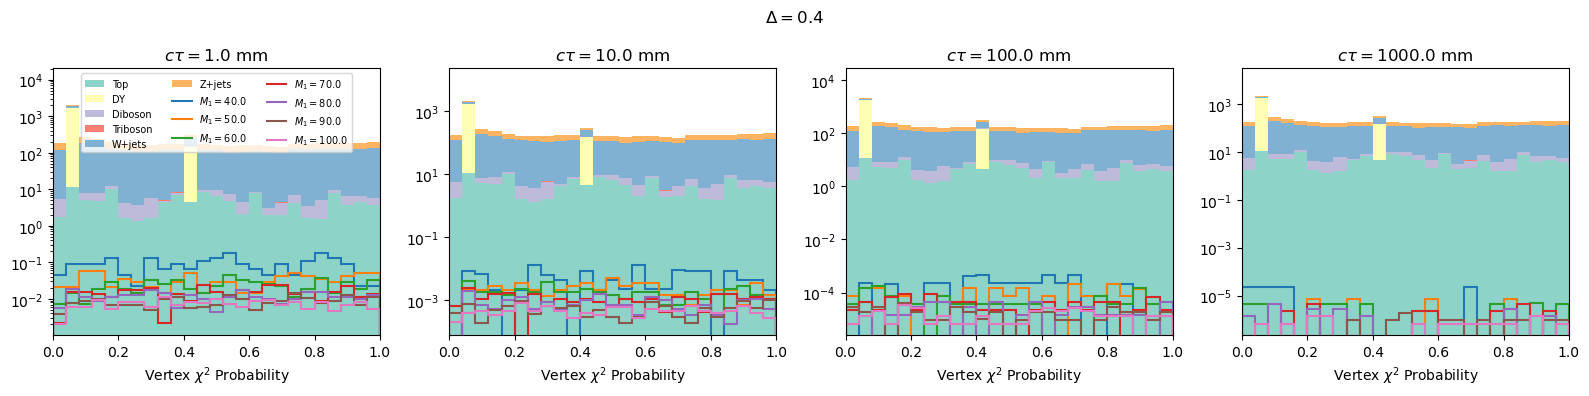

In [52]:
# vertex prob
plot("sel_vtx_prob",[0,1],logy=True,rebin=4j)

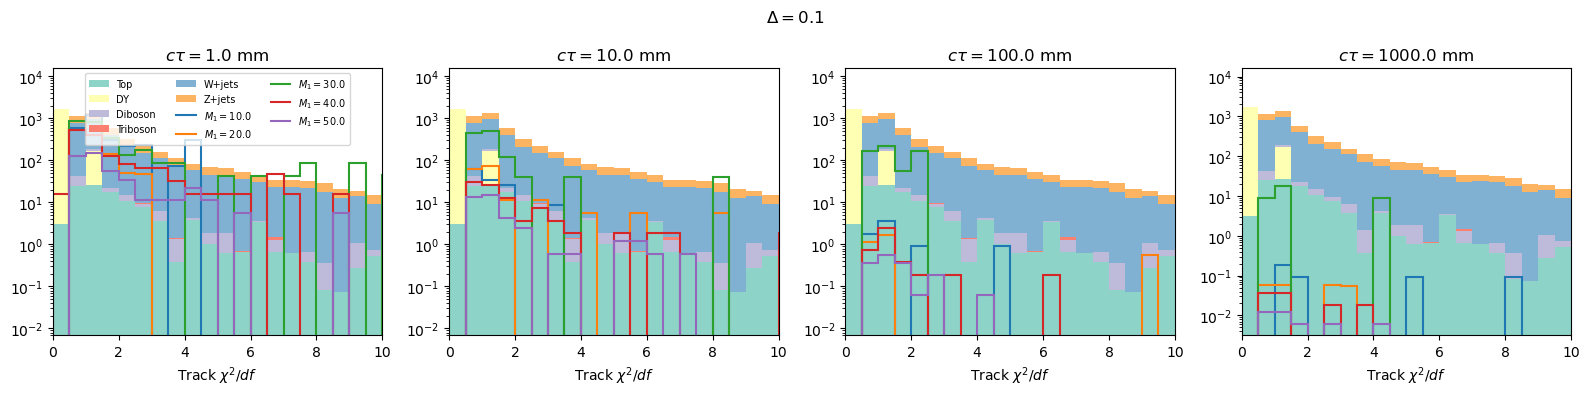

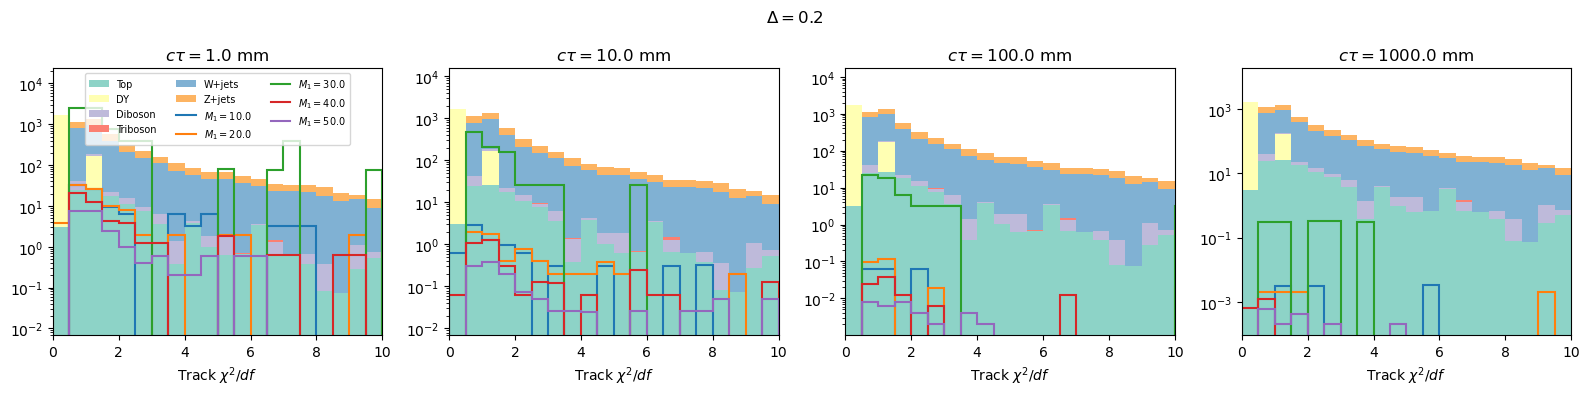

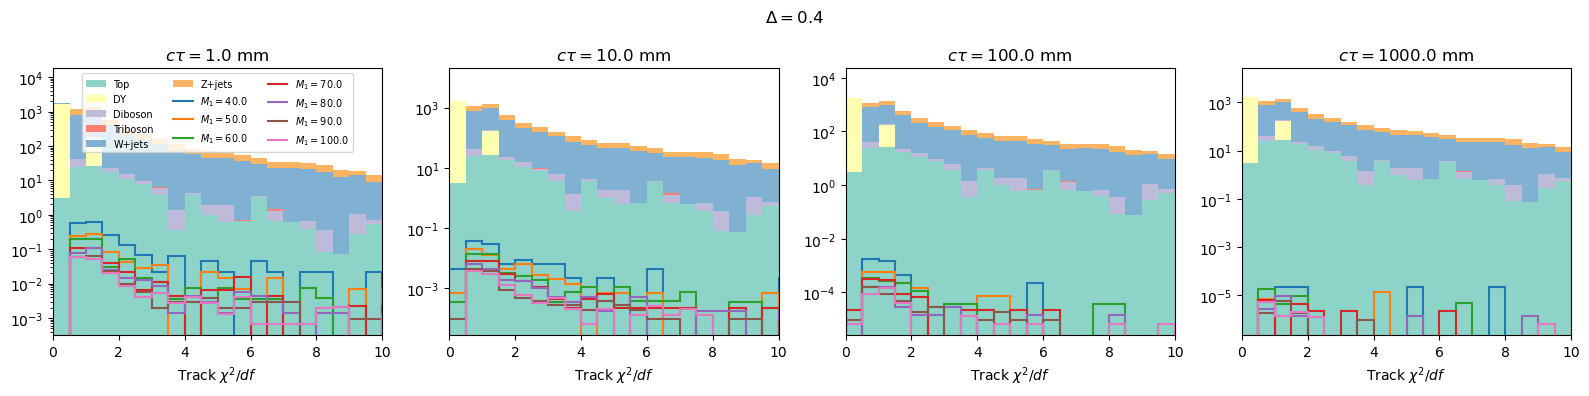

In [53]:
# vertex max(e1_chi2,e2_chi2)
plot("sel_vtx_max_chi2",[0,10],logy=True,rebin=1j)

# Electron-jet dR

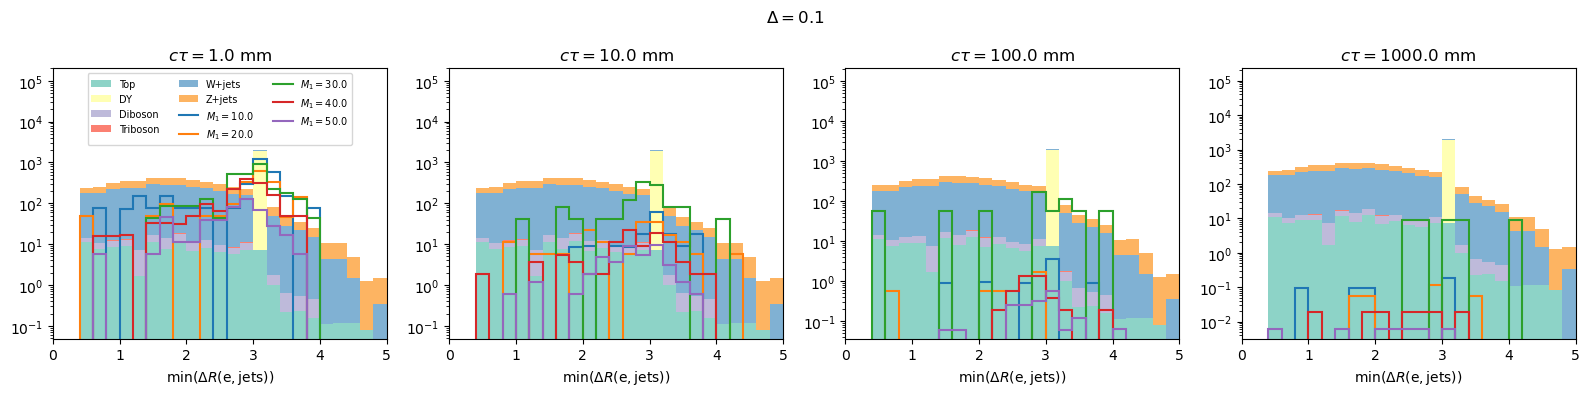

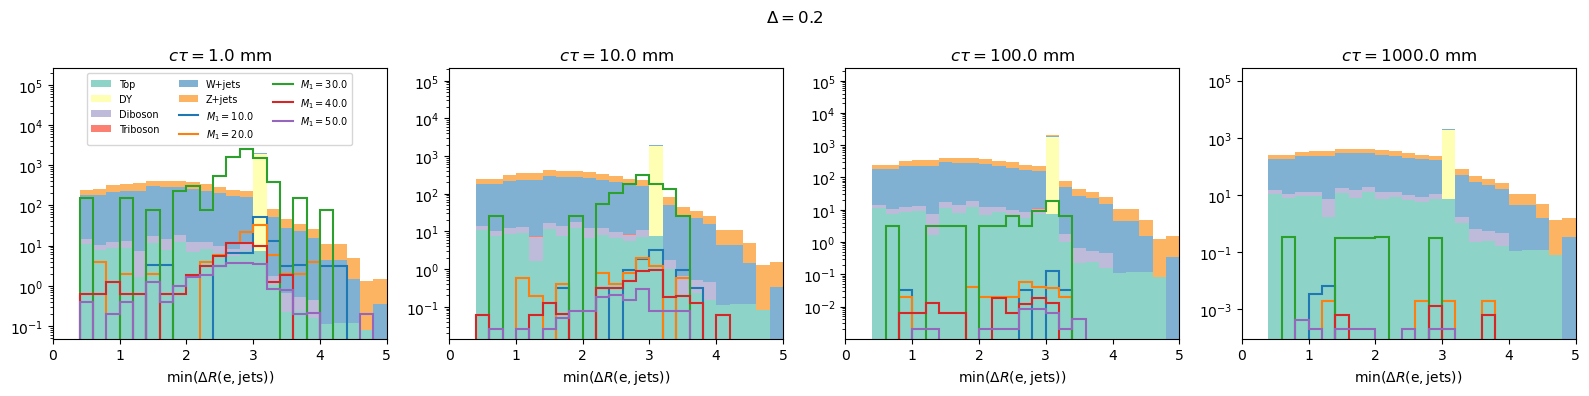

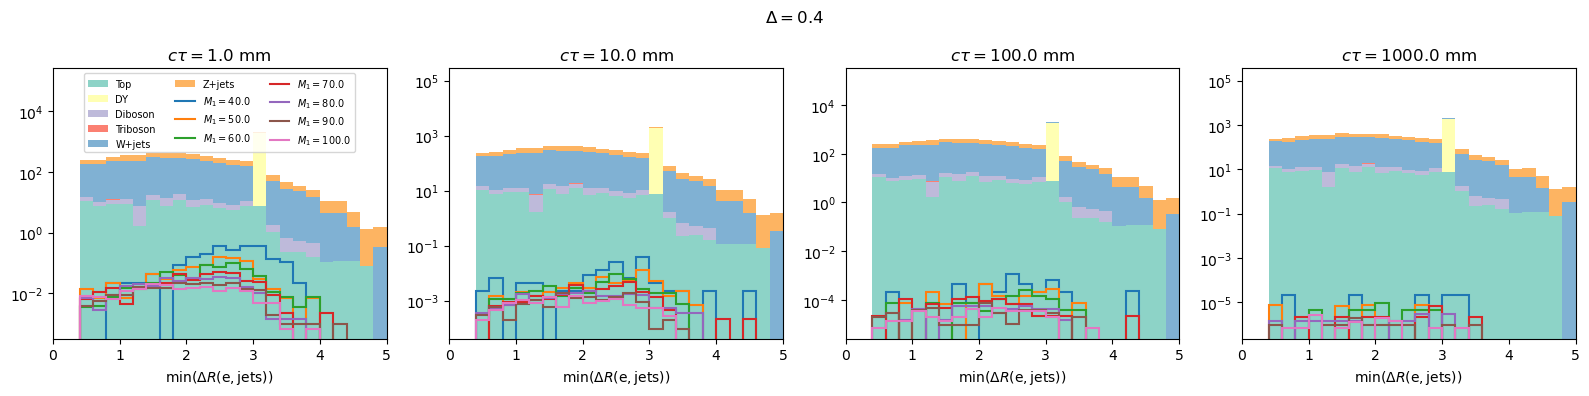

In [54]:
# mindR(vtx_eles,jets)
plot("sel_vtx_minEledRj",[0,5],logy=True,rebin=2j,scaley=60)

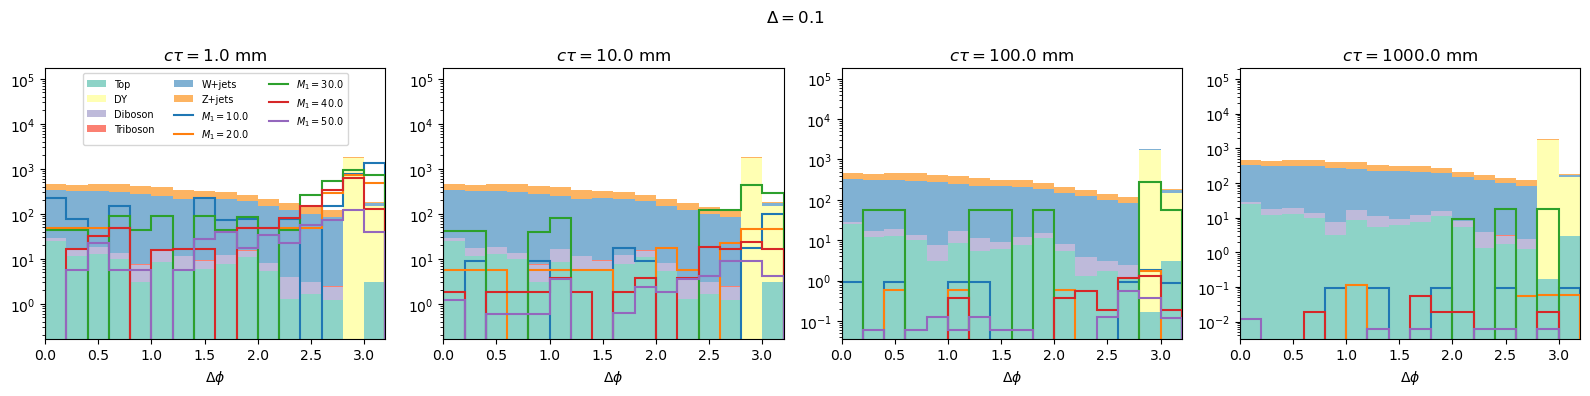

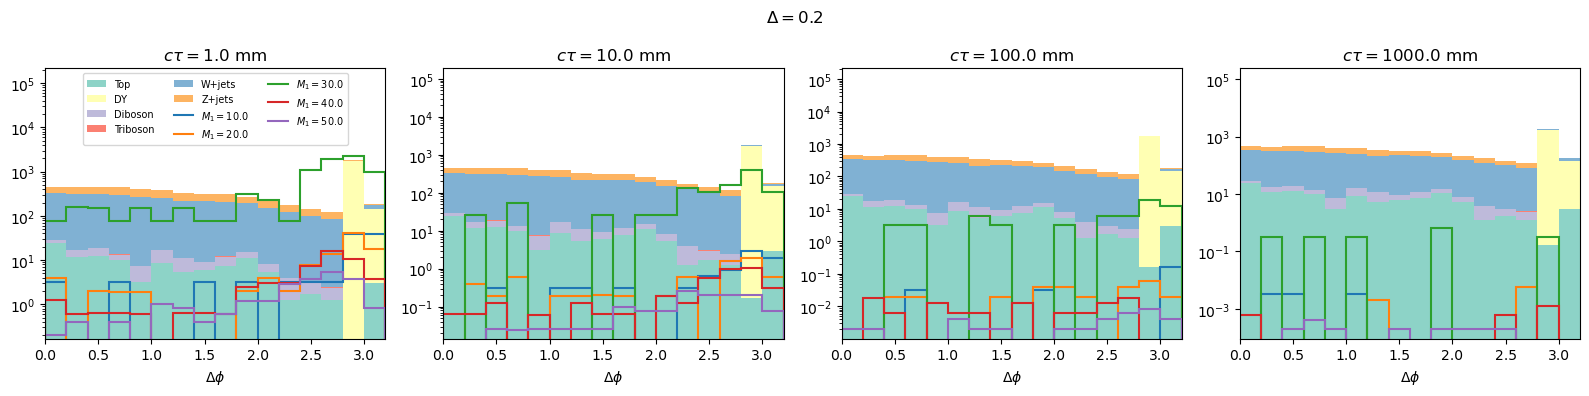

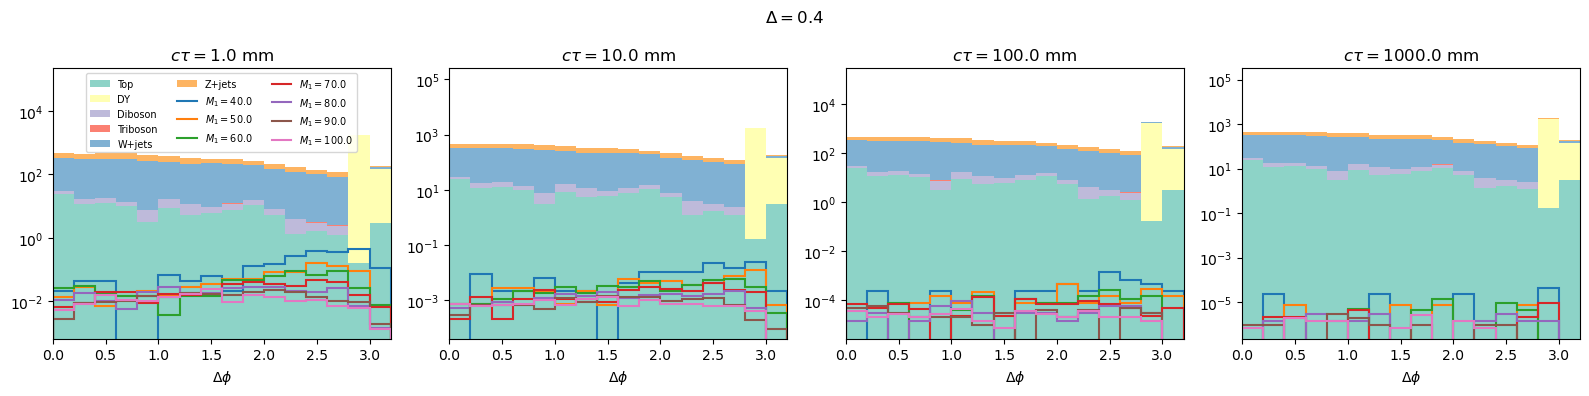

In [55]:
# mindPhi(vtx_eles,jets)
plot("sel_vtx_minEledPhiJ",[0,3.2],logy=True,rebin=2j,scaley=60)

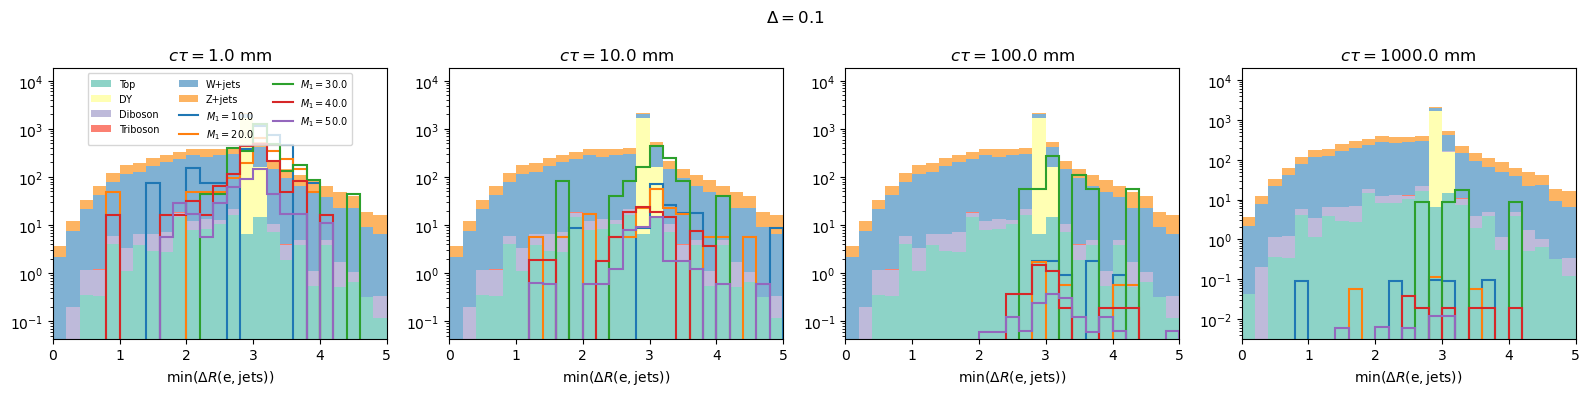

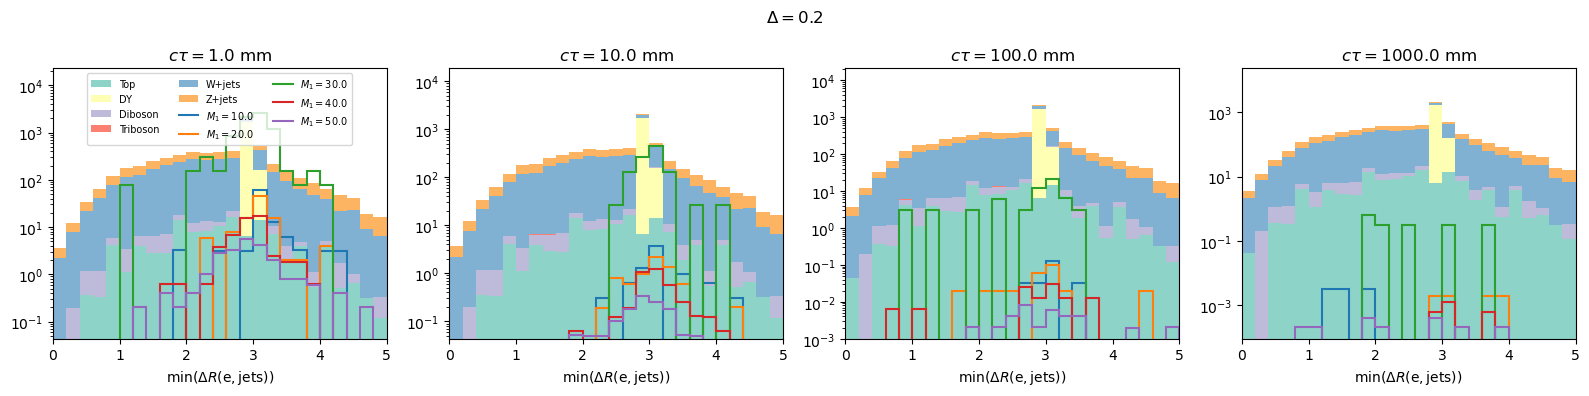

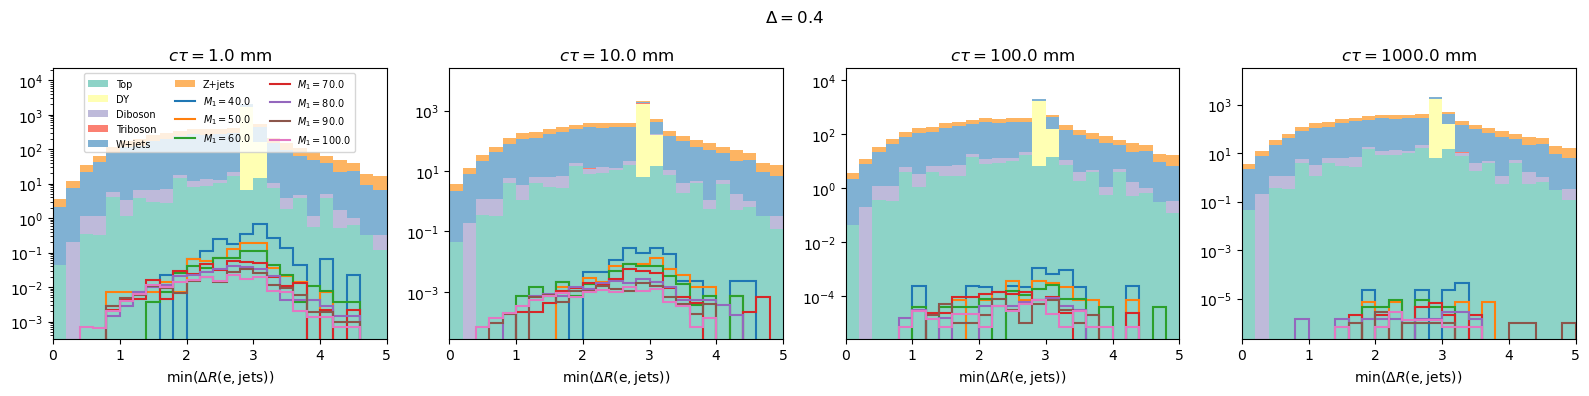

In [56]:
# mindR(vtx,jets)
plot("sel_vtx_mindRj",[0,5],logy=True,rebin=2j)

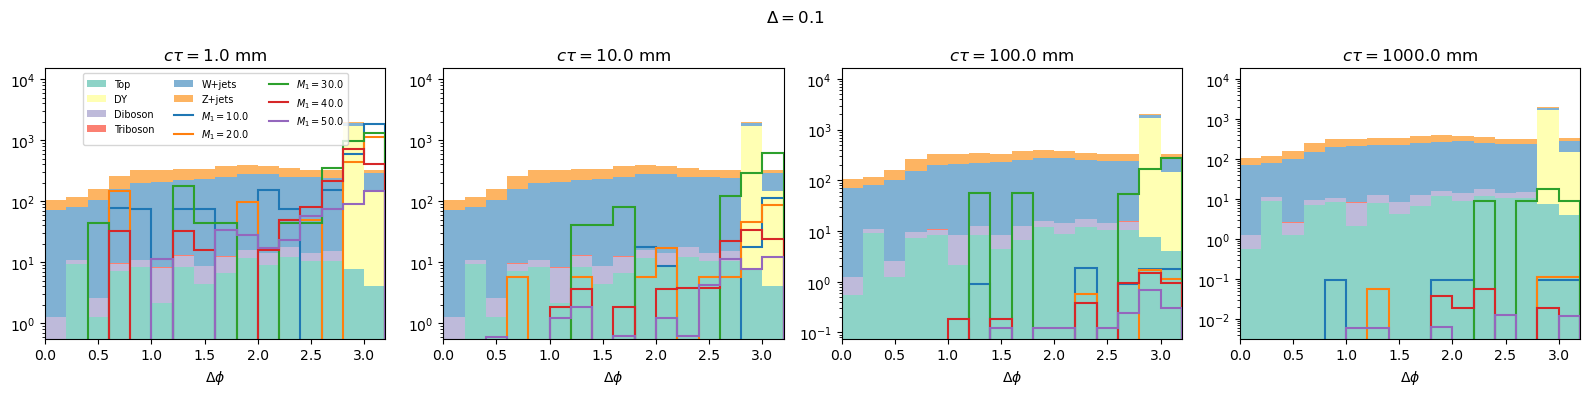

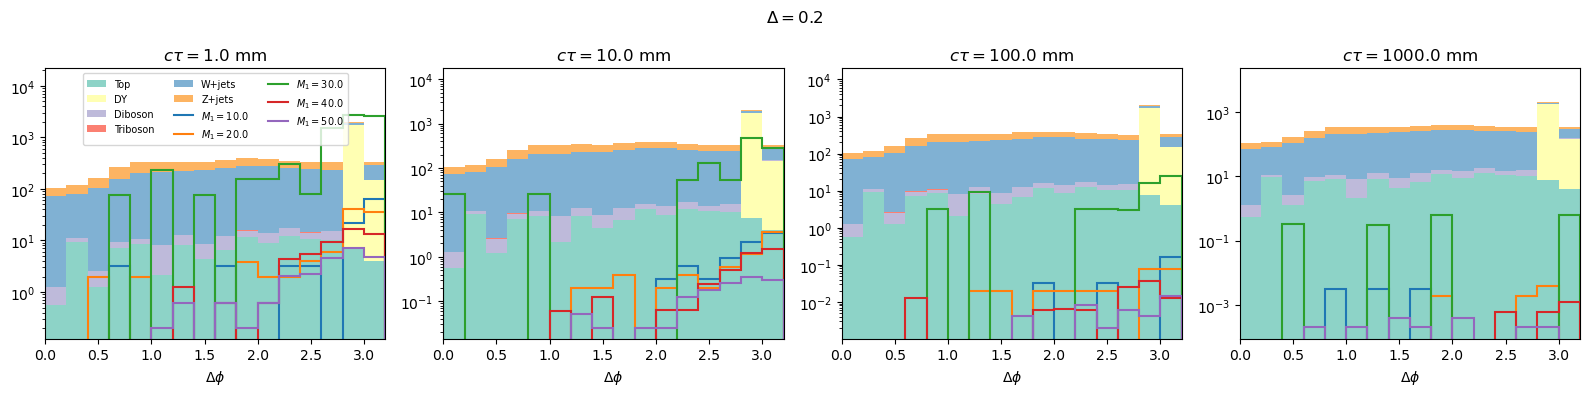

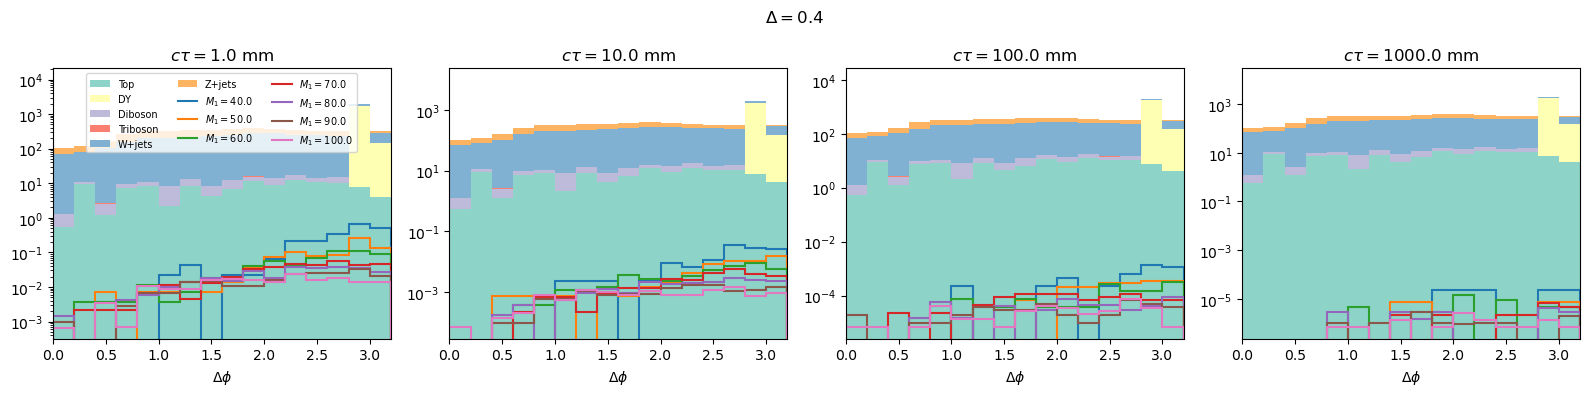

In [57]:
# mindPhi(vtx,jets)
plot("sel_vtx_mindPhiJ",[0,3.2],logy=True,rebin=2j)